In [33]:
import os, json, sys, gzip, pickle, time, tqdm, copy
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
from src.utils import MetalElements, ActiveElements, AllElements
from src.utils import composit_parser, check_precursor_frequency, screening_reactions_by_freq
from src.feature import active_composit_feature, composition_to_feature
#from src.data import composition_to_feature, feature_to_composition
from pymatgen.core import Element

# Raw file parsing

In [38]:
data_root = '/home/jhyang/WORKSPACES/DATA/synthesis/SynthesisSimilarity/rsc'
os.listdir(data_root)

['ele_order_counter.json',
 'pre_count_normalized_by_rxn_ss.json',
 'data_split.npz',
 'reactions_v20_20210820_ss.jsonl']

## loading raw jsonl file

- raw data file

In [39]:
# raw json file
with open(f'{data_root}/reactions_v20_20210820_ss.jsonl') as f:
    full_data = [json.loads(l) for l in list(f)]

i = np.random.randint(len(full_data))

_data = full_data[36728]

#for _data in full_data:
#    if _data['doi'] != '10.1103/physrevb.95.054430':
#        continue

#def print_data(dat):
#    for key in ['material_string','material_formula']:
#        print(key, '\t:', dat[key])
#    for _d in dat['composition']:
#        print('\t', _d['formula'], '/', _d['elements'])
#print(i, _data['doi'])
#print_data(_data['target'])
#print()
#for _prec in _data['precursors']: print_data(_prec)

In [95]:
for data in full_data:
    if data['doi'] == '10.1021/jp500110f':
        print(data)

{'_id': '607a5327cb02324d72a23ab8', 'doi': '10.1021/jp500110f', 'synthesis_type': 'solid_state_ceramic_synthesis', 'ext_abstract': [], 'ext_paragraph': ['A series of samples with nominal chemical formulas NaCa1-xEuxPO4 (x = 0.002, 0.003, 0.0045, 0.006, 0.0075, 0.009, 0.0105, and 0.012), Na1+yCa1-2yTbyPO4 (y = 0.005, 0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, and 0.15), and Na1+yCa1-x-2yEuxTbyPO4 (x = 0.01, y = 0, 0.003, 0.005, 0.008, 0.01, and 0.012; x = 0, 0.008, 0.009, 0.01, 0.011, and 0.012, y = 0.003) were prepared by a solid state reaction route at high temperature.', 'The reactants are CaCO3 [analytical reagent ], NH4H2PO4, Eu2O3 (99.99%), Tb4O7 (99.99%), and Na2CO3 .', 'They were weighed stoichiometrically and ground thoroughly in an agate mortar.', 'The mixture was first preheated at 500 °C for 3 h, then reground, and finally fired at 950 °C for 6 h in a N2H2 atmosphere.'], 'data_per_sentence': [{'sentence': 'A series of samples with nominal chemical formulas NaCa1-xEuxPO4 (x = 

## loading raw npz file

- raw numpy file

In [41]:
# raw numpy file
npz_data = {k:v for k,v in np.load(f'{data_root}/data_split.npz', allow_pickle=True).items()}

- check data

In [7]:
# check 
for ds_rxn, ds in npz_data.items():
    for i, data in enumerate(ds):
#        n = (d['target_comp'][0] != d['target_comp_featurized'][0]).sum()
        chem = data['prototype_path'][0].split('/')[-1]
        if data['doi'] == '10.1016/j.actamat.2006.08.010':
            print(ds_rxn, i)
            for prot in data['prototype_path']:
                print(prot.split('/')[4:])

train_reactions 8866
['Mg0.3Nb0.7PbO3', 'NoDoping', 'Mg0.333Nb0.66699994Pb1O3', 'Mg0.333Nb0.66699994Pb1O3']


In [8]:
import re

re_spec = re.compile(r'\d+(\.\d+)?')
re_ele = re.compile(r'[A-Z][a-z]?')
print(chem)
chem = data['prototype_path'][0].split('/')[-1]
ns = [float(m.group()) for m in re_spec.finditer(chem)]
eles = [m.group() for m in re_ele.finditer(chem)]
print(eles, ns)
#comp = dat['target_comp'][0]
#m = comp != 0
#
#for i in np.where(m)[0]:
#    print(i, comp[i])

Ta0.1665833Ti0.1665833Nb0.1665833N0.50025016
['Ta', 'Ti', 'Nb', 'N'] [0.1665833, 0.1665833, 0.1665833, 0.50025016]


In [9]:
for ds_rxn, ds in npz_data.items():
    for i, data in enumerate(ds):
        if len(data['target_comp']) != 1:
            print(ds_rxn, i, data['raw_id'])

# Parsing data

In [2]:
data_root = '/home/jhyang/WORKSPACES/DATA/synthesis/SynthesisSimilarity/rsc'
os.listdir(data_root)

['ele_order_counter.json',
 'pre_count_normalized_by_rxn_ss.json',
 'data_split.npz',
 'reactions_v20_20210820_ss.jsonl']

## raw file

- Changing composition vector to composition dictionary
- Unfiying temperature and time scales

In [19]:
ele_dict = {i:{} for i in range(100)}
#for d in npz_data['test_reactions']:
units = {'temp':{}, 'time':{}}
for ds_rxn, dataset in npz_data.items():
    for i, data in enumerate(dataset):
        chem = data['prototype_path'][0].split('/')[-1]
        if '(' in chem: continue
        ns = [float(m.group()) for m in re_spec.finditer(chem)]
        eles = [m.group() for m in re_ele.finditer(chem)]
        if len(eles) != len(ns): continue
        comp = data['target_comp'][0]
        idxs = np.where(comp != 0)[0]
#        print(chem)
#        print(eles)
#        print(ns)
#        print(comp[idxs] * np.sum(ns))
    #    print(idxs)
        for n, ele in zip(ns, eles):
            j = np.where(np.abs(comp[idxs] * np.sum(ns) - n) < 1e-3)[0]
            if len(j) != 1:
                continue
            k = idxs[j[0]]
#            print(ele, j[0], idxs[j[0]])
            if ele not in ele_dict[k].keys():
                ele_dict[k][ele] = 0
            ele_dict[k][ele] += 1
#            if ele_dict[k][ele] < 15:
#                ele_dict[k]['ids'].append(data['doi'])
        for op in data['operations']:
            for temp in op['attributes']['temperature']:
                unit = temp['units']
                if unit not in units['temp'].keys():
                    units['temp'][unit] = 0
                units['temp'][unit] +=1
            for time in op['attributes']['time']:
                unit = time['units']
                if unit not in units['time'].keys():
                    units['time'][unit] = 0
                units['time'][unit] +=1
                

NameError: name 're_spec' is not defined

In [11]:
ele_mapper = {}
ele_indexer = [v for k,v in ele_dict.items()]
for k, v in ele_dict.items():
    if len(v.keys()) == 1:
        ele = list(v.keys())[0]
        ele_mapper[ele] = k
        ele_indexer[k] = ele

print(json.dumps(ele_dict, indent=4))
print(json.dumps(ele_mapper, indent=4))
#with open('../dump/ele_mapper.json','w') as f:
#    json.dump(ele_mapper, f, indent=4)

{
    "0": {
        "Cs": 87
    },
    "1": {
        "K": 70
    },
    "2": {
        "Rb": 24
    },
    "3": {
        "Ba": 4731
    },
    "4": {
        "Na": 1774
    },
    "5": {
        "Sr": 4884
    },
    "6": {
        "Li": 2728
    },
    "7": {
        "Ca": 4139
    },
    "8": {
        "La": 4719
    },
    "9": {
        "Tb": 466
    },
    "10": {
        "Yb": 475
    },
    "11": {
        "Ce": 1632
    },
    "12": {
        "Pr": 629
    },
    "13": {
        "Nd": 822
    },
    "14": {
        "Sm": 747
    },
    "15": {
        "Eu": 1396
    },
    "16": {
        "Gd": 1048
    },
    "17": {
        "Dy": 402
    },
    "18": {
        "Y": 2272
    },
    "19": {
        "Ho": 214
    },
    "20": {
        "Er": 267
    },
    "21": {
        "Tm": 56
    },
    "22": {
        "Lu": 330
    },
    "23": {
        "Pu": 17
    },
    "24": {
        "Am": 2
    },
    "25": {
        "Cm": 1
    },
    "26": {
        "Hf": 158
    },
    "27": 

In [12]:
#units
unit_convertors = {
    '°C': lambda x: x + 273.15,
    'C': lambda x: x + 273.15,
    'K': lambda x: x,
    'h': lambda x: x,
    'hours': lambda x: x,
    'min': lambda x: x/60,
    'day': lambda x: x * 24,
    'minutes': lambda x: x/60,
    'hr': lambda x: x,
    'd': lambda x: x * 24,    
    'hrs': lambda x: x,
    'hour': lambda x: x,
}

In [13]:
import copy

#parsed_data = {}
raw_data = []
weights = []
for k, dataset in npz_data.items():
#    parsed_data[k] = []
    for data in dataset:
        _data = {}
        for key in ['id', 'raw_index', 'synthesis_type', 'doi', 'year', 'prototype_path', 'count_weight']:
            _data[key] = copy.deepcopy(data[key])
        #weights.append(data['count_weight'])
        #print(data['doi'], data['count_weight'])
        target_vec = data['target_comp'][0]
        target_comp = {ele_indexer[i]:target_vec[i] for i in np.where(target_vec)[0]}
        precursors = []
        for preccursor_vec in data['precursors_comp']:
            precursor_vec = preccursor_vec[0]
            precursor_comp = {ele_indexer[i]:precursor_vec[i] for i in np.where(precursor_vec)[0]}
            precursors.append(precursor_comp)
        _data['target_comp'] = target_comp
        _data['precursor_comp'] = precursors
        operations = []
        prev_op = None
        num_val = 0
        for op in data['operations']:
            check = False
            _op = {'type': op['type'], 'string': op['string'], 
                   'attributes':{
                       'temperature':[], 'time':[], 'env':[]
                   }}
            for attr_type in ['temperature','time']:
                for attr in op['attributes'][attr_type]:
                    _unit_converter = unit_convertors[attr['units']]
                    _min = attr['min']
                    _max = attr['max']
                    _val = attr['values'] + [_min, _max]
                    _val = sorted([_unit_converter(v) for v in set(_val) if v is not None])
                    if attr_type == 'temperature':
                        _val = [_v for _v in _val if (_v < 4000) and (_v > 0)]
                    if len(_val) == 0:
                        continue
                    _op['attributes'][attr_type].append({
                        'min':np.min(_val),
                        'max':np.max(_val),
                        'values': _val,
                        'unit':'K' if 'temp' in attr_type else 'h',
                    })
                    num_val += 1
                    if len(_val) > 3:
                        check = True
            for env in op['attributes']['environment']:
                if env == '':
                    continue
                _op['attributes']['env'].append(env)
                num_val += 1
            if num_val == 0:
                continue
            operations.append(_op)
#            if check: print(json.dumps(_op, indent=4))
        _data['operations'] = operations
#        parsed_data[k].append(_data)
        raw_data.append(_data)

In [14]:
with gzip.open('../data/raw_data.pkl.gz','wb') as f:
    pickle.dump(raw_data, f)

## collects unique dataset

In [3]:
with gzip.open('../data/raw_data.pkl.gz','rb') as f:
    raw_data = pickle.load(f)

### target

In [3]:
idx_dict = {}
unique_target_data = []
new_idx = 0
for n, data in enumerate(sorted(raw_data, key=lambda x: x['year'])):
    t1 = time.time()
    tstr = composit_parser(data['target_comp'])
    pstr = composit_parser(data['precursor_comp'])
    doi_ = data['doi']
    _temp = []
    _time = []
    for op in data['operations']:
        if not op['type'].startswith('Heating'): continue
        for t in op['attributes']['temperature']:
            _temp.extend([_t for _t in t['values'] if _t > 0])
        for t in op['attributes']['time']:
            _time.extend([_t for _t in t['values'] if _t > 0])
    _temp = sorted(np.unique(_temp)) if len(_temp) != 0 else []
    _time = sorted(np.unique(_time)) if len(_time) != 0 else []
    if tstr not in idx_dict.keys():
        i = new_idx
        j = 0
        k = 0
        idx_dict[tstr] = i
        idx_dict[(tstr, pstr)] = j
        idx_dict[(tstr, pstr, doi_)] = k
        unique_target_data.append({
            'id':i,
            'count':1,
            'year':data['year'],
            'target_comp':data['target_comp'],
            'reactions': [{
                'count':1,
                'year':data['year'],
                'precursor_comp':data['precursor_comp'],
                'dois':[doi_],
                'years':[data['year']],
                'heat_temp':[{'mean':None, 'median':None, 'raw':[]}],
                'heat_time':[{'mean':None, 'median':None, 'raw':[]}] 
            }],
        })
        new_idx += 1
    else:
        i = idx_dict[tstr]
        j = len(unique_target_data[i]['reactions'])
        k = 0
        if (tstr, pstr) not in idx_dict.keys():
            idx_dict[(tstr, pstr)] = j
            idx_dict[(tstr, pstr, doi_)] = k
            unique_target_data[i]['count'] += 1            
            unique_target_data[i]['reactions'].append({
                'count':1,
                'year':data['year'],
                'precursor_comp':data['precursor_comp'],
                'dois':[doi_],
                'years':[data['year']],
                'heat_temp':[{'mean':None, 'median':None, 'raw':[]}],
                'heat_time':[{'mean':None, 'median':None, 'raw':[]}]
            })
        else:
            j = idx_dict[(tstr, pstr)]
            if doi_ in unique_target_data[i]['reactions'][j]['dois']:
                k = idx_dict[(tstr, pstr, doi_)]
            else:
                k = len(unique_target_data[i]['reactions'][j]['dois'])
                idx_dict[(tstr, pstr, doi_)] = k
                unique_target_data[i]['count'] += 1 # count by doc (different DOI)
                unique_target_data[i]['reactions'][j]['count'] += 1
                unique_target_data[i]['reactions'][j]['dois'].append(doi_)
                unique_target_data[i]['reactions'][j]['years'].append(data['year'])
                unique_target_data[i]['reactions'][j]['heat_temp'].append({'mean':None, 'median':None, 'raw':[]})
                unique_target_data[i]['reactions'][j]['heat_time'].append({'mean':None, 'median':None, 'raw':[]})
    unique_target_data[i]['reactions'][j]['heat_temp'][k]['raw'].extend(_temp.copy())
    unique_target_data[i]['reactions'][j]['heat_time'][k]['raw'].extend(_time.copy())
    t = time.time() - t1
    print('{:8d} {:10d} {:15.3f} it/sec'.format(n, len(unique_target_data), 1/t), end='\r')

In [4]:
with gzip.open('../data/unique_target.pkl.gz','wb') as f:
    pickle.dump(unique_target_data, f)

In [4]:
len(unique_target_data[4]['reactions'][0]['dois']), unique_target_data[4]['reactions'][0]['count'], len(unique_target_data[4]['reactions'][0]['heat_temp'])
print(unique_target_data[4]['count'])
unique_target_data[4]['reactions']

110


[{'count': 102,
  'year': 1988,
  'precursor_comp': [{'Ba': 0.2, 'C': 0.2, 'O': 0.6}, {'Fe': 0.4, 'O': 0.6}],
  'dois': ['10.1007/bf00551283',
   '10.1016/s0925-8388(98)00766-x',
   '10.1016/s0025-5408(00)00382-2',
   '10.1016/s0025-5408(01)00751-6',
   '10.1016/s0304-8853(01)00288-8',
   '10.1016/s0304-8853(02)01387-2',
   '10.1016/j.jssc.2003.10.021',
   '10.1016/j.matlet.2004.05.017',
   '10.1016/s0304-8853(03)00559-6',
   '10.1016/s0304-8853(03)00586-9',
   '10.1016/j.jmmm.2004.07.033',
   '10.1016/j.matlet.2004.09.012',
   '10.1016/j.matlet.2005.01.072',
   '10.1016/j.powtec.2005.05.003',
   '10.1063/1.2058220',
   '10.1103/physrevb.72.104420',
   '10.1007/s10853-006-0921-y',
   '10.1016/j.jaap.2006.08.005',
   '10.1016/j.jmmm.2006.07.032',
   '10.1016/j.jmmm.2006.08.003',
   '10.1016/j.jmmm.2007.04.012',
   '10.1016/j.tsf.2007.03.013',
   '10.1007/s10854-007-9411-5',
   '10.1016/j.matlet.2007.09.073',
   '10.1002/pssa.200925104',
   '10.1007/s10854-008-9744-8',
   '10.1016/j.jeur

In [6]:
[np.array(t['raw']) - 273.15 for t in unique_target_data[4]['reactions'][0]['heat_temp']]

[array([1100., 1300.]),
 array([], dtype=float64),
 array([1200.]),
 array([ 950., 1000.]),
 array([ 675., 1000.]),
 array([], dtype=float64),
 array([ 699.85,  999.85, 1199.85]),
 array([1050.]),
 array([500., 650.]),
 array([1000.]),
 array([1000., 1000.]),
 array([1050.]),
 array([1050.]),
 array([], dtype=float64),
 array([1249.85]),
 array([1300.]),
 array([ 400., 1000.]),
 array([1200.]),
 array([1200.]),
 array([1300.]),
 array([1200., 1300.]),
 array([ 800.,  850.,  900.,  950., 1000.]),
 array([], dtype=float64),
 array([1250.]),
 array([ 900., 1200.]),
 array([], dtype=float64),
 array([1100.]),
 array([1000.]),
 array([1160.]),
 array([100.]),
 array([840., 900.]),
 array([ 800., 1000., 1100.]),
 array([1000.]),
 array([1150., 1250.]),
 array([ 850.,  900., 1000., 1100.]),
 array([ 100.,  450., 1000.]),
 array([1000.]),
 array([ 100.,  450., 1000.]),
 array([1200.]),
 array([ 900., 1200.]),
 array([ 900., 1000., 1100., 1110.]),
 array([1080., 1350.]),
 array([1100.]),
 array

- 제대로 만들어 졌는지 체크

In [5]:
for k in range(5000, len(unique_target_data)):
    if unique_target_data[k]['count'] > 20: print(k,unique_target_data[k]['count'])
k = 6520  

5942 29
6050 27
6380 24
6520 87
6655 29
6891 27
7744 30
7786 26
9052 23
11125 57


In [101]:
rstr = composit_parser(unique_target_data[k]['target_comp'])
temps = {}
for d in raw_data:
    tstr = composit_parser(d['target_comp'])
    if rstr != tstr: continue
    pstr = composit_parser(d['precursor_comp'])
    if pstr not in temps.keys():
        temps[pstr] = []
    for op in d['operations']:
        if not op['type'].startswith('Heat'): continue
        for temp in op['attributes']['temperature']:
            temps[pstr] += temp['values']
            
for rxn in unique_target_data[k]['reactions']:
    pstr = composit_parser(rxn['precursor_comp'])
    print()
    _temp = []
    for t in rxn['heat_temp']:
        _temp += t['raw']
    t1 = np.array(sorted(temps[pstr]))
    t2 = np.array(sorted(_temp))
    print(pstr, len(t1), len(t2))
    print(t1)
    print(t2)


H_0.33333 Li_0.33333 O_1.60000 Zr_0.33333 La_0.40000 46 45
[ 273.23  273.23  973.15 1023.15 1073.15 1073.15 1073.15 1123.15 1123.15
 1123.15 1123.15 1123.15 1123.15 1173.   1173.15 1173.15 1173.15 1173.15
 1173.15 1173.15 1173.15 1223.15 1223.15 1223.15 1273.15 1273.15 1273.15
 1273.15 1273.15 1273.15 1348.15 1373.15 1398.   1398.15 1398.15 1403.15
 1403.15 1413.15 1423.15 1448.15 1473.15 1473.15 1473.15 1503.   1503.15
 1503.15]
[ 273.23  973.15 1023.15 1073.15 1073.15 1073.15 1123.15 1123.15 1123.15
 1123.15 1123.15 1123.15 1173.   1173.15 1173.15 1173.15 1173.15 1173.15
 1173.15 1173.15 1223.15 1223.15 1223.15 1273.15 1273.15 1273.15 1273.15
 1273.15 1273.15 1348.15 1373.15 1398.   1398.15 1398.15 1403.15 1403.15
 1413.15 1423.15 1448.15 1473.15 1473.15 1473.15 1503.   1503.15 1503.15]

Li_0.33333 C_0.16667 O_1.76667 Zr_0.33333 La_0.40000 54 53
[ 423.15  433.15  473.15  573.15  623.15  873.15  923.15 1073.15 1073.15
 1073.15 1073.15 1123.15 1123.15 1123.15 1173.   1173.15 1173.15 1

TODO: frequency based weight calculation

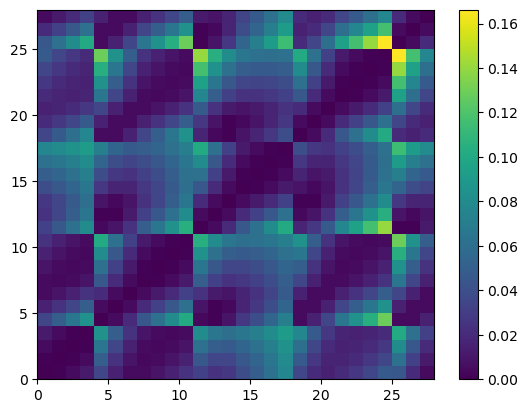

In [38]:
vs = []
target_comps = []
for data in raw_data:
    if data['doi'] != '10.1016/j.jnoncrysol.2020.119991':
        continue
    target_comps.append(data['target_comp'])
    vs.append(active_composit_feature(data['target_comp']))
v = np.vstack(vs)
n = len(v)
mat = np.square((v[..., np.newaxis] - v.T[np.newaxis, ...])).sum(1)
m = plt.pcolormesh(mat)
plt.colorbar(m)

In [39]:
target_comps[np.argmax(mat) // n], target_comps[np.argmax(mat) % n]

({'Ge': 0.325, 'Sb': 0.2, 'Se': 0.475}, {'Ge': 0.1, 'Sb': 0.1, 'Se': 0.8})

In [40]:
compstrs = []
for data in raw_data:
    if data['doi'] == '10.1039/c7cp00358g':
        tstr = composit_parser(data['target_comp'])
        pstr = composit_parser(data['precursor_comp'])
        print(tstr)
        print(pstr)
        print()
#        compstrs.append(compstr)
np.unique(compstrs, return_counts=True)

Na_0.00500 Se_0.50000 Pb_0.49500
Na_1.00000 Se_1.00000 Pb_1.00000

Na_0.00500 Se_0.50000 Eu_0.00500 Pb_0.49000
Na_1.00000 Se_1.00000 Eu_1.00000 Pb_1.00000

Na_0.00500 Se_0.50000 Eu_0.01000 Pb_0.48500
Na_1.00000 Se_1.00000 Eu_1.00000 Pb_1.00000

Na_0.00500 Se_0.50000 Eu_0.01500 Pb_0.48000
Na_1.00000 Se_1.00000 Eu_1.00000 Pb_1.00000

Na_0.00500 Se_0.50000 Eu_0.02000 Pb_0.47500
Na_1.00000 Se_1.00000 Eu_1.00000 Pb_1.00000

Na_0.00500 Se_0.50000 Eu_0.03000 Pb_0.46500
Na_1.00000 Se_1.00000 Eu_1.00000 Pb_1.00000

Na_0.00500 Se_0.50000 Eu_0.04500 Pb_0.45000
Na_1.00000 Se_1.00000 Eu_1.00000 Pb_1.00000

Na_0.00500 Se_0.50000 Eu_0.06000 Pb_0.43500
Na_1.00000 Se_1.00000 Eu_1.00000 Pb_1.00000

Se_0.50000 Eu_0.00500 Pb_0.49500
Se_1.00000 Eu_1.00000 Pb_1.00000

Na_0.00500 Se_0.50000 Eu_0.00500 Pb_0.49000
Na_1.00000 Se_1.00000 Eu_1.00000 Pb_1.00000

Na_0.01000 Se_0.50000 Eu_0.00500 Pb_0.48500
Na_1.00000 Se_1.00000 Eu_1.00000 Pb_1.00000

Na_0.01500 Se_0.50000 Eu_0.00500 Pb_0.48000
Na_1.00000 Se_1.00000

(array([], dtype=float64), array([], dtype=int64))

### reaction & precursor

In [507]:
with gzip.open('../data/unique_target.pkl.gz','rb') as f:
    unique_target_data = pickle.load(f)

In [508]:
unique_target_data[0]

{'id': 0,
 'count': 1,
 'year': 1979,
 'target_comp': {'Y': 0.0020005717,
  'Al': 0.054872826,
  'Si': 0.37153473,
  'N': 0.5144327,
  'O': 0.057159193},
 'reactions': [{'count': 1,
   'year': 1979,
   'precursor_comp': [{'Y': 0.4, 'O': 0.6},
    {'Si': 0.33333334, 'O': 0.6666667},
    {'Al': 0.5, 'N': 0.5},
    {'Si': 0.42857143, 'N': 0.5714286}],
   'dois': ['10.1007/bf00549308'],
   'years': [1979],
   'heat_temp': [{'mean': None, 'median': None, 'raw': []}],
   'heat_time': [{'mean': None, 'median': None, 'raw': []}]}]}

In [509]:
unique_precursor_data = []
unique_reaction_data = []
conditional_reaction_data = []
prec_idx = {}
reaction_id_pairs = {} # uniq_rxn_id : [cond_rxn_ids]
for i, target in enumerate(unique_target_data):
    t1 = time.time()
    tgt = copy.deepcopy(target)
    rxns = tgt.pop('reactions')
    for rxn in rxns:
        # unique reaction
        unique_rxn = copy.deepcopy(tgt)
        unique_rxn.update(copy.deepcopy(rxn))
        unique_rxn['id'] = len(unique_reaction_data)
        unique_reaction_data.append(copy.deepcopy(unique_rxn))
        reaction_id_pairs[unique_rxn['id']] = []
        # conditioned reactions
        for doi, year, _heat_temp, _heat_time in zip(unique_rxn['dois'], unique_rxn['years'], unique_rxn['heat_temp'], unique_rxn['heat_time']):
            heat_temp = copy.deepcopy(_heat_temp)
            if len(heat_temp['raw']) != 0:
                heat_temp['median'] = np.median(heat_temp['raw'])
                heat_temp['mean'] = np.mean(heat_temp['raw'])
            heat_time = copy.deepcopy(_heat_time)
            if len(heat_time['raw']) != 0:
                heat_time['median'] = np.median(heat_time['raw'])
                heat_time['mean'] = np.mean(heat_time['raw'])
            if len(_heat_time['raw']) + len(_heat_temp['raw']) == 0:
                continue
            j = len(conditional_reaction_data)
            conditional_reaction_data.append({
                'id':j,
                'id_urxn':unique_rxn['id'],
                'doi':doi,
                'year':unique_rxn['year'],
                'year_doc':year,
                'count':0,
                'target_comp':unique_rxn['target_comp'],
                'precursor_comp':unique_rxn['precursor_comp'],
                'heat_temp':heat_temp,
                'heat_time':heat_time,
            })
            reaction_id_pairs[unique_rxn['id']].append(j)
        for j in reaction_id_pairs[unique_rxn['id']]:
            conditional_reaction_data[j]['count'] = len(reaction_id_pairs[unique_rxn['id']])

        # unique precursor
        for prec_comp in rxn['precursor_comp']:
            pstr = composit_parser(prec_comp)
            if pstr not in prec_idx.keys():
                prec_idx[pstr] = len(unique_precursor_data)
                unique_precursor_data.append({
                    'id':None,
                    'count':unique_rxn['count'],
                    'count_rxn':1,
                    'year':tgt['year'],
                    'years':{tgt['year']:1},
                    'precursor_str':pstr,
                    'precursor_comp':prec_comp,
                    'dois':unique_rxn['dois'].copy(),
                    'heat_temp':unique_rxn['heat_temp'].copy(),
                    'heat_time':unique_rxn['heat_time'].copy(),
                })
            else:
                k = prec_idx[pstr]
                unique_precursor_data[k]['count'] += unique_rxn['count']
                unique_precursor_data[k]['count_rxn'] += 1
                if tgt['year'] not in unique_precursor_data[k]['years'].keys():
                    unique_precursor_data[k]['years'][tgt['year']] = 1
                    unique_precursor_data[k]['years'] = {k:v for k,v in sorted(unique_precursor_data[k]['years'].items(), key=lambda x: x[0])}
                    unique_precursor_data[k]['year'] = np.min([unique_precursor_data[k]['year'], tgt['year']])
                else:
                    unique_precursor_data[k]['years'][tgt['year']] += 1
                unique_precursor_data[k]['dois'].extend(unique_rxn['dois'].copy())
                unique_precursor_data[k]['heat_temp'].extend(unique_rxn['heat_temp'].copy())
                unique_precursor_data[k]['heat_time'].extend(unique_rxn['heat_time'].copy())
    t = time.time() - t1
    print('{:8d} {:10d} {:10d} {:10d} {:12.3f} it/sec'.format(i, len(unique_precursor_data), len(unique_reaction_data), len(conditional_reaction_data), 1/t), end='\r')
#    print(i, len(unique_reaction_data), f'{1/t:8.3f} it/sec', end='\r')
unique_precursor_data = sorted(unique_precursor_data, key=lambda x: x['count_rxn'], reverse=True)
for i, prec in enumerate(unique_precursor_data):
    prec['id'] = i

- precursor pasring using pymatgen

NOTE: abnormally high integer detected

In [184]:
from pymatgen.core import Composition
unique_precursor_data_v2 = []
prec_idx = {}
for i, target in enumerate(unique_target_data):
    t1 = time.time()
    tgt = copy.deepcopy(target)
    rxns = tgt.pop('reactions')
    for rxn in rxns:
        # unique precursor
        unique_rxn = copy.deepcopy(tgt)
        unique_rxn.update(copy.deepcopy(rxn))
        unique_rxn['id'] = len(unique_reaction_data)

        for prec_comp in rxn['precursor_comp']:
            comp = Composition(prec_comp)
            pstr, div = comp.get_integer_formula_and_factor()
            if pstr not in prec_idx.keys():
                prec_idx[pstr] = len(unique_precursor_data_v2)
                unique_precursor_data_v2.append({
                    'id':None,
                    'count':unique_rxn['count'],
                    'count_rxn':1,
                    'year':tgt['year'],
                    'years':{tgt['year']:1},
                    'precursor_str':pstr,
                    'precursor_comp':{e:f/div for e,f in prec_comp.items()},
                    'dois':unique_rxn['dois'].copy(),
                    'heat_temp':unique_rxn['heat_temp'].copy(),
                    'heat_time':unique_rxn['heat_time'].copy(),
                })
            else:
                k = prec_idx[pstr]
                unique_precursor_data_v2[k]['count'] += unique_rxn['count']
                unique_precursor_data_v2[k]['count_rxn'] += 1
                if tgt['year'] not in unique_precursor_data_v2[k]['years'].keys():
                    unique_precursor_data_v2[k]['years'][tgt['year']] = 1
                    unique_precursor_data_v2[k]['years'] = {k:v for k,v in sorted(unique_precursor_data_v2[k]['years'].items(), key=lambda x: x[0])}
                    unique_precursor_data_v2[k]['year'] = np.min([unique_precursor_data_v2[k]['year'], tgt['year']])
                else:
                    unique_precursor_data_v2[k]['years'][tgt['year']] += 1
                unique_precursor_data_v2[k]['dois'].extend(unique_rxn['dois'].copy())
                unique_precursor_data_v2[k]['heat_temp'].extend(unique_rxn['heat_temp'].copy())
                unique_precursor_data_v2[k]['heat_time'].extend(unique_rxn['heat_time'].copy())
    t = time.time() - t1
    print('{:8d} {:10d} {:10d} {:10d} {:12.3f} it/sec'.format(i, len(unique_precursor_data_v2), len(unique_reaction_data), len(conditional_reaction_data), 1/t), end='\r')
#    print(i, len(unique_reaction_data), f'{1/t:8.3f} it/sec', end='\r')
unique_precursor_data_v2 = sorted(unique_precursor_data_v2, key=lambda x: x['count_rxn'], reverse=True)
for i, prec in enumerate(unique_precursor_data_v2):
    prec['id'] = i

- check length

In [136]:
len(unique_precursor_data), len(unique_precursor_data_v2)

(1038, 1038)

- check error btw rounded and pymatgen-predicted value

In [138]:
errs = []
idxs = []
for i, prec in enumerate(unique_precursor_data_v2):
    for e, n in prec['precursor_comp'].items():
        err = n - np.round(n)
        if err != 0:
            errs.append(err)
            idxs.append(i)
            
for i in sorted(np.where(np.abs(errs) > 1e-3)[0], key=lambda x: np.abs(errs)[x], reverse=True):
    print(idxs[i], errs[i])
    print(unique_precursor_data_v2[idxs[i]]['precursor_comp'], unique_precursor_data_v2[idxs[i]]['precursor_str'])
    print(unique_precursor_data[idxs[i]]['precursor_comp'])

564 0.3427577865134026
{'Co': 1087.2789537345025, 'O': 1449.3427577865134} Co1087O1449
{'Co': 0.42863268, 'O': 0.5713673}
564 0.2789537345024655
{'Co': 1087.2789537345025, 'O': 1449.3427577865134} Co1087O1449
{'Co': 0.42863268, 'O': 0.5713673}
749 0.04005017471553174
{'Mn': 200.02661051877072, 'O': 301.04005017471553} Mn200O301
{'Mn': 0.39920157, 'O': 0.60079837}
709 0.02984205075091495
{'Mn': 255.02984205075091, 'O': 468.9998705334024} Mn255O469
{'Mn': 0.35223672, 'O': 0.6477633}
764 0.02665414892871354
{'Co': 75.01886293616494, 'O': 106.02665414892871} Co75O106
{'Co': 0.41436467, 'O': 0.58563536}
749 0.026610518770723957
{'Mn': 200.02661051877072, 'O': 301.04005017471553} Mn200O301
{'Mn': 0.39920157, 'O': 0.60079837}
764 0.018862936164936173
{'Co': 75.01886293616494, 'O': 106.02665414892871} Co75O106
{'Co': 0.41436467, 'O': 0.58563536}
842 0.018163626198798966
{'Mo': 35.004890022482584, 'H': 130.0181636261988, 'N': 30.00419179061682, 'O': 127.01774372731046} Mo35H130N30O127
{'Mo': 0.

In [146]:
from src.feature import composition_to_feature

vs = np.vstack([composition_to_feature(prec['precursor_comp'], 'composit_ext') for prec in unique_precursor_data])
dist = np.square(vs[..., np.newaxis] - vs.T[np.newaxis, ...]).sum(1)

- 564 -> 20
- 749 -> 38
- 709 -> 15 # MnO2, reduced slightly / MnO1.839
- 764 -> exclude, non-commercial Co3O4.24
- 842 -> 133
- 686 -> exclude, too rare / similar to 562 but different one (or typo in article?)
- 540 -> remove with 541, not properly parsed
- 712 -> mixture of Na2O and Na2O2 / parsing error

however, we will use raw dataset without any correction for consistency of dataset.

In [189]:
def print_info_from_idx(idx, data, doi=False):
    print(data[idx]['precursor_comp'], '\t', data[idx]['count'])
    if doi:
        for _doi in data[idx]['dois']:
            print(f'https://doi.org/{_doi}')

top5 = dist[712].argsort()[:5]
print(top5)
i1, i2 = top5[:2]

print_info_from_idx(i1, unique_precursor_data)
print_info_from_idx(i1, unique_precursor_data_v2, doi=True)
print_info_from_idx(i2, unique_precursor_data)
print_info_from_idx(i2, unique_precursor_data_v2)

[712 208 191 201  13]
{'Na': 0.6369427, 'O': 0.36305735} 	 2
{'Na': 100.00163766440981, 'O': 57.000935808234175} 	 2
https://doi.org/10.1016/j.jnucmat.2017.03.045
https://doi.org/10.1016/j.jnucmat.2017.03.045
{'Na': 0.6666667, 'O': 0.33333334} 	 34
{'Na': 2.0, 'O': 1.0} 	 34


In [188]:
for rxn in unique_reaction_data:
    if '10.1016/j.jnoncrysol.2006.03.124' in rxn['dois']:
        print(rxn)

{'id': 602, 'count': 1, 'year': 2006, 'target_comp': {'Li': 0.2, 'P': 0.2, 'O': 0.6}, 'precursor_comp': [{'Li': 0.5, 'Cl': 0.5}, {'Li': 0.27833334, 'P': 0.16666667, 'O': 0.555}, {'Li': 0.24999999, 'P': 0.17857142, 'O': 0.57142854}], 'dois': ['10.1016/j.jnoncrysol.2006.03.124'], 'years': [2006], 'heat_temp': [{'mean': None, 'median': None, 'raw': [1073.0]}], 'heat_time': [{'mean': None, 'median': None, 'raw': []}]}
{'id': 7538, 'count': 1, 'year': 2006, 'target_comp': {'Li': 0.24999999, 'P': 0.17857142, 'O': 0.57142854}, 'precursor_comp': [{'Li': 0.5, 'Cl': 0.5}, {'Li': 0.24999999, 'P': 0.17857142, 'O': 0.57142854}], 'dois': ['10.1016/j.jnoncrysol.2006.03.124'], 'years': [2006], 'heat_temp': [{'mean': None, 'median': None, 'raw': [1073.0]}], 'heat_time': [{'mean': None, 'median': None, 'raw': []}]}
{'id': 7539, 'count': 1, 'year': 2006, 'target_comp': {'Li': 0.27833334, 'P': 0.16666667, 'O': 0.555}, 'precursor_comp': [{'Li': 0.5, 'Cl': 0.5}, {'Li': 0.27833334, 'P': 0.16666667, 'O': 0.55

In [172]:
for target in unique_target_data:
    for rxn in target['reactions']:
        if '10.1111/jace.17226' in rxn['dois']:
            print(target)

{'id': 28592, 'count': 1, 'year': 2020, 'target_comp': {'Ta': 0.1665833, 'Ti': 0.1665833, 'Nb': 0.1665833, 'N': 0.50025016}, 'reactions': [{'count': 1, 'year': 2020, 'precursor_comp': [{'Nb': 0.5, 'N': 0.5}, {'Ta': 0.5, 'N': 0.5}, {'Ti': 0.42857143, 'N': 0.5714286}, {'Nb': 0.375, 'N': 0.625}], 'dois': ['10.1111/jace.17226'], 'years': [2020], 'heat_temp': [{'mean': None, 'median': None, 'raw': []}], 'heat_time': [{'mean': None, 'median': None, 'raw': []}]}]}


In [183]:
unique_precursor_data[540]

{'id': 540,
 'count': 3,
 'count_rxn': 3,
 'year': 1998,
 'years': {1998: 1, 2006: 2},
 'precursor_str': 'Li_0.27833 O_0.55500 P_0.16667',
 'precursor_comp': {'Li': 0.27833334, 'P': 0.16666667, 'O': 0.555},
 'dois': ['10.1016/j.jnoncrysol.2006.03.124',
  '10.1016/j.jnoncrysol.2006.03.124',
  '10.1016/j.jnoncrysol.2006.03.124'],
 'heat_temp': [{'mean': None, 'median': None, 'raw': [1073.0]},
  {'mean': None, 'median': None, 'raw': [1073.0]},
  {'mean': None, 'median': None, 'raw': []}],
 'heat_time': [{'mean': None, 'median': None, 'raw': []},
  {'mean': None, 'median': None, 'raw': []},
  {'mean': None, 'median': None, 'raw': []}]}

In [170]:
a = np.array([0.42863268, 0.5713673]) # {'Co': 0.42863268, 'O': 0.5713673}
3 * (a/ a[0]) # Co3 O4

array([3.        , 3.99899956])

In [71]:
a = np.array([
    [0.39920157, 0.60079837],
    [0.35223672,  0.6477633],
    [0.41436467, 0.58563536],
])
a / a[:,0].reshape(-1,1) * [[2], [2*3], [7]]


array([[ 2.        ,  3.01000004],
       [ 6.        , 11.03399952],
       [ 7.        ,  9.89333265]])

In [78]:
a = np.array([0.10869565, 0.4037267, 0.0931677, 0.39440992])
a / a[0] * 7

array([ 7.        , 26.        ,  6.        , 25.39999936])

- check similars

In [97]:
from src.feature import composition_to_feature

vs = np.vstack([composition_to_feature(prec['precursor_comp'], 'composit_ext') for prec in unique_precursor_data])
dist = np.square(vs[..., np.newaxis] - vs.T[np.newaxis, ...]).sum(1)

In [128]:
for i, d in enumerate(dist):
    idxs = np.where(d[i:] < 1e-4)[0] + i
    if len(idxs) < 2: continue
    d0 = unique_precursor_data[idxs[0]]
    print(d0['precursor_comp'], d0['count'], idxs[0])
    for k in idxs[1:]:
        d1 = unique_precursor_data[k]
        print(d1['precursor_comp'], d1['count'], k)


{'Co': 0.42857143, 'O': 0.5714286} 1884 20
{'Co': 0.42863268, 'O': 0.5713673} 3 564
{'Mn': 0.4, 'O': 0.6} 1024 38
{'Mn': 0.39920157, 'O': 0.60079837} 1 749
{'Tb': 0.36363637, 'O': 0.6363636} 491 53
{'Tb': 0.36842105, 'O': 0.6315789} 1 924
{'Mn': 0.42857143, 'O': 0.5714286} 235 84
{'Mn': 0.4255319, 'O': 0.5744681} 1 730
{'H': 0.3962264, 'W': 0.11320755, 'N': 0.094339624, 'O': 0.3962264} 3 562
{'H': 0.3883495, 'W': 0.116504855, 'N': 0.097087376, 'O': 0.39805827} 2 686


In [126]:
a = np.array([0.3962264, 0.11320755, 0.094339624, 0.3962264])
b = np.array([0.3883495, 0.116504855, 0.097087376, 0.39805827])
a / a[0] / 0.2857143 * 12, b/b[0] * 10 * 4

(array([41.9999979 , 12.00000016, 10.00000002, 41.9999979 ]),
 array([40.        , 12.00000052, 10.0000001 , 41.00000335]))

In [130]:
for prec in unique_precursor_data:
    if np.sum([k in MetalElements for k in prec['precursor_comp'].keys()]) != 0: continue
    form, fact = Composition(prec['precursor_comp']).get_integer_formula_and_factor()
    print(form)
#    print()

Se
S
PH6NO4
PH9(NO2)2
P
P2O5
C
PH3O4
H4NCl
H4NF
SeO2
I
H6C2O
P2S5
H8S(NO2)2
P2Se5
PH12N3O4
H2SO4
H4BrN
H5NF2
PO4
P3H6NO12
H4CO
H3C3O2
H9C3SI
HCO2
H2CO
H22C12O11
H8C6O7
H5SNO4
PH5NO4
P2S3
P3H9(NO6)2
H9C3SCl
H9C3SBr
HCl
Cl2
H4CN2O
H2C
HNO3
H5C2SN
H2SeO4
CSN2
PH8NO5
P4S3
Br
H8C3O
PH4NO3
H2S
P(HO2)2
H2CN2
PS2
P3N5
P2H4NO5
P5H40N5O26
H6CNCl
H6CIN
PH6NO5


- parsing again....

In [ ]:
unique_precursor_data_v2 = []
for i, target in enumerate(unique_target_data):
    t1 = time.time()
    tgt = copy.deepcopy(target)
    rxns = tgt.pop('reactions')
    for rxn in rxns:
        # unique precursor
        unique_rxn = copy.deepcopy(tgt)
        unique_rxn.update(copy.deepcopy(rxn))
        unique_rxn['id'] = len(unique_reaction_data)

        for prec_comp in rxn['precursor_comp']:
            comp = Composition(prec_comp)
            pstr, div = comp.get_integer_formula_and_factor()
            if pstr not in prec_idx.keys():
                prec_idx[pstr] = len(unique_precursor_data_v2)
                unique_precursor_data_v2.append({
                    'id':None,
                    'count':unique_rxn['count'],
                    'count_rxn':1,
                    'year':tgt['year'],
                    'years':{tgt['year']:1},
                    'precursor_str':pstr,
                    'precursor_comp':{e:f/div for e,f in prec_comp.items()},
                    'dois':unique_rxn['dois'].copy(),
                    'heat_temp':unique_rxn['heat_temp'].copy(),
                    'heat_time':unique_rxn['heat_time'].copy(),
                })
            else:
                k = prec_idx[pstr]
                unique_precursor_data_v2[k]['count'] += unique_rxn['count']
                unique_precursor_data_v2[k]['count_rxn'] += 1
                if tgt['year'] not in unique_precursor_data_v2[k]['years'].keys():
                    unique_precursor_data_v2[k]['years'][tgt['year']] = 1
                    unique_precursor_data_v2[k]['years'] = {k:v for k,v in sorted(unique_precursor_data_v2[k]['years'].items(), key=lambda x: x[0])}
                    unique_precursor_data_v2[k]['year'] = np.min([unique_precursor_data_v2[k]['year'], tgt['year']])
                else:
                    unique_precursor_data_v2[k]['years'][tgt['year']] += 1
                unique_precursor_data_v2[k]['dois'].append(doi)
                unique_precursor_data_v2[k]['heat_temp'].extend(unique_rxn['heat_temp'].copy())
                unique_precursor_data_v2[k]['heat_time'].extend(unique_rxn['heat_time'].copy())
    t = time.time() - t1
    print('{:8d} {:10d} {:10d} {:10d} {:12.3f} it/sec'.format(i, len(unique_precursor_data_v2), len(unique_reaction_data), len(conditional_reaction_data), 1/t), end='\r')
#    print(i, len(unique_reaction_data), f'{1/t:8.3f} it/sec', end='\r')
unique_precursor_data_v2 = sorted(unique_precursor_data_v2, key=lambda x: x['count_rxn'], reverse=True)
for i, prec in enumerate(unique_precursor_data_v2):
    prec['id'] = i

In [46]:
with gzip.open('../data/unique_precursor.pkl.gz','wb') as f:
    pickle.dump(unique_precursor_data, f)

In [47]:
pstr_to_id = {prec['precursor_str']:prec['id'] for prec in unique_precursor_data}

In [48]:
for rxn in unique_reaction_data:
    rxn['precursor_comp'] = sorted(rxn['precursor_comp'], key=lambda x: pstr_to_id[composit_parser(x)])
for rxn in conditional_reaction_data:
    rxn['precursor_comp'] = sorted(rxn['precursor_comp'], key=lambda x: pstr_to_id[composit_parser(x)])

for x in unique_reaction_data[10]['precursor_comp']:
    print(pstr_to_id[composit_parser(x)])

5
207


In [49]:
with gzip.open('../data/unique_reaction.pkl.gz','wb') as f:
    pickle.dump(unique_reaction_data, f)
with gzip.open('../data/conditional_reaction.pkl.gz','wb') as f:
    pickle.dump(conditional_reaction_data, f)

In [50]:
for prec in unique_precursor_data:
    print(prec['count'], prec['count_rxn'], len(prec['dois']))

8339 4850 4899
6677 4453 4470
6654 4297 4398
5942 4180 4180
5286 3774 3774
5657 3684 3785
4449 2914 2914
3803 2477 2477
2972 2062 2094
2948 2039 2039
2932 2027 2027
3228 1886 1894
2803 1843 1951
2519 1757 1757
2515 1696 1698
2246 1613 1613
2590 1558 1558
1513 1412 1412
2160 1398 1445
1682 1276 1276
1884 1232 1273
1436 1153 1153
1368 1038 1038
1277 1026 1027
1455 1016 1016
1401 1006 1006
1137 989 989
1286 978 982
1298 971 978
1441 926 975
1283 917 917
1143 891 891
1124 889 889
1130 865 881
1033 787 787
1033 767 767
972 763 763
891 740 740
1024 728 728
885 727 727
842 709 709
941 702 702
982 658 662
829 602 602
682 587 587
709 587 587
821 579 579
691 559 559
636 510 510
638 503 503
616 500 505
683 490 491
659 468 472
491 453 453
485 441 441
572 429 455
525 415 416
522 412 412
458 399 399
487 383 383
530 383 386
474 379 382
441 377 377
418 365 365
455 355 355
478 350 350
437 349 351
402 348 348
627 344 344
390 342 342
406 330 330
394 318 319
359 311 311
365 310 312
333 284 284
320 264 265

### ligands - useless

In [ ]:
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)

unique_ligand = {}
for prec in unique_precursor:
    n = len(prec['years'])
    metals = {}
    ligands = {}
    for e, f in prec['precursor_comp'].items():
        if e in MetalElements:
            metals.update({e:f})
        else:
            ligands.update({e:f})
    k_m = tuple(sorted(list(metals.keys()), key=lambda x: Element(x).number))
    k_l = tuple(sorted(list(ligands.keys()), key=lambda x: Element(x).number))
    if k_l not in unique_ligand.keys():
        unique_ligand[k_l] = {'count':0, 'metals':{}}
    if k_m not in unique_ligand[k_l]['metals']:
        unique_ligand[k_l]['metals'][k_m] = {
            'count':0, 'case':[]
        }
    unique_ligand[k_l]['count'] += n
    unique_ligand[k_l]['metals'][k_m]['count'] += n
    unique_ligand[k_l]['metals'][k_m]['case'].append({
        'composition':prec['precursor_comp'], 'years':prec['years']}
    )

with gzip.open('../data/unique_ligand.pkl.gz','wb') as f:
    pickle.dump(unique_ligand, f)

### conditions

In [5]:
with gzip.open('../data/unique_target.pkl.gz','rb') as f:
    unique_target = pickle.load(f)

In [73]:
systems = {}
for target in unique_target:
    sys1 = [[], []]
    sys2 = [[], []]
    for ele, val in target['target_comp'].items():
        if val < 0.01:
            continue
        if ele in MetalElements:
            sys1[0].append('M')
            sys2[0].append(ele)
        else:
            sys1[1].append(ele)
            sys2[1].append(ele)

    char1 = '-'.join(['-'.join(sys1[0]), '-'.join(sorted(sys1[1], key=lambda x: AllElements.index(x)))])
    char2 = '-'.join(['-'.join(sorted(sys2[0], key=lambda x: AllElements.index(x))), '-'.join(sorted(sys2[1], key=lambda x: AllElements.index(x)))])
    if char1.endswith('-'):
        char1 = char1[:-1]
    if char2.endswith('-'):
        char2 = char2[:-1]
    if char1 not in systems.keys():
        systems[char1] = {'count':0, 'sys':[]}
    systems[char1]['count'] += target['count']
    if char2 not in systems[char1]['sys']:
        systems[char1]['sys'].append(char2)
systems = {k:v for k,v in sorted(systems.items(), key=lambda x: x[1]['count'], reverse=True)}
len(systems)

183

In [77]:
for sys, data in systems.items():
    print('{:15s}{:8d}{:7d}'.format(sys, data['count'], len(data['sys'])))

M-M-M-O           15374   2541
M-M-O             13861    920
M-M-M-M-O          5905   1555
M-M-M              1969    580
M-M                1762    392
M-M-O-P             915    184
M-M-M-M-M-O         784    325
M-M-M-M             713    216
M-M-Se              552    109
M-M-S               444    125
M-O-P               414     37
M-M-M-O-P           283     93
M-S                 280     41
M-O                 246     27
M-M-M-S             194    105
M-M-C               190     34
M-M-M-Se            190     68
M-M-N-O             162     22
M-M-F               146     65
M-M-O-Cl            136     51
M-Se                130     20
M-M-O-F             120     41
M-M-M-M-M           120     56
M-M-S-Se            104     16
M-M-O-S              97     43
M-M-M-O-F            92     44
M-M-M-N-O            82     28
M-P                  65     22
M-P-S                61     15
M-M-M-O-Cl           60     36
M-M-O-Se             60     25
M-M-P                58     38
M-S-Se  

In [86]:
counts = np.zeros(10)
for s, v in systems.items():
    n = len(v['sys'])
    counts[0] += n
    if 'M' in s:
        if s.endswith('M-O'):
            counts[1] += n
        if s.endswith('M-S'):
            counts[2] += n
        if s.endswith('M-N'):
            counts[3] += n
        if len(s) == 5:
            counts[4] += n
            if 'O' in s:
                counts[5] += n
            if 'S' in s:
                counts[6] += n
            if 'N' in s:
                counts[7] += n

counts[:4], counts[:4] / counts[0], counts[4:], counts[4:] / counts[4]

(array([8494., 5368.,  279.,   28.]),
 array([1.        , 0.63197551, 0.03284672, 0.00329644]),
 array([1877.,  972.,  156.,   16.,    0.,    0.]),
 array([1.        , 0.51784763, 0.08311135, 0.00852424, 0.        ,
        0.        ]))

In [85]:
for s, v in systems.items():
    n = len(v['sys'])
    if len(s) == 5:
        print(s, n, n/1877, v['count'])

M-M-O 920 0.49014384656366544 13861
M-M-M 580 0.3090037293553543 1969
M-M-S 125 0.06659563132658497 444
M-O-P 37 0.019712306872669155 414
M-M-C 34 0.018114011720831113 190
M-M-F 65 0.03462972828982419 146
M-P-S 15 0.007991475759190196 61
M-M-P 38 0.020245071923281833 58
M-O-S 12 0.006393180607352157 42
M-M-I 17 0.009057005860415556 34
M-M-N 14 0.007458710708577517 31
M-M-H 9 0.004794885455514118 24
M-O-F 2 0.0010655301012253596 4
M-S-I 3 0.0015982951518380393 3
M-N-P 1 0.0005327650506126798 2
M-F-S 1 0.0005327650506126798 2
M-H-O 1 0.0005327650506126798 1
M-H-N 1 0.0005327650506126798 1
M-P-I 1 0.0005327650506126798 1
M-C-P 1 0.0005327650506126798 1


In [67]:
systems['M-M-O']
systems['M-M-N']
systems['M-M-S']

{'count': 444,
 'sys': ['Ga-La-S',
  'Ba-Co-S',
  'Ba-Ni-S',
  'Mo-Ni-S',
  'Mo-Pb-S',
  'Cu-Ir-S',
  'Eu-Nb-S',
  'Cd-S-Zn',
  'Fe-Li-S',
  'Mo-S-Sn',
  'Cu-Ga-S',
  'Cu-S-Si',
  'Cu-S-Sn',
  'Ag-Hf-S',
  'Bi-Nb-S',
  'Rb-S-Ta',
  'Cr-S-V',
  'Cu-In-S',
  'Pb-S-Ti',
  'Li-S-V',
  'Cs-S-Ti',
  'Li-S-Ti',
  'Ca-Ga-S',
  'Li-S-Si',
  'As-Cu-S',
  'Ag-S-Si',
  'Ag-In-S',
  'Eu-Ga-S',
  'Ga-S-Sr',
  'Ba-Cr-S',
  'Cu-Fe-S',
  'Mo-S-Te',
  'Nb-S-V',
  'In-Mo-S',
  'Cu-Eu-S',
  'K-S-Sb',
  'Mo-S-V',
  'Ba-Mo-S',
  'Ba-Ga-S',
  'K-S-Ta',
  'Ce-Fe-S',
  'S-Sr-Zr',
  'Cu-Rh-S',
  'Ba-Cu-S',
  'Al-Ba-S',
  'Cr-Fe-S',
  'Ba-S-Zn',
  'Ca-S-Sr',
  'Cu-Mo-S',
  'Cu-S-Ti',
  'Lu-Mn-S',
  'Ga-S-Zn',
  'Al-Ca-S',
  'Ag-Ga-S',
  'Er-S-Sm',
  'Ge-S-Sb',
  'Al-Cu-S',
  'Cd-Cr-S',
  'Mg-S-Ti',
  'Ge-S-V',
  'Ge-Na-S',
  'Cr-Er-S',
  'Fe-S-Te',
  'Ga-Ge-S',
  'Pb-S-Te',
  'Cu-S-Zr',
  'Bi-In-S',
  'Fe-Ge-S',
  'Fe-S-Si',
  'As-S-Te',
  'As-S-Sb',
  'Fe-K-S',
  'Ge-Li-S',
  'Ga-Ni-S',
  'Cu-S-V',
  'Cd-Fe-S',

In [37]:
os.listdir('../data')

['unique_precursor.pkl.gz',
 'ligand_freq.json',
 'screened_precursor.pkl.gz',
 'screened_single_source_unique_reaction.pkl.gz',
 'unique_target.pkl.gz',
 'raw_data.pkl.gz',
 'screened_unique_reaction.pkl.gz',
 'scrxn.pkl.gz',
 'unique_ligand.pkl.gz',
 'screened_single_source_conditional_reaction.pkl.gz',
 'surxn.pkl.gz',
 'conditional_reaction.pkl.gz',
 'screened_conditional_reaction.pkl.gz',
 'unique_reaction.pkl.gz']

## Unique data - re-organization

### reaction & screening

In [4]:
with gzip.open('../data/unique_target.pkl.gz','rb') as f:
    unique_target = pickle.load(f)
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)

In [14]:
precursor_dict = {p['precursor_str']:i for i,p in enumerate(unique_precursor)}

In [483]:
unique_reaction = []
for _target in unique_target:
    target = copy.deepcopy(_target)
    rxns = target.pop('reactions')
    for rxn in rxns:
        base = copy.deepcopy(target)
        base['id'] = len(unique_reaction)
        base.update(rxn)
        base['count'] = 1
        unique_reaction.append(base)

precursor_set_to_target = {}
for i, rxn in enumerate(unique_reaction):
    ids = []
    for p in rxn['precursor_comp']:
        ids.append(precursor_dict[composit_parser(p)])
    k = tuple(sorted(ids))
    if k not in precursor_set_to_target.keys():
        precursor_set_to_target[k] = []
    precursor_set_to_target[k].append((rxn['target_comp'], i))

- weight calc - similar chem

In [484]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

n = 0
for prec, tgts in precursor_set_to_target.items():
    if len(tgts) == 1:
        continue
    v = np.array([composition_to_feature(t) for (t, i) in tgts])
    idx = [i for (_, i) in tgts]
    m = np.square(v - v.transpose(1, 0, 2)).sum(-1)
    sf = squareform(m)
    l = linkage(sf, method='average')
    c = fcluster(l, t=0.025, criterion='distance')
    ids, counts = np.unique(c, return_counts=True)
    for i, n in zip(ids, counts):
        for j in np.where(c == i)[0]:
            unique_reaction[idx[j]]['count'] = n
            # weight = 1 / count
    if prec == (9, 10, 13):
        print(ids, counts, c, idx)


[1 2] [5 2] [1 2 1 1 1 1 2] [3, 6937, 10187, 10377, 10378, 17437, 17462]


In [501]:
np.sum([1/rxn['count'] for rxn in unique_reaction])

14394.0

In [500]:
for i in [3, 6937, 10187, 10377, 10378, 17437, 17462]:
    print(unique_reaction[i]['target_comp'])

{'Na': 0.22727273, 'Y': 0.045454547, 'Si': 0.18181819, 'O': 0.54545456}
{'Na': 0.1, 'Y': 0.1, 'Si': 0.2, 'O': 0.6}
{'Na': 0.1875, 'Y': 0.0625, 'Si': 0.1875, 'O': 0.5625}
{'Na': 0.23493975, 'Y': 0.042168673, 'Si': 0.18072289, 'O': 0.5421687}
{'Na': 0.2647059, 'Y': 0.029411765, 'Si': 0.1764706, 'O': 0.5294118}
{'Na': 0.23076923, 'Y': 0.07692308, 'Si': 0.15384616, 'O': 0.53846157}
{'Na': 0.023809524, 'Y': 0.21428572, 'Si': 0.14285715, 'O': 0.61904764}


In [485]:
np.unique([rxn['count'] for rxn in unique_reaction], return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 36, 40, 42,
        44, 46, 58, 61, 72]),
 array([9203, 3624, 2952, 3116, 2795, 2058, 1414, 1112,  855,  680,  429,
         360,  338,  182,  255,  368,   68,  108,   57,  220,   84,   88,
          46,   72,   25,   26,  140,   29,  120,   62,   66,   72,   40,
          42,   44,   46,   58,   61,   72]))

- conditions

In [499]:
for rxn in unique_reaction:
    if 'Ba' not in rxn['target_comp'].keys():
        continue
    if rxn['heat_temp_med'] is None:
        continue
    for p in rxn['precursor_comp']:
        if 'Ba' in p.keys():
            break
    print(rxn['target_comp'])
    print(p)
    print(rxn['heat_temp_med'], ' / ', rxn['heat_time_med'])


{'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375}
{'Ba': 0.2, 'C': 0.2, 'O': 0.6}
1373.15  /  4.0
{'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375}
{'Ba': 0.2, 'C': 0.2, 'O': 0.6}
1073.15  /  45.0
{'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375}
{'Ba': 0.33333334, 'O': 0.6666667}
1288.15  /  4.25
{'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375}
{'Ba': 0.2, 'C': 0.2, 'O': 0.6}
1123.15  /  3.0
{'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375}
{'Ba': 0.5, 'O': 0.5}
1448.15  /  20.0
{'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375}
{'Ba': 0.33333334, 'O': 0.6666667}
1173.15  /  13.5
{'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375}
{'Ba': 0.06666667, 'H': 0.4, 'C': 0.26666668, 'O': 0.26666668}
1023.1500000000001  /  2.0
{'Ba': 0.055555556, 'Sr': 0.055555556, 'Nb': 0.22222222, 'O': 0.6666667}
{'Ba': 0.2, 'C': 0.2, 'O': 0.6}
1473.15  /  4.0
{'Ba': 0.125, 'Ca': 0.125, 'Cu': 0.1875, 'Hg': 0.0625, 'O': 0.5}
{'Ba': 0.5, 'O': 0.5}
998.15  /  7.0
{'Ba': 0.07692308, 'Ga': 0.15384616, 'Ge': 0.15384616, 'O': 0.61538464}
{'Ba': 0.2, 'C': 0.2, 'O':

In [488]:
for rxn in unique_reaction:
    heat_temp = np.hstack([t['raw'] for t in rxn['heat_temp']])
    heat_time = np.hstack([t['raw'] for t in rxn['heat_time']])
    rxn['heat_temp_med'] = None
    if len(heat_temp) != 0:
        rxn['heat_temp_med'] = np.median(heat_temp)
    rxn['heat_time_med'] = None
    if len(heat_time) != 0:
        rxn['heat_time_med'] = np.median(heat_time)

- visualization

(0.09999999999999998, 19.9, -10.975, -0.5249999999999999)

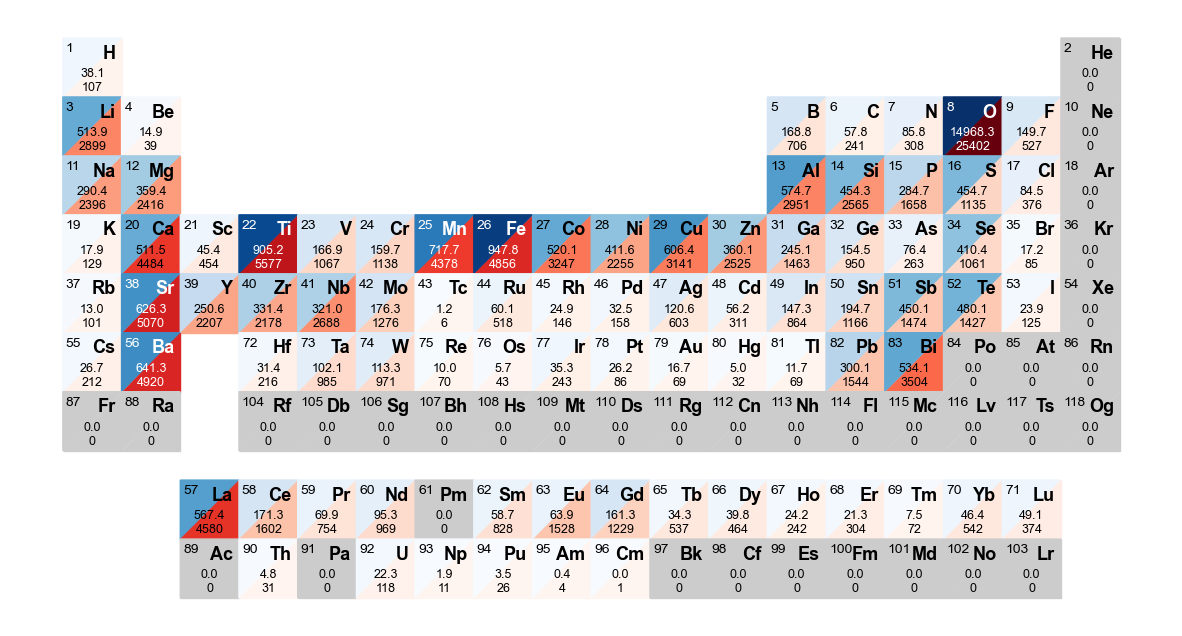

In [489]:
counter = {e:[0, 0] for e in AllElements}
for rxn in unique_reaction:
    for ele, fr in rxn['target_comp'].items():
        counter[ele][0] += fr
        counter[ele][1] += 1

cmap1 = mpl.cm.Blues
cmap1.set_under([0.5,0.5,0.5])
cmap2 = mpl.cm.Reds
cmap2.set_under([0.5,0.5,0.5])

f, ax = plt.subplots(1,1,figsize=(15,8))
cc = {(6,3):0, (7,3):0}
for e, ns in counter.items():
    ele = Element(e)
    x, y = ele.row, ele.group
    key = (x, y)
    if key in cc.keys():
        x += 2.5
        y += cc[key]
        cc[key] += 1
    x = -x
    
#        if z > 6000: color = [1,1,1]
    # if z != 0:
    c0 = ns[0]/1000
    c1 = ns[1]/7000
    if ns[0] > 0:
        ax.fill([y, y+1, y,   y], [x-1, x,   x, x-1], color=cmap1(c0))
    else:
        ax.fill([y, y+1, y,   y], [x-1, x,   x, x-1], color=[0.8, 0.8, 0.8])
    if ns[1] > 0:
        ax.fill([y, y+1, y+1, y], [x-1, x-1, x, x-1], color=cmap2(c1))
    else:
        ax.fill([y, y+1, y+1, y], [x-1, x-1, x, x-1], color=[0.8, 0.8, 0.8])
#        _between([y, y+1], x, x-1, color=cmap(z/9000))
    color = [0,0,0]
    if c0 > 0.7 or c1 > 0.7:
        color = [1,1,1]
    ax.text(y+0.5, x-0.9, f'{ns[0]:.1f}\n{ns[1]:.0f}', fontsize=9, fontfamily='arial', color=color, horizontalalignment='center')
    # else:
    #     ax.fill_between([y, y+1], x, x-1, color=[0.8, 0.8, 0.8])
    #     ax.text(y+0.5, x-0.85, '-')
    ax.text(y+0.05, x-0.24, str(ele.number), fontsize=10, fontfamily='arial', color=color)
    ax.text(y+0.9, x-0.35, e, fontsize=13, fontweight='bold', fontfamily='arial', color=color, horizontalalignment='right')
ax.axis('off')


- Am, Cm, Np 제거

In [490]:
unique_reaction_1 = []
for rxn in unique_reaction:
    if not all(e not in rxn['target_comp'] for e in ['Am','Cm','Np']):
        continue
    _rxn = copy.deepcopy(rxn)
    _rxn['id'] = len(unique_reaction_1)
    unique_reaction_1.append(_rxn)

In [491]:
def get_uniq_prec_info(rxns):
    pstrs1 = []
    pstrs2 = []
    pids = []
    dois = []
    pcomp = []
    pvecs = []
    pcount = []
    for i, rxn in enumerate(rxns):
        for p in rxn['precursor_comp']:
            pstr1 = composit_parser(p)
            comp = Composition(p)
            pstr2, div = comp.get_integer_formula_and_factor()
            pvec = composition_to_feature(p, dtype=float)
            if pstr1 not in pstrs1:
                pstrs1.append(pstr1)
                pstrs2.append(pstr2)
                pids.append([])
                dois.append([])
                pcount.append(0)
                pvecs.append(pvec)
                pcomp.append(p)
            j = pstrs1.index(pstr1)
            pcount[j] += 1
            pids[j].append(i)
            dois[j].extend(rxn['dois'])
    pvecs = np.array(pvecs)
    dois = [np.unique(doi).tolist() for doi in dois]
    ndois = [len(doi) for doi in dois]
    return pstrs1, pstrs2, pids, dois, pcomp, pvecs, pcount, ndois

In [492]:
pstrs1, pstrs2, pids, dois, pcomp, pvecs, pcount, ndois = get_uniq_prec_info(unique_reaction_1)
dmat = np.square((pvecs - pvecs.transpose(1,0,2))).sum(-1)
#for d in dmat:
#    print(sorted(d)[:10])

for i, j in zip(*np.where((dmat > 0) & (dmat < 1e-4))):
    if j < i: continue
    print(dmat[i, j])
    print(i, '\t', pcount[i], '\t', pstrs2[i], '\t', pcomp[i])
    print(j, '\t', pcount[j], '\t', pstrs2[j], '\t', pcomp[j])
    print()

4.5786485281418265e-05
24 	 453 	 Tb4O7 	 {'Tb': 0.36363637, 'O': 0.6363636}
838 	 1 	 Tb7O12 	 {'Tb': 0.36842105, 'O': 0.6315789}

7.50525064319163e-09
76 	 1232 	 Co3O4 	 {'Co': 0.42857143, 'O': 0.5714286}
523 	 3 	 Co1087O1449 	 {'Co': 0.42863268, 'O': 0.5713673}

1.2748701861227125e-06
102 	 728 	 Mn2O3 	 {'Mn': 0.4, 'O': 0.6}
327 	 1 	 Mn200O301 	 {'Mn': 0.39920157, 'O': 0.60079837}

1.8477230629088126e-05
104 	 195 	 Mn3O4 	 {'Mn': 0.42857143, 'O': 0.5714286}
204 	 1 	 Mn20O27 	 {'Mn': 0.4255319, 'O': 0.5744681}

8.38236772927603e-05
520 	 3 	 H21W6N5O21 	 {'H': 0.3962264, 'W': 0.11320755, 'N': 0.094339624, 'O': 0.3962264}
774 	 2 	 H40W12N10O41 	 {'H': 0.3883495, 'W': 0.116504855, 'N': 0.097087376, 'O': 0.39805827}



In [493]:
uniq_rxns = np.array(unique_reaction_1)
rxn_mask = np.ones_like(uniq_rxns, dtype=bool)
rxn_mask[np.hstack([pids[i] for i in np.where(np.array(ndois) < 3)[0]])] = False
uniq_rxns_2 = uniq_rxns[rxn_mask].tolist()

In [820]:
_, _, _, _, _, _, pcount2, ndois2 = get_uniq_prec_info(uniq_rxns_2)

In [821]:
np.unique(pcount2, return_counts=True), np.unique(ndois2, return_counts=True)

((array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
           12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
           23,   24,   25,   26,   27,   28,   29,   30,   31,   33,   34,
           36,   37,   38,   39,   40,   42,   43,   44,   45,   46,   48,
           49,   50,   51,   55,   57,   58,   60,   61,   63,   65,   66,
           67,   68,   69,   72,   73,   75,   76,   77,   78,   79,   83,
           84,   85,   86,   87,   90,   91,   93,   94,   95,   97,   98,
          104,  105,  107,  110,  111,  112,  113,  116,  117,  123,  125,
          126,  129,  131,  134,  137,  138,  139,  144,  150,  153,  156,
          157,  159,  162,  169,  174,  178,  187,  189,  194,  195,  199,
          213,  218,  256,  257,  261,  264,  282,  299,  309,  314,  328,
          335,  339,  341,  346,  347,  362,  375,  376,  378,  382,  397,
          402,  412,  429,  436,  453,  457,  488,  493,  499,  501,  547,
          573,  578,  583

In [822]:
np.sum([1/rxn['count'] for rxn in uniq_rxns_2])

13730.0

In [ ]:
unique_precursor = []
precursor_indexer = {}
for rxn in unique_reaction:
    for pcomp in rxn['precursor_comp']:
        pstr = composit_parser(pcomp)
        if pstr not in precursor_indexer.keys():
            precursor_indexer[pstr] = len(unique_precursor)
            unique_precursor.append({
                'id':None,
                'count':1,
                'count_rxn':1/rxn['count'],
                'years':rxn['years'],
                'precursor_str':pstr,
                'precursor_comp':pcomp,
                'dois':rxn['dois'].copy(),
            })
        else:
            k = precursor_indexer[pstr]
            unique_precursor[k]['count'] += 1
            unique_precursor[k]['count_rxn'] += 1/rxn['count']
            unique_precursor[k]['years'].extend(rxn['years'].copy())
            unique_precursor[k]['dois'].extend(rxn['dois'].copy())
unique_precursor = sorted(unique_precursor, key=lambda x: x['count_rxn'], reverse=True)
for i, prec in enumerate(unique_precursor):
    prec['id'] = i

In [497]:
with gzip.open('../data/unique_reaction.pkl.gz','wb') as f:
    pickle.dump(unique_reaction, f)
with gzip.open('../data/screened_unique_reaction.pkl.gz','wb') as f:
    pickle.dump(uniq_rxns_2, f)
with gzip.open('../data/unique_precursor.pkl.gz','wb') as f:
    pickle.dump(unique_precursor, f)

In [16]:
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    screened_unique_reaction = pickle.load(f)
with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    unique_reaction = pickle.load(f)


In [828]:
np.sum([1/rxn['count'] for rxn in unique_reaction]), np.sum([1/rxn['count'] for rxn in screened_unique_reaction])

(14394.0, 13730.0)

In [30]:
counter_rxn = [0, 0, 0, 0, 0]
counter_prec = {}
for rxn in unique_reaction:
    has_non_metal = 0
    check = False
    pstrs = []
    for p in rxn['precursor_comp']:
        has_metal = False
        for e in p.keys():
            if e in MetalElements:
                has_metal = True
                break
        if has_metal:
            continue
        has_non_metal += 1
        pstrs.append(composit_parser(p))
    counter_rxn[has_non_metal] += 1
    for pstr in pstrs:
        if pstr not in counter_prec.keys():
            counter_prec[pstr] = [0, 0, 0, 0]
        counter_prec[pstr][has_non_metal] += 1
counter_rxn


[28191, 2929, 264, 3, 0]

In [31]:
counter_prec

{'H_0.66667 C_0.33333': [0, 1, 0, 0],
 'H_0.50000 N_0.08333 O_0.33333 P_0.08333': [0, 571, 16, 0],
 'H_0.56250 N_0.12500 O_0.25000 P_0.06250': [0, 261, 3, 0],
 'P_1.00000': [0, 137, 56, 3],
 'S_1.00000': [0, 576, 208, 3],
 'Se_1.00000': [0, 798, 188, 3],
 'O_0.71429 P_0.28571': [0, 143, 1, 0],
 'C_1.00000': [0, 126, 5, 0],
 'H_0.20000 N_0.20000 O_0.60000': [0, 1, 0, 0],
 'H_0.55556 C_0.22222 N_0.11111 S_0.11111': [0, 1, 0, 0],
 'H_0.66667 C_0.22222 O_0.11111': [0, 11, 7, 0],
 'H_0.25000 C_0.25000 O_0.50000': [0, 3, 0, 0],
 'P_0.28571 S_0.71429': [0, 17, 0, 0],
 'H_0.62500 N_0.12500 F_0.25000': [0, 4, 1, 0],
 'H_0.28571 O_0.57143 Se_0.14286': [0, 0, 1, 0],
 'H_0.53333 N_0.13333 O_0.26667 S_0.06667': [0, 13, 2, 0],
 'C_0.25000 N_0.50000 S_0.25000': [0, 1, 0, 0],
 'H_0.37500 O_0.50000 P_0.12500': [0, 81, 2, 0],
 'H_0.66667 N_0.16667 Cl_0.16667': [0, 31, 14, 0],
 'H_0.60000 N_0.15000 O_0.20000 P_0.05000': [0, 9, 0, 0],
 'I_1.00000': [0, 12, 9, 0],
 'H_0.53333 N_0.06667 O_0.33333 P_0.06667'

In [733]:
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)
precursor_source = {p['precursor_str']:[p['count'], p['count_rxn'], len(np.unique(p['dois']))] for p in unique_precursor}

In [839]:
n_source = []
ssur = []
for rxn in unique_reaction:
    eles = {}
    for precursor in rxn['precursor_comp']:
        metal = 'none'
        for ele in precursor.keys():
            if ele in MetalElements:
                metal = ele
        if metal not in eles.keys():
            eles[metal] = 0
        eles[metal] += 1
    n = np.max(list(eles.values()))
    n_source.append(n)
    if n == 1:
        ssur.append(rxn)
print(np.unique(n_source, return_counts=True), len(ssur))

n_source = []
sssur = []
for rxn in screened_unique_reaction:
    eles = {}
    for precursor in rxn['precursor_comp']:
        metal = 'none'
        for ele in precursor.keys():
            if ele in MetalElements:
                metal = ele
        if metal not in eles.keys():
            eles[metal] = 0
        eles[metal] += 1
    n = np.max(list(eles.values()))
    n_source.append(n)
    if n == 1:
        sssur.append(rxn)
print(np.unique(n_source, return_counts=True), len(sssur))

(array([1, 2, 3, 4]), array([30053,  1251,    77,     6])) 30053
(array([1, 2, 3, 4]), array([29335,  1078,    68,     6])) 29335


In [840]:
with gzip.open('../data/unique_reaction_ss.pkl.gz','wb') as f:
    pickle.dump(ssur, f)
with gzip.open('../data/screened_unique_reaction_ss.pkl.gz','wb') as f:
    pickle.dump(sssur, f)

### precursor & screening

In [35]:
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    sur = pickle.load(f)
with gzip.open('../data/screened_unique_reaction_ss.pkl.gz','rb') as f:
    ssur = pickle.load(f)

In [36]:
precursor_count = {}
for rxn in sur:
    for p in rxn['precursor_comp']:
        pstr = composit_parser(p)
        if pstr not in precursor_count.keys():
            precursor_count[pstr] = [0, 0]
        precursor_count[pstr][0] += 1
for rxn in ssur:
    for p in rxn['precursor_comp']:
        pstr = composit_parser(p)
        if pstr not in precursor_count.keys():
            precursor_count[pstr] = [0, 0]
        precursor_count[pstr][1] += 1

In [46]:
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)

precursor_ref = {}
for prec in unique_precursor:
    pstr = prec['precursor_str']
    precursor_ref[pstr] = prec


In [48]:
screened_precursor = []
for pstr in precursor_count.keys():
    if pstr not in precursor_ref.keys():
        print(pstr)
    else:
        screened_precursor.append(precursor_ref[pstr])

In [51]:
with gzip.open('../data/screened_precursor.pkl.gz','wb') as f:
    pickle.dump(screened_precursor, f)

## Screening

### precursors

In [51]:
with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    unique_reaction = pickle.load(f)
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)
with gzip.open('../data/conditional_reaction.pkl.gz','rb') as f:
    conditional_reaction = pickle.load(f)

pstr_idx_mapper = {
    composit_parser(d['precursor_comp']):d['id'] for d in unique_precursor
}

- dilute elements (<0.03)
- low-usage precursors (<5 reactions / <5 targets)
- limited source (<3 papers)

In [52]:
unique_precursor[300]

{'id': 300,
 'count': 17,
 'count_rxn': 15,
 'year': 1998,
 'years': {1998: 1, 2002: 1, 2003: 3, 2004: 1, 2017: 1, 2018: 8},
 'precursor_str': 'S_0.50000 Eu_0.50000',
 'precursor_comp': {'Eu': 0.5, 'S': 0.5},
 'dois': ['10.1016/s0921-4534(98)00065-3',
  '10.1016/s0025-5408(02)00883-8',
  '10.1016/j.jpcs.2005.09.056',
  '10.1021/cm020903m',
  '10.1021/cm020903m',
  '10.1016/j.jssc.2004.04.034',
  '10.1016/j.jlumin.2017.05.065',
  '10.1016/j.jallcom.2020.154424',
  '10.1016/j.jallcom.2018.05.159',
  '10.1016/j.jallcom.2018.05.159',
  '10.1016/j.jallcom.2018.05.159',
  '10.1016/j.jallcom.2018.05.159',
  '10.1016/j.jssc.2018.05.006',
  '10.1016/j.jssc.2018.05.006',
  '10.1016/j.jssc.2018.05.006'],
 'heat_temp': [{'mean': None, 'median': None, 'raw': [1173.15]},
  {'mean': None, 'median': None, 'raw': [523.15, 1273.15, 1323.15]},
  {'mean': None, 'median': None, 'raw': [1228.15]},
  {'mean': None, 'median': None, 'raw': [1228.15, 1313.15]},
  {'mean': None, 'median': None, 'raw': [713.15, 1

In [54]:
k = 0
skip_count = [0, 0, 0, 0]
screened_precursor = []
for p in sorted(unique_precursor, key=lambda x: x['count_rxn'], reverse=True):
    skip = False
    if np.max([Element(e).number for e in p['precursor_comp'].keys()]) > 94:
        continue
    if p['count'] < 5:
        skip = True
        skip_count[0] += 1
    if p['count_rxn'] < 5:
        skip = True
        skip_count[1] += 1
    if len(np.unique(p['dois'])) < 3:
        skip = True
        skip_count[2] += 1
    if np.sum([f < 0.03 for f in p['precursor_comp'].values()]) > 0:
        skip = True
        skip_count[3] += 1
    if skip:
        continue
    if len(p['dois']) > 2:
        print('{:4d} {:5d} {:5d} {:5d} {:5d} {}'.format(k, p['id'], p['count'], p['count_rxn'], len(p['dois']), p['precursor_comp']))
    else:
        print('{:4d} {:5d} {:5d} {:5d} {:5d} {} {}'.format(k, p['id'], p['count'], p['count_rxn'], len(p['dois']), p['precursor_comp'], p['dois']))
    screened_precursor.append({
        'id': p['id'],
        'count': p['count'],
        'count_rxn': p['count_rxn'],
        'year': p['year'],
        'precursor_str': p['precursor_str'],
        'precursor_comp': p['precursor_comp'],
        'years':p['years'],
        'dois':p['dois'],
        'heat_temp':p['heat_temp'],
        'heat_time':p['heat_time'],
    })
    k += 1
print('# of precursors : {} -> {}'.format(len(unique_precursor), len(screened_precursor)))

   0     0  8339  4850  4899 {'Ti': 0.33333334, 'O': 0.6666667}
   1     1  6677  4453  4470 {'Sr': 0.2, 'C': 0.2, 'O': 0.6}
   2     2  6654  4297  4398 {'Ba': 0.2, 'C': 0.2, 'O': 0.6}
   3     3  5942  4180  4180 {'La': 0.4, 'O': 0.6}
   4     4  5286  3774  3774 {'Ca': 0.2, 'C': 0.2, 'O': 0.6}
   5     5  5657  3684  3785 {'Fe': 0.4, 'O': 0.6}
   6     6  4449  2914  2914 {'Bi': 0.4, 'O': 0.6}
   7     7  3803  2477  2477 {'Nb': 0.2857143, 'O': 0.71428573}
   8     8  2972  2062  2094 {'Zn': 0.5, 'O': 0.5}
   9     9  2948  2039  2039 {'Y': 0.4, 'O': 0.6}
  10    10  2932  2027  2027 {'Si': 0.33333334, 'O': 0.6666667}
  11    11  3228  1886  1894 {'Li': 0.33333334, 'C': 0.16666667, 'O': 0.5}
  12    12  2803  1843  1951 {'Al': 0.4, 'O': 0.6}
  13    13  2519  1757  1757 {'Na': 0.33333334, 'C': 0.16666667, 'O': 0.5}
  14    14  2515  1696  1698 {'Cu': 0.5, 'O': 0.5}
  15    15  2246  1613  1613 {'Mn': 0.33333334, 'O': 0.6666667}
  16    16  2590  1558  1558 {'Zr': 0.33333334, 'O': 0.

In [40]:
for d in raw_data:
    if d['doi'] == '10.1039/c6ta03122f':
        print(d)

{'id': 2317, 'raw_index': 1592, 'synthesis_type': 'solid_state_ceramic_synthesis', 'doi': '10.1039/c6ta03122f', 'year': 2016, 'prototype_path': ['AllMaterials/chalcogenides/binary/Others/Misc/Ti0.02W1S2/Ti0.02W1S2'], 'count_weight': 0.2, 'target_comp': {'Ti': 0.0066225166, 'W': 0.33112583, 'S': 0.66225165}, 'precursor_comp': [{'Ti': 1.0}, {'W': 0.33333334, 'S': 0.6666667}], 'operations': [{'type': 'MixingOperation', 'string': 'ground', 'attributes': {'temperature': [], 'time': [{'min': 1.5, 'max': 1.5, 'values': [1.5], 'unit': 'h'}], 'env': []}}, {'type': 'HeatingOperation', 'string': 'sintered', 'attributes': {'temperature': [], 'time': [], 'env': []}}, {'type': 'QuenchingOperation', 'string': 'cooled', 'attributes': {'temperature': [{'min': 298.15, 'max': 298.15, 'values': [298.15], 'unit': 'K'}], 'time': [], 'env': []}}]}
{'id': 2318, 'raw_index': 1592, 'synthesis_type': 'solid_state_ceramic_synthesis', 'doi': '10.1039/c6ta03122f', 'year': 2016, 'prototype_path': ['AllMaterials/chal

In [55]:
screened_precursor[431]

{'id': 456,
 'count': 5,
 'count_rxn': 5,
 'year': 2004,
 'precursor_str': 'H_0.40000 C_0.26667 O_0.26667 Cd_0.06667',
 'precursor_comp': {'Cd': 0.06666667,
  'H': 0.4,
  'C': 0.26666668,
  'O': 0.26666668},
 'years': {2004: 1, 2008: 1, 2018: 3},
 'dois': ['10.1039/c3tc31995d',
  '10.1016/j.materresbull.2008.08.016',
  '10.1016/j.ceramint.2017.12.059',
  '10.1016/j.ceramint.2017.12.059',
  '10.1016/j.ceramint.2017.12.059'],
 'heat_temp': [{'mean': None, 'median': None, 'raw': [1223.15]},
  {'mean': None, 'median': None, 'raw': [973.15]},
  {'mean': None, 'median': None, 'raw': [1223.15]},
  {'mean': None, 'median': None, 'raw': [1223.15]},
  {'mean': None, 'median': None, 'raw': [1223.15]}],
 'heat_time': [{'mean': None, 'median': None, 'raw': []},
  {'mean': None, 'median': None, 'raw': [10.0]},
  {'mean': None, 'median': None, 'raw': [8.0]},
  {'mean': None, 'median': None, 'raw': [8.0]},
  {'mean': None, 'median': None, 'raw': [8.0]}]}

In [42]:
ptable = np.zeros(120)
for p in screened_precursor:
    for ele in p['precursor_comp'].keys():
        ptable[Element(ele).number] += p['count']
for ele in sorted(AllElements, key=lambda x: Element(x).number):
    i = Element(ele).number
    print(f'{i:3d} - {ele:3s} : {ptable[i]:.0f}')

  1 - H   : 4343
  2 - He  : 0
  3 - Li  : 4838
  4 - Be  : 50
  5 - B   : 767
  6 - C   : 27830
  7 - N   : 3620
  8 - O   : 114868
  9 - F   : 899
 10 - Ne  : 0
 11 - Na  : 3319
 12 - Mg  : 3405
 13 - Al  : 4228
 14 - Si  : 3773
 15 - P   : 2069
 16 - S   : 1991
 17 - Cl  : 464
 18 - Ar  : 0
 19 - K   : 129
 20 - Ca  : 6343
 21 - Sc  : 565
 22 - Ti  : 9285
 23 - V   : 1462
 24 - Cr  : 1391
 25 - Mn  : 5721
 26 - Fe  : 7080
 27 - Co  : 4300
 28 - Ni  : 2931
 29 - Cu  : 4339
 30 - Zn  : 3500
 31 - Ga  : 1976
 32 - Ge  : 1134
 33 - As  : 330
 34 - Se  : 1399
 35 - Br  : 72
 36 - Kr  : 0
 37 - Rb  : 117
 38 - Sr  : 7497
 39 - Y   : 3118
 40 - Zr  : 3316
 41 - Nb  : 4037
 42 - Mo  : 1681
 43 - Tc  : 0
 44 - Ru  : 676
 45 - Rh  : 155
 46 - Pd  : 178
 47 - Ag  : 779
 48 - Cd  : 367
 49 - In  : 1105
 50 - Sn  : 1550
 51 - Sb  : 1777
 52 - Te  : 1843
 53 - I   : 135
 54 - Xe  : 0
 55 - Cs  : 237
 56 - Ba  : 7443
 57 - La  : 6408
 58 - Ce  : 2014
 59 - Pr  : 887
 60 - Nd  : 1199
 61 - Pm  : 0


In [56]:
with gzip.open('../data/screened_precursor.pkl.gz','wb') as f:
    pickle.dump(screened_precursor, f)

- analysis - source

In [57]:
for i, p in enumerate(unique_precursor):
    if (p['count_rxn'] > 5) and (len(p['dois']) < 7):
        print('{:4d} {:5d} {:5d} {:5d} - {}'.format(i, p['count'], p['count_rxn'], len(p['dois']), p['precursor_comp']))
        for doi in p['dois']:
            print(f'\t{doi}')

 411     6     6     6 - {'Sn': 0.14285715, 'C': 0.2857143, 'O': 0.5714286}
	10.1016/j.electacta.2019.05.069
	10.1039/c3dt33079f
	10.1016/j.electacta.2019.05.069
	10.1039/c3dt33079f
	10.1039/c3dt33079f
	10.1039/c3dt33079f
 412     6     6     6 - {'Ni': 0.045454547, 'H': 0.4090909, 'C': 0.27272728, 'O': 0.27272728}
	10.1016/j.matlet.2008.01.133
	10.1016/s0038-1098(02)00800-1
	10.1016/j.jpowsour.2006.10.025
	10.1016/j.matlet.2008.01.133
	10.1007/s10854-012-0776-8
	10.1016/j.ssi.2013.07.024
 413     6     6     6 - {'Mg': 0.2, 'H': 0.2, 'C': 0.1, 'O': 0.5}
	10.1111/j.1551-2916.2007.01533.x
	10.1111/j.1551-2916.2006.00938.x
	10.1016/j.powtec.2010.08.011
	10.1111/j.1551-2916.2007.01533.x
	10.1063/1.4755790
	10.1016/j.cej.2014.05.123
 414     6     6     6 - {'Ti': 0.5, 'O': 0.5}
	10.1016/j.elspec.2008.04.001
	10.1063/1.4858383
	10.1063/1.4858383
	10.1063/1.4858383
	10.1063/1.4858383
	10.1063/1.4858383
 415     6     6     6 - {'Ti': 0.11111111, 'H': 0.44444445, 'O': 0.44444445}
	10.1016/j.

{'id': 10516, 'count': 1, 'year': 2008, 'target_comp': {'Na': 0.02075, 'Li': 0.22925, 'H': 0.5, 'N': 0.25}, 'precursor_comp': [{'Li': 0.25, 'H': 0.5, 'N': 0.25}, {'Na': 0.25, 'H': 0.5, 'N': 0.25}], 'dois': ['10.1039/b719673n'], 'years': [2008], 'heat_temp': [{'mean': None, 'median': None, 'raw': []}], 'heat_time': [{'mean': None, 'median': None, 'raw': []}]}
{'id': 10517, 'count': 1, 'year': 2008, 'target_comp': {'Na': 0.04175, 'Li': 0.20825, 'H': 0.5, 'N': 0.25}, 'precursor_comp': [{'Li': 0.25, 'H': 0.5, 'N': 0.25}, {'Na': 0.25, 'H': 0.5, 'N': 0.25}], 'dois': ['10.1039/b719673n'], 'years': [2008], 'heat_temp': [{'mean': None, 'median': None, 'raw': []}], 'heat_time': [{'mean': None, 'median': None, 'raw': []}]}
{'id': 10518, 'count': 2, 'year': 2008, 'target_comp': {'Na': 0.0625, 'Li': 0.1875, 'H': 0.5, 'N': 0.25}, 'precursor_comp': [{'Li': 0.25, 'H': 0.5, 'N': 0.25}, {'Na': 0.25, 'H': 0.5, 'N': 0.25}], 'dois': ['10.1039/b719673n', '10.1021/acs.jpcc.6b10611'], 'years': [2008, 2016], '

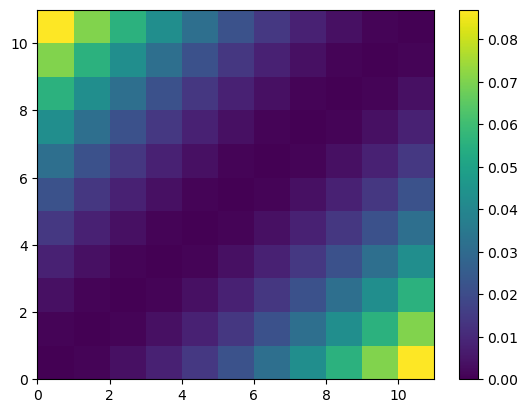

In [58]:
vec = []
for rxn in unique_reaction:
    if '10.1039/b719673n' in rxn['dois']:
        print(rxn)
        vec.append(active_composit_feature(rxn['target_comp']))
#unique_precursor_data[416]
c = plt.pcolormesh(np.square(np.vstack(vec)[..., np.newaxis] - np.vstack(vec).T[np.newaxis, ...]).sum(1))
plt.colorbar(c)
# single source -> difference in doping concentration, same target material 

- Low-concentration elements

일부 프리커서는 metal organic precursor로 정확하게 parsing 되었지만, 잘못 parsing 된 경우나 이상한 경우가 많았음

In [59]:
from src.feature import composition_to_feature

prec_comp_vecs = np.vstack([
    composition_to_feature(d['precursor_comp'], 'comp_ext') for d in unique_precursor
])
freq = check_precursor_frequency(unique_reaction)

for prec_info in freq:
    print_info = False
    for e, f in prec_info['precursor_comp'].items():
        if f < 0.03:
            print_info = True
            break
    if print_info:
        pvec = composition_to_feature(prec_info['precursor_comp'], 'comp_ext')
        idxs = np.argsort(np.square(prec_comp_vecs - pvec).sum(1))
        i = pstr_idx_mapper[composit_parser(prec_info['precursor_comp'])]
        print('* {:4d} {:4d} {:4d} {:4d} - {}'.format(unique_precursor[i]['id'], unique_precursor[i]['count'], unique_precursor[i]['count_rxn'], len(unique_precursor[i]['dois']), unique_precursor[i]['precursor_comp']))
        for j in idxs[1:3]:
            print('  {:4d} {:4d} {:4d} {:4d} - {}'.format(unique_precursor[j]['id'], unique_precursor[j]['count'], unique_precursor[j]['count_rxn'], len(unique_precursor[i]['dois']), unique_precursor[j]['precursor_comp']))
        for doi in unique_precursor[i]['dois']:
            print(f'\thttps://doi.org/{doi}')

*  336   11   11   11 - {'Mn': 0.02, 'H': 0.42, 'C': 0.28, 'O': 0.28}
   768    1    1   11 - {'Mn': 0.045454547, 'H': 0.4090909, 'C': 0.27272728, 'O': 0.27272728}
   849    1    1   11 - {'Ce': 0.03448276, 'H': 0.41379312, 'C': 0.27586207, 'O': 0.27586207}
	https://doi.org/10.1039/b000826p
	https://doi.org/10.1016/j.jpcs.2018.09.021
	https://doi.org/10.1016/j.jpcs.2018.09.021
	https://doi.org/10.1016/j.jpcs.2018.09.021
	https://doi.org/10.1016/j.jpcs.2018.09.021
	https://doi.org/10.1016/j.jpcs.2018.09.021
	https://doi.org/10.1016/j.jpcs.2018.09.021
	https://doi.org/10.1016/j.jpcs.2018.09.021
	https://doi.org/10.1016/j.jpcs.2018.09.021
	https://doi.org/10.1016/j.jpcs.2018.09.021
	https://doi.org/10.1016/j.jpcs.2018.09.021
*  398    7    7    7 - {'Ti': 0.01754386, 'H': 0.6315789, 'C': 0.28070176, 'O': 0.07017544}
   912    1    1    7 - {'Zr': 0.01754386, 'H': 0.6315789, 'C': 0.28070176, 'O': 0.07017544}
   891    1    1    7 - {'Y': 0.029411765, 'H': 0.61764705, 'C': 0.2647059, 'O': 0

In [12]:
# https://doi.org/10.1016/j.jpowsour.2010.03.100
#Ce (NH4)2 (NO3)6 <- metal organic precursors, 정확히 됨
np.array([1, 8, 8, 18]) / 35

array([0.02857143, 0.22857143, 0.22857143, 0.51428571])

In [41]:
#Si(OC2H5)4 / 정상 프리커서
np.array([1,20,8,4])/33

array([0.03030303, 0.60606061, 0.24242424, 0.12121212])

In [54]:
# https://doi.org/10.1016/j.jfluchem.2006.11.002
# https://doi.org/10.1039/b000826p
# same maganese acetate but different precursor compositions
#(CH3COO)2 Mn -> acetate : H3 C2 O2 / acetate가 붙는 비율이 이상함. 
print(np.array([1,6,4,4 ])/15) # 2개
print(np.array([0.02, 0.42, 0.28, 0.28]) / 0.02) # 7개
print(np.array([0.018181818, 0.47272727, 0.21818182, 0.2909090]) / 0.01818181818)
print(np.array([ 0.045454547, 0.4090909, 0.27272728, 0.27272728]) / 0.045454547)

[0.06666667 0.4        0.26666667 0.26666667]
[ 1. 21. 14. 14.]
[ 0.99999999 25.99999985 12.0000001  15.999995  ]
[1.         8.99999949 5.99999996 5.99999996]


In [25]:
# https://doi.org/10.1039/c3cy00121k

print(np.array([1, 15, 12, 46]))
print(np.array([0.017857144, 0.05357143, 0.21428572, 0.71428573]) / 0.017857144)

[ 1 15 12 46]
[ 1.          2.99999989 11.99999955 39.99999832]


In [26]:
# https://doi.org/10.1063/1.4864138
# failed parsing - KOH
np.array([0.4950495, 0.00990099, 0.4950495])/0.00990099


array([50.,  1., 50.])

In [27]:
# https://doi.org/10.1016/j.ssc.2012.01.019
# failed parsing
print(np.array([0.009259259, 0.018518519, 0.24074075, 0.7314815]) / 0.009259259)
print(np.array([1, 12, 2, 12]) / 27)

[ 1.          2.00000011 26.00000173 79.00000421]
[0.03703704 0.44444444 0.07407407 0.44444444]


- prototype path도 오류가 많음. 같은 물질을 다른 path에 할당

In [18]:
target_comp = {'Fe': 0.2857143, 'Ni': 0.14285715, 'O': 0.5714286}
target_vec = active_composit_feature(target_comp)
pvecs = np.zeros_like(target_vec).reshape(1,-1)
data_collection = []
for i, data in enumerate(raw_data):
    vec = active_composit_feature(data['target_comp'])
    if np.abs(target_vec - vec).sum() < 5e-5:
        data_collection.append(data)
        
dump_0 = []
for d in data_collection:
    pvec = np.sum([active_composit_feature(p) for p in d['precursor_comp']], 0)
    dist = np.abs(pvecs - pvec).sum(1)
    is_unique = np.sum(dist < 5e-5) == 0
    if is_unique:
        pvecs = np.vstack([pvecs, pvec])
        dump_0.append({'comp':d['precursor_comp'], 'path':[d['prototype_path']]})
    else:
        dump_0[np.argmin(dist) - 1]['path'].append(d['prototype_path'])
        
for d in dump_0:
    print(d['comp'])
    for p in d['path']:
        print(p)

[{'Ni': 0.4, 'O': 0.6}, {'Fe': 0.4, 'O': 0.6}]
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
[{'Ni': 1.0}, {'Fe': 0.4, 'O': 0.6}]
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
[{'Fe': 0.4, 'O': 0.6}, {'Ni': 0.5, 'O': 0.5}]
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/oxides/ternary/Others/Misc/Fe1.5Ni0.75O3/Fe1.5Ni0.75O3']
['AllMaterials/oxides/ternary/AB2O4/Fe2NiO4/NoDoping/Fe2NiO4/Fe2NiO4']
['AllMaterials/o

### Reactions

In [2]:
with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    unique_reaction = pickle.load(f)
with gzip.open('../data/conditional_reaction.pkl.gz','rb') as f:
    conditional_reaction = pickle.load(f)
with gzip.open('../data/screened_precursor.pkl.gz','rb') as f:
    screened_precursor = pickle.load(f)

NameError: name 'gzip' is not defined

- minimum usage of precursor is set to 5

In [61]:
minimum_frequency = 5
screened_unique_reaction, x = screening_reactions_by_freq(unique_reaction, screened_precursor, minimum_frequency=5)
print(f'# of reactions: {len(unique_reaction)} -> {len(screened_unique_reaction)}')
print(f'# of precursors: {len(screened_precursor)} -> {len(x)}')

with gzip.open(f'../data/screened_unique_reaction.pkl.gz','wb') as f:
    pickle.dump(screened_unique_reaction, f)

1 1 30269 442
3 3 30195 417
4 4 30181 413
5 5 30177 412
# of reactions: 31387 -> 30177
# of precursors: 443 -> 412


In [62]:
freq = check_precursor_frequency(screened_unique_reaction)
for k in freq:
    print(k)

{'count_rxn': 4790, 'count': 8277, 'precursor_comp': {'Ti': 0.33333334, 'O': 0.6666667}, 'precursor_str': 'O_0.66667 Ti_0.33333'}
{'count_rxn': 4364, 'count': 6587, 'precursor_comp': {'Sr': 0.2, 'C': 0.2, 'O': 0.6}, 'precursor_str': 'C_0.20000 O_0.60000 Sr_0.20000'}
{'count_rxn': 4212, 'count': 6568, 'precursor_comp': {'Ba': 0.2, 'C': 0.2, 'O': 0.6}, 'precursor_str': 'C_0.20000 O_0.60000 Ba_0.20000'}
{'count_rxn': 4111, 'count': 5870, 'precursor_comp': {'La': 0.4, 'O': 0.6}, 'precursor_str': 'O_0.60000 La_0.40000'}
{'count_rxn': 3733, 'count': 5241, 'precursor_comp': {'Ca': 0.2, 'C': 0.2, 'O': 0.6}, 'precursor_str': 'C_0.20000 O_0.60000 Ca_0.20000'}
{'count_rxn': 3634, 'count': 5607, 'precursor_comp': {'Fe': 0.4, 'O': 0.6}, 'precursor_str': 'O_0.60000 Fe_0.40000'}
{'count_rxn': 2881, 'count': 4414, 'precursor_comp': {'Bi': 0.4, 'O': 0.6}, 'precursor_str': 'O_0.60000 Bi_0.40000'}
{'count_rxn': 2434, 'count': 3759, 'precursor_comp': {'Nb': 0.2857143, 'O': 0.71428573}, 'precursor_str': 'O

In [63]:
counter = {}
idex_pairs = {}
for rxn in conditional_reaction:
    k = tuple([rxn['doi'], composit_parser(rxn['target_comp']), composit_parser(rxn['precursor_comp'])])
    if k not in counter.keys():
        counter[k] = 0
    counter[k] += 1
counter = {k:v for k,v in sorted(counter.items(), key=lambda x: x[1], reverse=True)}
for rxn in conditional_reaction:
    k = tuple([rxn['doi'], composit_parser(rxn['target_comp']), composit_parser(rxn['precursor_comp'])])
    if counter[k] > 1:
        print(rxn)

In [64]:
times = []
temps = []
for i, rxn in enumerate(conditional_reaction):
    if len(rxn['heat_time']['raw']) != 0:
        times.append([i, rxn['heat_time']['median'], rxn['heat_time']['mean']])
    if len(rxn['heat_temp']['raw']) != 0:
        temps.append([i, rxn['heat_temp']['median'], rxn['heat_temp']['mean']])
times = np.array(times)
temps = np.array(temps)

In [65]:
times[(times[:, 1] < 0.1)]

array([[2.40000000e+02, 8.33333333e-02, 8.33333333e-02],
       [2.75000000e+02, 1.66666667e-02, 1.66666667e-02],
       [5.75000000e+02, 8.33333333e-02, 8.33333333e-02],
       [5.76000000e+02, 8.33333333e-02, 8.33333333e-02],
       [2.14800000e+03, 8.33333333e-02, 7.11111111e-01],
       [2.15600000e+03, 5.00000000e-02, 5.00000000e-02],
       [2.45800000e+03, 8.33333333e-02, 8.33333333e-02],
       [2.45900000e+03, 8.33333333e-02, 8.33333333e-02],
       [2.69200000e+03, 8.33333333e-02, 8.33333333e-02],
       [4.36100000e+03, 3.33333333e-02, 3.33333333e-02],
       [5.21700000e+03, 8.33333333e-02, 8.33333333e-02],
       [5.67700000e+03, 8.33333333e-02, 8.33333333e-02],
       [6.61600000e+03, 3.33333333e-02, 3.33333333e-02],
       [7.50300000e+03, 3.33333333e-02, 3.33333333e-02],
       [7.68100000e+03, 8.33333333e-02, 8.33333333e-02],
       [8.01200000e+03, 3.33333333e-02, 3.33333333e-02],
       [8.02100000e+03, 8.33333333e-02, 8.33333333e-02],
       [8.47300000e+03, 8.33333

In [66]:
conditional_reaction[240]

{'id': 240,
 'id_urxn': 42,
 'doi': '10.1016/j.jmatprotec.2008.02.003',
 'year': 1998,
 'year_doc': 2009,
 'count': 27,
 'target_comp': {'Mg': 0.0666, 'Nb': 0.1334, 'Pb': 0.2, 'O': 0.6},
 'precursor_comp': [{'Nb': 0.2857143, 'O': 0.71428573},
  {'Mg': 0.5, 'O': 0.5},
  {'Pb': 0.5, 'O': 0.5}],
 'heat_temp': {'mean': 856.4833333333332,
  'median': 873.15,
  'raw': [673.15, 873.15, 1023.15]},
 'heat_time': {'mean': 0.08333333333333333,
  'median': 0.08333333333333333,
  'raw': [0.08333333333333333]}}

In [67]:
screened_conditional_reaction, x = screening_reactions_by_freq(conditional_reaction, screened_precursor, minimum_frequency=minimum_frequency)
print(f'# of reactions: {len(conditional_reaction)} -> {len(screened_conditional_reaction)}')
print(f'# of precursors: {len(screened_precursor)} -> {len(x)}')

with gzip.open(f'../data/screened_conditional_reaction.pkl.gz','wb') as f:
    pickle.dump(screened_conditional_reaction, f)

1 1 36565 440
4 4 36411 383
4 4 36395 379
5 5 36391 378
# of reactions: 37457 -> 36391
# of precursors: 443 -> 378


In [68]:
conditional_reaction[110], screened_conditional_reaction[110]

({'id': 110,
  'id_urxn': 11,
  'doi': '10.1021/jp408762v',
  'year': 1988,
  'year_doc': 2013,
  'count': 24,
  'target_comp': {'Zn': 0.14285715, 'Fe': 0.2857143, 'O': 0.5714286},
  'precursor_comp': [{'Fe': 0.4, 'O': 0.6}, {'Zn': 0.5, 'O': 0.5}],
  'heat_temp': {'mean': 1273.15, 'median': 1273.15, 'raw': [1273.15]},
  'heat_time': {'mean': 3.0, 'median': 3.0, 'raw': [3.0]}},
 {'id': 112,
  'id_urxn': 11,
  'doi': '10.1016/j.jmmm.2013.09.025',
  'year': 1988,
  'year_doc': 2014,
  'count': 24,
  'target_comp': {'Zn': 0.14285715, 'Fe': 0.2857143, 'O': 0.5714286},
  'precursor_comp': [{'Fe': 0.4, 'O': 0.6}, {'Zn': 0.5, 'O': 0.5}],
  'heat_temp': {'mean': 1398.0,
   'median': 1423.0,
   'raw': [1173.0, 1373.0, 1473.0, 1573.0]},
  'heat_time': {'mean': 12.0, 'median': 12.0, 'raw': [12.0]}})

# Screened dataset

## multisource

In [3]:
with gzip.open('../data/screened_precursor.pkl.gz','rb') as f:
    screened_precursor = pickle.load(f)
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    screened_unique_reaction = pickle.load(f)
with gzip.open('../data/screened_conditional_reaction.pkl.gz','rb') as f:
    screened_conditional_reaction = pickle.load(f)

In [4]:
pstr_to_id = {p['precursor_str']:(i,p['id']) for i,p in enumerate(screened_precursor)}
for rxn in screened_unique_reaction[:5]:
    for p in rxn['precursor_comp']:
        pstr = composit_parser(p)
        print(pstr_to_id[pstr])
    print()


(9, 9)
(10, 10)
(81, 81)
(117, 117)

(9, 9)
(10, 10)
(81, 81)
(117, 117)

(16, 16)
(36, 36)

(9, 9)
(10, 10)
(13, 13)

(2, 2)
(5, 5)



In [89]:
for pfx, data in zip(['c','u'],[screened_conditional_reaction, screened_unique_reaction]):
    i = np.arange(len(data))
    np.random.shuffle(i)
    part = np.array(data)[i[:200]].tolist()
    with gzip.open(f'../data/s{pfx}rxn.pkl.gz','wb') as f:
        pickle.dump(part, f)

#### TODO: Weight calculation / same doi / precursor pair

In [55]:
years = np.array([d['year_doc'] for d in screened_conditional_reaction])
weights = np.array([1.0/d['count'] for d in screened_conditional_reaction])
has_temp = np.array([d['heat_temp']['mean'] is not None for d in screened_conditional_reaction])
has_time = np.array([d['heat_time']['mean'] is not None for d in screened_conditional_reaction])

x = sorted(np.unique(years))
ys_temp = []
ys_time = []
ys_both = []
for year in x:
    m = years == year
    m_temp = has_temp & m
    m_time = has_time & m
    m_both = m_time & m_temp
    ys_temp.append([weights[m_temp].sum(), m_temp.sum()])
    ys_time.append([weights[m_time].sum(), m_time.sum()])
    ys_both.append([weights[m_both].sum(), m_both.sum()])


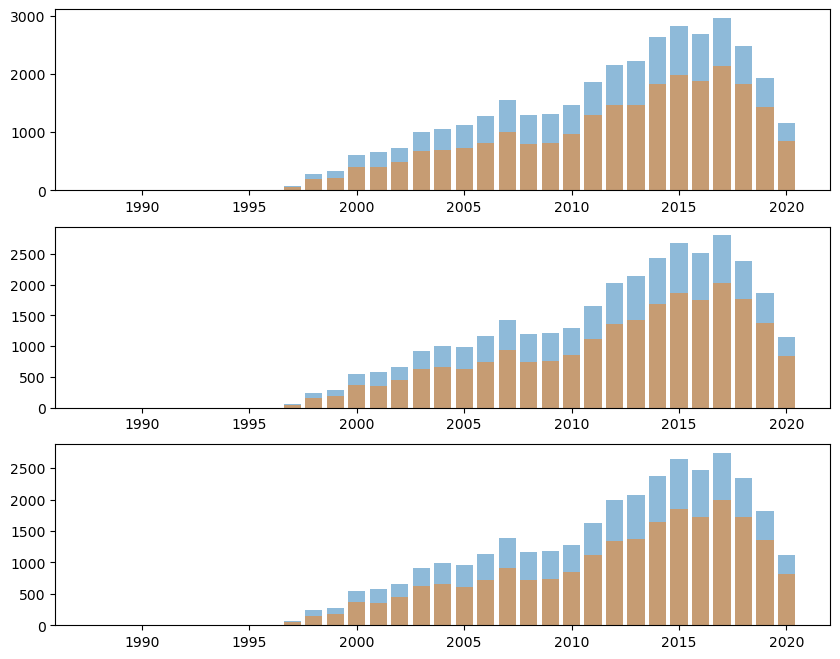

In [31]:
f, axs = plt.subplots(3,1,figsize=(10,8))
for ax, ys in zip(axs, [ys_temp, ys_time, ys_both]):
    w, c = np.array(ys).T
    ax.bar(x, c, alpha=0.5)
    ax.bar(x, w, alpha=0.5)

In [54]:
y1, y2 = 2016, 2018
m1 = years < y1
m2 = (years >= y1) & (years < y2)
m3 = years >= y2
d_w = weights.sum()
d_v = weights.shape[0]
for my, (y_s, y_e) in zip([m1, m2, m3], [('',y1),(y1,y2),(y2,'')]):
    s = f'{str(y_s):4s} ~ {str(y_e):4s} : '
    for m in [has_temp & my, has_time & my, has_temp & has_time & my]:
        v_w = weights[m].sum()
        v_s = m.sum()
        s += f'{v_w:9.2f} ({v_w/d_w:.3f}) - {v_s:5d} ({v_s/d_v:.3f}) |  '
    print(s)
s = 'excluded    : '
for m in [has_temp, has_time, has_temp & has_time]:
    v_w = weights[~m].sum()
    v_s = (~m).sum()
    s += f'{v_w:9.2f} ({v_w/d_w:.3f}) - {v_s:5d} ({v_s/d_v:.3f}) |  '
print(s)


     ~ 2016 :  16318.25 (0.655) - 24508 (0.673) |   14991.24 (0.602) - 22537 (0.619) |   14690.57 (0.590) - 22097 (0.607) |  
2016 ~ 2018 :   4025.34 (0.162) -  5656 (0.155) |    3775.45 (0.152) -  5308 (0.146) |    3709.60 (0.149) -  5218 (0.143) |  
2018 ~      :   4106.31 (0.165) -  5565 (0.153) |    3981.40 (0.160) -  5400 (0.148) |    3890.82 (0.156) -  5268 (0.145) |  
excluded    :    457.10 (0.018) -   662 (0.018) |    2158.91 (0.087) -  3146 (0.086) |    2616.01 (0.105) -  3808 (0.105) |  


In [58]:
((years >= 2016) & years < 2018).sum(), years.shape


(36391, (36391,))

In [54]:
years = np.array([d['year'] for d in screened_unique_reaction])
y1, y2 = 2016, 2018
m1 = years < y1
m2 = (years >= y1) & (years < y2)
m3 = years >= y2
d_v = years.shape[0]
for m, (y_s, y_e) in zip([m1, m2, m3], [('',y1),(y1,y2),(y2,'')]):
    s = f'{str(y_s):4s} ~ {str(y_e):4s} : '
    v_s = m.sum()
    s += f'{v_s:5d} ({v_s/d_v:.3f}) '
    print(s)

     ~ 2016 : 20888 (0.692) 
2016 ~ 2018 :  4634 (0.154) 
2018 ~      :  4655 (0.154) 


In [77]:
screened_precursor[442]

{'id': 480,
 'count': 5,
 'count_rxn': 5,
 'year': 2016,
 'precursor_str': 'Cl_0.75000 Bi_0.25000',
 'precursor_comp': {'Bi': 0.25, 'Cl': 0.75},
 'years': {2016: 2, 2018: 3},
 'dois': ['10.1016/j.optmat.2016.05.057',
  '10.1021/acs.cgd.5b01802',
  '10.1007/s12598-018-1027-9',
  '10.1007/s12598-018-1027-9',
  '10.1007/s12598-018-1027-9'],
 'heat_temp': [{'mean': None, 'median': None, 'raw': []},
  {'mean': None, 'median': None, 'raw': []},
  {'mean': None, 'median': None, 'raw': [873.15]},
  {'mean': None, 'median': None, 'raw': [873.15]},
  {'mean': None, 'median': None, 'raw': [873.15]}],
 'heat_time': [{'mean': None, 'median': None, 'raw': []},
  {'mean': None, 'median': None, 'raw': []},
  {'mean': None, 'median': None, 'raw': [10.0, 168.0]},
  {'mean': None, 'median': None, 'raw': [10.0, 168.0]},
  {'mean': None, 'median': None, 'raw': [10.0, 168.0]}]}

In [15]:
targets = {}
for rxn in screened_unique_reaction:
    target_comp = rxn['target_comp']
    tstr = composit_parser({e:1 for e in target_comp.keys()})
    if tstr not in targets.keys():
        targets[tstr] = {}
    nprec = len(rxn['precursor_comp'])
    if nprec not in targets[tstr].keys():
        targets[tstr][nprec] = 0
    targets[tstr][nprec] += 1
np.unique(np.hstack([list(v.keys()) for v in targets.values()]))

array([2, 3, 4, 5])

## Single source only

### unique rxns

In [56]:
counter = {i:0 for i in range(6)}
_sssur = []
for rxn in screened_unique_reaction:
    metals = {'none':0}
    for precursor_comps in rxn['precursor_comp']:
        has_metal = False
        for ele in precursor_comps.keys():
            if ele not in MetalElements:
                continue
            if ele not in metals.keys():
                metals[ele] = 0
            has_metal = True
            metals[ele] += 1
        if not has_metal:
            metals['none'] += 1
    n = int(np.max(list(metals.values())))
    counter[n] += 1
    if n == 1:
        _sssur.append(copy.deepcopy(rxn))

counter

{0: 0, 1: 29072, 2: 1033, 3: 66, 4: 6, 5: 0}

In [57]:
sssurprec = {}
for rxn in _sssur:
    for precursor_comp in rxn['precursor_comp']:
        pstr = composit_parser(precursor_comp)
        if pstr not in sssurprec.keys():
            sssurprec[pstr] = 0
        sssurprec[pstr] += 1
_prec = {k:v for k,v in sorted(sssurprec.items(), key=lambda x: x[1], reverse=True) if v > 4}

screened_single_source_unique_reaction = []
for rxn in _sssur:
    skip = False
    for precursor_comp in rxn['precursor_comp']:
        pstr = composit_parser(precursor_comp)
        if pstr not in _prec.keys():
            skip = True
            break
    if skip:
        continue
    screened_single_source_unique_reaction.append(copy.deepcopy(rxn))
len(screened_single_source_unique_reaction)

29009

In [58]:
with gzip.open('../data/screened_single_source_unique_reaction.pkl.gz','wb') as f:
    pickle.dump(screened_single_source_unique_reaction, f, protocol=pickle.HIGHEST_PROTOCOL)

- test

In [59]:
with gzip.open('../data/screened_single_source_unique_reaction.pkl.gz','rb') as f:
    screened_single_source_unique_reaction = pickle.load(f)

In [60]:
counter = {i:0 for i in range(6)}
for rxn in screened_single_source_unique_reaction:
    metals = {'none':0}
    for precursor_comps in rxn['precursor_comp']:
        has_metal = False
        for ele in precursor_comps.keys():
            if ele not in MetalElements:
                continue
            if ele not in metals.keys():
                metals[ele] = 0
            has_metal = True
            metals[ele] += 1
        if not has_metal:
            metals['none'] += 1
    n = np.max(list(metals.values()))
    counter[n] += 1
counter

{0: 0, 1: 29009, 2: 0, 3: 0, 4: 0, 5: 0}

### conditional rxns

In [61]:
ssscrur = []
ssscr = []
for rxn in screened_single_source_unique_reaction:
    dois = []
    years = []
    temps = []
    times = []
    for doi, year, heat_temp, heat_time in zip(rxn['dois'], rxn['years'], rxn['heat_temp'], rxn['heat_time']):
        if (len(heat_temp['raw']) == 0) and (len(heat_time['raw']) == 0): continue
        if len(heat_temp['raw']) != 0:
            heat_temp['mean'] = np.mean(heat_temp['raw'])
            heat_temp['median'] = np.median(heat_temp['raw'])
        if len(heat_time['raw']) != 0:
            heat_time['mean'] = np.mean(heat_time['raw'])
            heat_time['median'] = np.median(heat_time['raw'])

        ssscr.append({
            'id':rxn['id'],
            'year':rxn['year'],
            'target_comp':rxn['target_comp'],
            'precursor_comp':rxn['precursor_comp'],
            'doi':doi,
            'year':year,
            'heat_temp':heat_temp,
            'heat_time':heat_time,
        })
        dois.append(doi)
        years.append(year)
        temps.append(heat_temp)
        times.append(heat_time)
    if len(dois) != 0:
        ssscrur.append({
            'id':rxn['id'],
            'year':rxn['year'],
            'target_comp':rxn['target_comp'],
            'precursor_comp':rxn['precursor_comp'],
            'dois':dois,
            'years':years,
            'heat_temp':temps,
            'heat_time':times,
        })
print(len(ssscrur), len(ssscr), len(screened_conditional_reaction))

24094 35442 36391


In [63]:
ssscrprec = {}
for rxn in ssscr:
    for precursor_comp in rxn['precursor_comp']:
        pstr = composit_parser(precursor_comp)
        if pstr not in ssscrprec.keys():
            ssscrprec[pstr] = 0
        ssscrprec[pstr] += 1
_prec = {k:v for k,v in sorted(ssscrprec.items(), key=lambda x: x[1], reverse=True) if v > 4}
print(len(_prec))

ssscrurprec = {}
for rxn in ssscrur:
    for precursor_comp in rxn['precursor_comp']:
        pstr = composit_parser(precursor_comp)
        if pstr not in ssscrurprec.keys():
            ssscrurprec[pstr] = 0
        ssscrurprec[pstr] += 1
_prec_ur = {k:v for k,v in sorted(ssscrurprec.items(), key=lambda x: x[1], reverse=True) if v > 4}
print(len(_prec_ur))

349
338


In [64]:
screened_single_source_conditional_reaction = []
for rxn in ssscr:
    skip = False
    for precursor_comp in rxn['precursor_comp']:
        pstr = composit_parser(precursor_comp)
        if pstr not in _prec.keys():
            skip = True
            break
    if skip:
        continue
    screened_single_source_conditional_reaction.append(copy.deepcopy(rxn))
print(len(screened_single_source_conditional_reaction))

screened_single_source_conditional_reaction2 = []
for rxn in ssscr:
    skip = False
    for precursor_comp in rxn['precursor_comp']:
        pstr = composit_parser(precursor_comp)
        if pstr not in _prec_ur.keys():
            skip = True
            break
    if skip:
        continue
    screened_single_source_conditional_reaction2.append(copy.deepcopy(rxn))
print(len(screened_single_source_conditional_reaction2))

35342
35292


In [65]:
with gzip.open('../data/screened_single_source_conditional_reaction.pkl.gz','wb') as f:
    pickle.dump(screened_single_source_conditional_reaction2, f, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
with gzip.open('../data/screened_single_source_conditional_reaction.pkl.gz','rb') as f:
    screened_single_source_conditional_reaction = pickle.load(f)

In [67]:
counter = {i:0 for i in range(6)}
for rxn in screened_single_source_conditional_reaction:
    metals = {'none':0}
    for precursor_comps in rxn['precursor_comp']:
        has_metal = False
        for ele in precursor_comps.keys():
            if ele not in MetalElements:
                continue
            if ele not in metals.keys():
                metals[ele] = 0
            has_metal = True
            metals[ele] += 1
        if not has_metal:
            metals['none'] += 1
    n = np.max(list(metals.values()))
    counter[n] += 1
counter

{0: 0, 1: 35292, 2: 0, 3: 0, 4: 0, 5: 0}

In [7]:
for v in counter.values():
    print(v/np.sum(list(counter.values())))

0.0
0.9633827086854226
0.03423136826059582
0.0021870961328163832
0.00019882692116512577
0.0


# Parsed dataset

In [2]:
data_root = '/home/jhyang/WORKSPACES/DATA/synthesis/SynthesisSimilarity/rsc'
os.listdir(data_root)

['ele_order_counter.json',
 'pre_count_normalized_by_rxn_ss.json',
 'data_split.npz',
 'reactions_v20_20210820_ss.jsonl']

## loading

In [116]:
n_train = 44736
n_valid = 2254
with gzip.open('../data/raw_data.pkl.gz','rb') as f:
    raw_data = pickle.load(f)
    
parsed_data = {
    'train_reactions':raw_data[:n_train],
    'valid_reactions':raw_data[n_train:n_train+n_valid],
    'test_reactions':raw_data[n_train+n_valid:],
}
with gzip.open('../data/unique_target.pkl.gz','rb') as f:
    unique_target = pickle.load(f)

with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)

#with gzip.open('../data/unique_ligand.pkl.gz','rb') as f:
#    unique_ligand = pickle.load(f)

with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    unique_reaction = pickle.load(f)

with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    screened_unique_reaction = pickle.load(f)

with gzip.open('../data/screened_conditional_reaction.pkl.gz','rb') as f:
    screened_conditional_reaction = pickle.load(f)

In [5]:
for k, dataset in parsed_data.items():
    print(k, len(dataset))

train_reactions 44736
valid_reactions 2254
test_reactions 2934


In [4]:
parsed_data['train_reactions'][40000]

{'id': 14897,
 'raw_index': 10710,
 'synthesis_type': 'solid_state_ceramic_synthesis',
 'doi': '10.1016/j.materresbull.2017.12.054',
 'year': 2018,
 'prototype_path': ['AllMaterials/oxides/ternary/ABO3/BaTiO3/SubBa<-Sr,Ti<-Zr/Ba0.89999998Sr0.09999999Zr0.09999999Ti0.89999998O3/Ba0.89999998Sr0.09999999Zr0.09999999Ti0.89999998O3'],
 'count_weight': 1.0,
 'target_comp': {'Ba': 0.17999999,
  'Sr': 0.02,
  'Zr': 0.02,
  'Ti': 0.17999999,
  'O': 0.6},
 'precursor_comp': [{'Ba': 0.2, 'C': 0.2, 'O': 0.6},
  {'Ti': 0.33333334, 'O': 0.6666667},
  {'Zr': 0.33333334, 'O': 0.6666667},
  {'Sr': 0.2, 'C': 0.2, 'O': 0.6}],
 'operations': [{'type': 'HeatingOperation',
   'string': 'calcined',
   'attributes': {'temperature': [{'min': 1323.15,
      'max': 1323.15,
      'values': [1323.15],
      'unit': 'K'}],
    'time': [{'min': 4.0, 'max': 4.0, 'values': [4.0], 'unit': 'h'}],
    'env': []}},
  {'type': 'HeatingOperation',
   'string': 'sintering',
   'attributes': {'temperature': [{'min': 1473.15,


## Stat

### Data by years

In [4]:
y1, y2 = 2016, 2018

(1978.0, 2021.0)

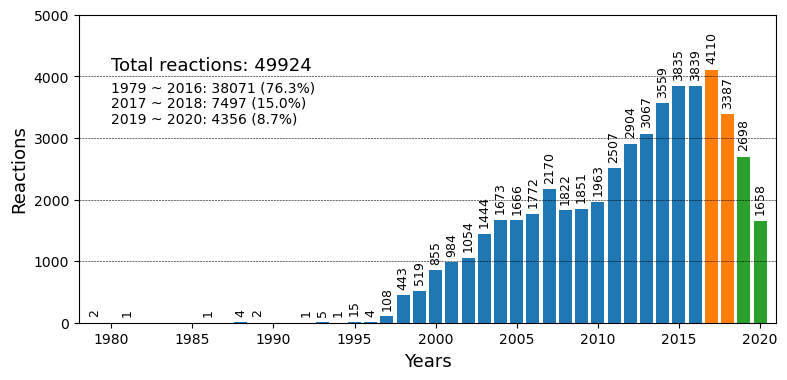

In [17]:
years = np.array([d['year'] for d in raw_data])
f, ax = plt.subplots(1,1,figsize=(9,4))
total = [0,0,0]
for y in range(years.min(), years.max()+1):
    n = np.sum(years == y)
    if n == 0: continue
    if y <= y1:
        ax.bar(y, n, color=mpl.cm.tab10(0))
        total[0] += n
    elif y <= y2:
        ax.bar(y, n, color=mpl.cm.tab10(1))
        total[1] += n
    else:
        ax.bar(y, n, color=mpl.cm.tab10(2))
        total[2] += n
    ax.text(y, n + 100, f'{n:.0f}', rotation=90, fontsize=9,
            horizontalalignment='center', verticalalignment='bottom')
for i in range(1,5):
    ax.axhline(i*1000, ls='--', color='k', lw=0.4)
ax.set_ylabel('Reactions', fontsize=13)
ax.set_xlabel('Years', fontsize=13)
ax.text(1980, 3700+400, f'Total reactions: {len(years)}', fontsize=13)
ax.text(1980, 3450+300, f'1979 ~ {y1}: {total[0]} ({100*total[0]/np.sum(total):.1f}%)', fontsize=10)
ax.text(1980, 3200+300, f'{y1+1} ~ {y2}: {total[1]} ({100*total[1]/np.sum(total):.1f}%)', fontsize=10)
ax.text(1980, 2950+300, f'{y2+1} ~ 2020: {total[2]} ({100*total[2]/np.sum(total):.1f}%)', fontsize=10)
ax.set_ylim([0, 5000])
ax.set_xlim([1978, 2021])

(1978.0, 2021.0)

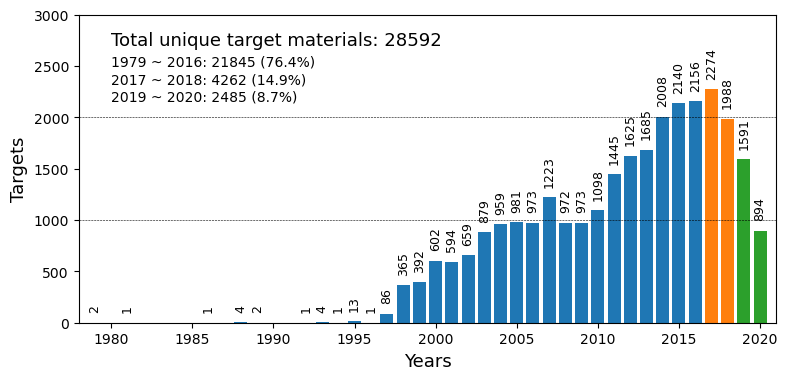

In [19]:
years = np.array([d['year'] for d in unique_target])
f, ax = plt.subplots(1,1,figsize=(9,4))
total = [0,0,0]
for y in range(years.min(), years.max()+1):
    n = np.sum(years == y)
    if n == 0: continue
    if y < y1+1:
        ax.bar(y, n, color=mpl.cm.tab10(0))
        total[0] += n
    elif y < y2+1:
        ax.bar(y, n, color=mpl.cm.tab10(1))
        total[1] += n
    else:
        ax.bar(y, n, color=mpl.cm.tab10(2))
        total[2] += n
    ax.text(y, n + 100, f'{n:.0f}', rotation=90, fontsize=9,
            horizontalalignment='center', verticalalignment='bottom')
for i in range(1,3):
    ax.axhline(i*1000, ls='--', color='k', lw=0.4)
ax.set_ylabel('Targets', fontsize=13)
ax.set_xlabel('Years', fontsize=13)
ax.text(1980, 2700, f'Total unique target materials: {len(years)}', fontsize=13)
ax.text(1980, 2500, f'1979 ~ {y1}: {total[0]} ({100*total[0]/np.sum(total):.1f}%)', fontsize=10)
ax.text(1980, 2330, f'{y1+1} ~ {y2}: {total[1]} ({100*total[1]/np.sum(total):.1f}%)', fontsize=10)
ax.text(1980, 2160, f'{y2+1} ~ 2020: {total[2]} ({100*total[2]/np.sum(total):.1f}%)', fontsize=10)

ax.set_ylim([0,3000])
ax.set_xlim([1978, 2021])

(1978.0, 2021.0)

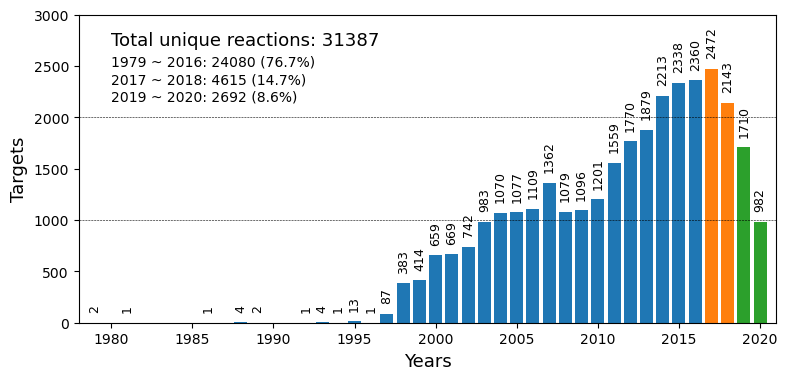

In [21]:
years = np.array([d['year'] for d in unique_reaction])
f, ax = plt.subplots(1,1,figsize=(9,4))
total = [0,0,0]
for y in range(years.min(), years.max()+1):
    n = np.sum(years == y)
    if n == 0: continue
    if y < y1+1:
        ax.bar(y, n, color=mpl.cm.tab10(0))
        total[0] += n
    elif y < y2+1:
        ax.bar(y, n, color=mpl.cm.tab10(1))
        total[1] += n
    else:
        ax.bar(y, n, color=mpl.cm.tab10(2))
        total[2] += n
    ax.text(y, n + 100, f'{n:.0f}', rotation=90, fontsize=9,
            horizontalalignment='center', verticalalignment='bottom')
for i in range(1,3):
    ax.axhline(i*1000, ls='--', color='k', lw=0.4)
ax.set_ylabel('Targets', fontsize=13)
ax.set_xlabel('Years', fontsize=13)
ax.text(1980, 2700, f'Total unique reactions: {len(years)}', fontsize=13)
ax.text(1980, 2500, f'1979 ~ {y1}: {total[0]} ({100*total[0]/np.sum(total):.1f}%)', fontsize=10)
ax.text(1980, 2330, f'{y1+1} ~ {y2}: {total[1]} ({100*total[1]/np.sum(total):.1f}%)', fontsize=10)
ax.text(1980, 2160, f'{y2+1} ~ 2020: {total[2]} ({100*total[2]/np.sum(total):.1f}%)', fontsize=10)
ax.set_ylim([0,3000])
ax.set_xlim([1978, 2021])

In [100]:
for e in sorted(AllElements, key=lambda x: Element(x).number):
    i = Element(e).number
    if i == 104: break
    print(f'{e:2s} : {target_elements[i].sum():5d}')
    

H  :   154
He :     0
Li :  5299
Be :    56
B  :   833
C  :   378
N  :   395
O  : 41800
F  :   656
Ne :     0
Na :  3516
Mg :  3662
Al :  4405
Si :  3858
P  :  2335
S  :  1649
Cl :   469
Ar :     0
K  :   173
Ca :  6419
Sc :   605
Ti :  9939
V  :  1600
Cr :  1459
Mn :  6138
Fe :  7455
Co :  4549
Ni :  3132
Cu :  4550
Zn :  3695
Ga :  2097
Ge :  1201
As :   335
Se :  1323
Br :   101
Kr :     0
Rb :   146
Sr :  7785
Y  :  3286
Zr :  3502
Nb :  4305
Mo :  1739
Tc :     6
Ru :   730
Rh :   175
Pd :   190
Ag :   792
Cd :   393
In :  1183
Sn :  1638
Sb :  1860
Te :  1923
I  :   140
Xe :     0
Cs :   274
Ba :  7849
La :  6758
Ce :  2120
Pr :   921
Nd :  1252
Pm :     0
Sm :  1023
Eu :  1684
Gd :  1652
Tb :   595
Dy :   540
Ho :   317
Er :   348
Tm :    85
Yb :   676
Lu :   525
Hf :   258
Ta :  1436
W  :  1327
Re :    81
Os :    49
Ir :   304
Pt :   101
Au :    80
Hg :    43
Tl :    75
Pb :  2337
Bi :  5498
Po :     0
At :     0
Rn :     0
Fr :     0
Ra :     0
Ac :     0
Th :    49
Pa :     0

### Usage of elements 

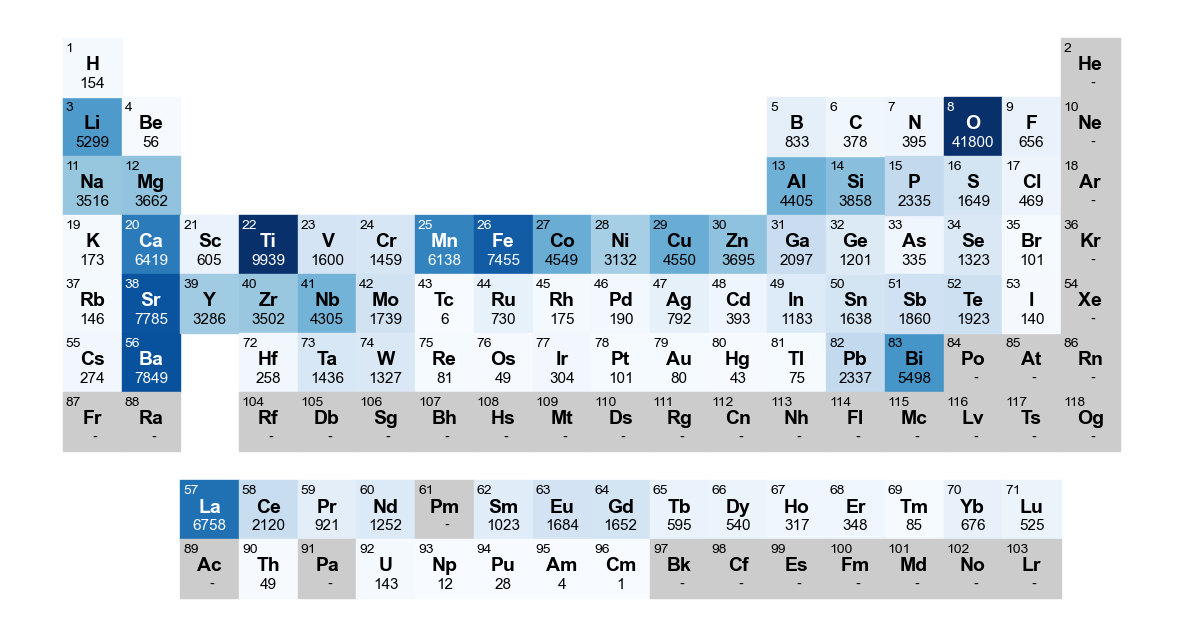

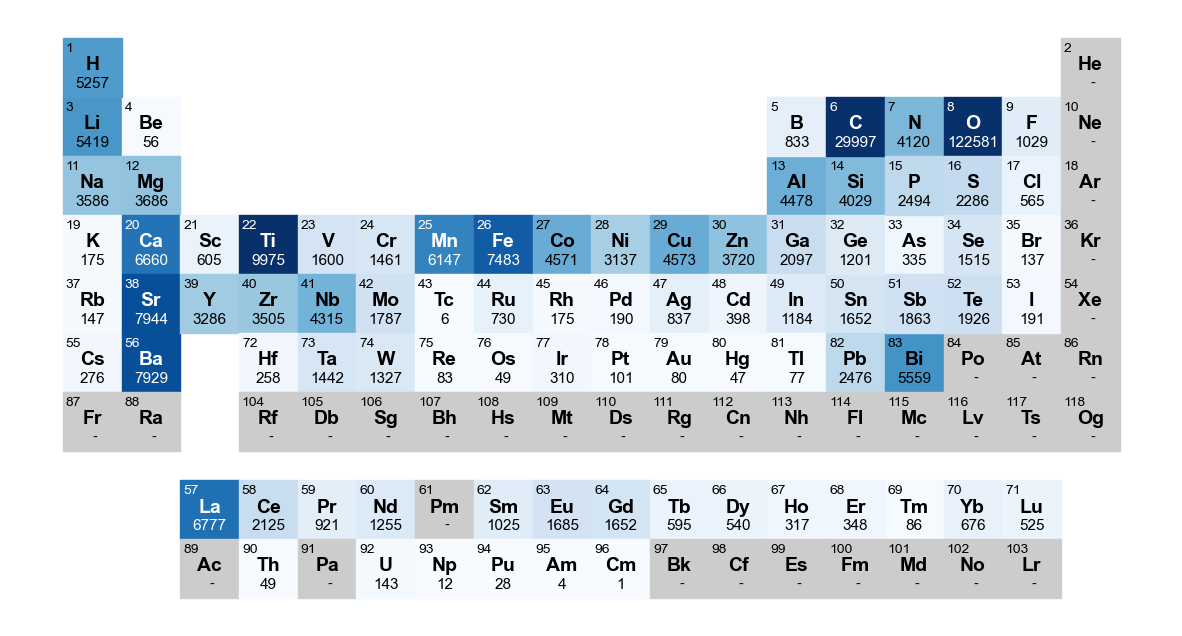

In [14]:
cy = 0
cmap = mpl.cm.Blues
cmap.set_under([0.5,0.5,0.5])
for elements in [target_elements, prec_elements]:
    f, ax = plt.subplots(1,1,figsize=(15,8))
    counter = {(6,3):0, (7,3):0}
    for e in AllElements:
        ele = Element(e)
        x, y = ele.row, ele.group
        z = 0
        if ele.number < 104:
            z = elements[ele.number].sum()
        key = (x,y)
        if key in counter.keys():
            x += 2.5
            y += counter[key]
            counter[key] += 1
        x=-x
    #    print(i, x,y)
        color = [0,0,0]
        if z > 6000: color = [1,1,1]
        if z != 0:
            ax.fill_between([y, y+1], x, x-1, color=cmap(z/9000))
            ax.text(y+0.5, x-0.85, f'{z:.0f}', fontsize=11, fontfamily='arial', color=color, horizontalalignment='center')
        else:
            ax.fill_between([y, y+1], x, x-1, color=[0.8, 0.8, 0.8])
            ax.text(y+0.5, x-0.85, '-')
        ax.text(y+0.05, x-0.24, str(ele.number), fontsize=10, fontfamily='arial', color=color)
        ax.text(y+0.5, x-0.55, e, fontsize=14, fontweight='bold', fontfamily='arial', color=color, horizontalalignment='center')
    ax.axis('off')
    #f.savefig('./figs/ptable.electronegativity.pdf')


In [19]:
element_fractions = {'all':[]}
element_fractions.update({e:[] for e in sorted(AllElements, key=lambda x: Element(x).number)})
for data in raw_data:
    for ele, frac in data['target_comp'].items():
        element_fractions[ele].append(np.log10(frac))
        element_fractions['all'].append(np.log10(frac))

In [28]:
for ele, frac in element_fractions.items():
    if len(frac) == 0: continue
    print('{:5s} {:4d} {:8.2f} {:8.2f}'.format(ele, len(frac), min(frac), max(frac)))
    _f = np.array(frac)
    if np.sum(_f < -3.9) != 0:
        print(' '.join([f'{_n:10.6f}' for _n in np.power(10, _f[_f < -3.9])]))

all   192474    -5.30    -0.00
  0.000125   0.000083   0.000010   0.000005   0.000034   0.000083   0.000111   0.000111   0.000111   0.000111   0.000100   0.000050   0.000083   0.000100   0.000100   0.000100   0.000100   0.000091   0.000088   0.000023   0.000116   0.000091   0.000022   0.000022   0.000122   0.000125   0.000067   0.000125   0.000125   0.000125   0.000100   0.000119   0.000045   0.000095   0.000100   0.000100   0.000101   0.000121   0.000032   0.000034   0.000103   0.000034   0.000103
H      154    -2.25    -0.15
Li    5299    -3.19    -0.09
Be      56    -3.28    -0.03
B      833    -3.00    -0.02
C      378    -3.38    -0.01
N      395    -2.32    -0.25
O     41800    -2.49    -0.08
F      656    -2.85    -0.10
Na    3516    -3.81    -0.12
Mg    3662    -3.70    -0.01
Al    4405    -3.51    -0.00
Si    3858    -3.30    -0.00
P     2335    -2.45    -0.06
S     1649    -2.82    -0.00
Cl     469    -3.05    -0.10
K      173    -2.00    -0.18
Ca    6419    -3.64    -0.04
Sc

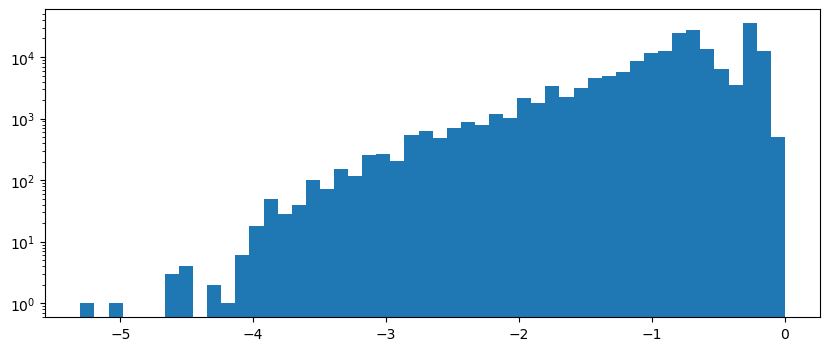

In [25]:
f, ax = plt.subplots(1,1,figsize=(10,4))
ax.hist(element_fractions['all'], bins=50)
ax.set_yscale('log')

- check with prototype path
  - 데이터 구성에 의문점이 많음. prototype_path를 이용해 중복을 제거하면 너무 많은 물질이 제거됨.
  - 제거 후에도 validation data에 2020년 데이터가 남아있기도 함.
  - 따로 제거 방식이 있을 듯 한데....

In [25]:
data_mat = []
for ds, dataset in parsed_data.items():
    ds_key = ds.split('_')[0]
    for data in dataset:
        _d = [ds_key, data['year']] + data['prototype_path'][0].split('/')
        if 'Misc' in _d:
            _d = _d[:6] + ['Misc'] +_d[6:]
        data_mat.append(_d)
df = pd.DataFrame(data_mat)
df.columns = [f'{i:02d}' for i in df.columns]
df = df.sort_values('01')

In [26]:
misc = df[df['06'] == 'Misc']
cat  = df[df['06'] != 'Misc']
for ds in ['train','valid','test']:
    ms0 = misc[misc['00'] == ds]
    ms1 = misc.drop_duplicates(['08'])
    ms1 = ms1[ms1['00'] == ds]
    ms2 = misc.drop_duplicates(['09'])
    ms2 = ms2[ms2['00'] == ds]
    
    cs0 = cat[cat['00'] == ds]
    cs1 = cat.drop_duplicates(['06','07'])
    cs1 = cs1[cs1['00'] == ds]
    cs2 = cat.drop_duplicates(['09'])
    cs2 = cs2[cs2['00'] == ds]
    print(ms0.shape, ms1.shape, ms2.shape)
    print(ms0['01'].min(), ms0['01'].max(), ms1['01'].min(), ms1['01'].max(), ms2['01'].min(), ms2['01'].max())

    print(cs0.shape, cs1.shape, cs2.shape)
    print(cs0['01'].min(), cs0['01'].max(), cs1['01'].min(), cs1['01'].max(), cs2['01'].min(), cs2['01'].max())


(16819, 10) (13282, 10) (13282, 10)
1979 2020 1979 2020 1979 2020
(27917, 10) (4392, 10) (11618, 10)
1988 2020 1988 2020 1988 2020
(1794, 10) (1571, 10) (1571, 10)
2015 2020 2015 2020 2015 2020
(460, 10) (117, 10) (356, 10)
2015 2020 2015 2020 2015 2020
(2619, 10) (2389, 10) (2389, 10)
2017 2020 2017 2020 2017 2020
(315, 10) (71, 10) (276, 10)
2017 2020 2017 2020 2017 2020


In [39]:
df[(df['00'] == 'train')].drop_duplicates('02 03 04 05 06 07 08 09'.split())

,00,01,02,03,04,05,06,07,08,09
0,train,1979,AllMaterials,oxides,quaternary,Others,Misc,Misc,Y0.00200057Al0.05487283Si0.37153473N0.51443273...,Y0.00200057Al0.05487283Si0.37153473N0.51443273...
1,train,1979,AllMaterials,oxides,quaternary,Others,Misc,Misc,Y0.001Al0.05614286Si0.37142855N0.51428568O0.05...,Y0.001Al0.05614286Si0.37142855N0.51428568O0.05...
2,train,1981,AllMaterials,oxides,ternary,Others,Misc,Misc,Zr0.40000001Cr0.80000001O2,Zr0.40000001Cr0.80000001O2
3,train,1986,AllMaterials,oxides,quaternary,Others,Misc,Misc,Na5Y(SiO3)4,Na5Y(SiO3)4
4,train,1988,AllMaterials,oxides,ternary,Others,BaFe12O19,NoDoping,BaFe12O19,BaFe12O19
...,...,...,...,...,...,...,...,...,...,...
43247,train,2020,AllMaterials,oxides,ternary,Others,Fe4Bi2O9,SubBi<-Nd,Nd0.05999999Fe4Bi1.93999994O9,Nd0.05999999Fe4Bi1.93999994O9
43244,train,2020,AllMaterials,oxides,ternary,ABO3,LuMnO3,SubLu<-Y,Y0.30000001Lu0.69999999Mn1O3,Y0.30000001Lu0.69999999Mn1O3
43240,train,2020,AllMaterials,oxides,ternary,Others,Misc,Misc,Ce0.03Fe1.93999994Co1.02999997O4,Ce0.03Fe1.93999994Co1.02999997O4
43239,train,2020,AllMaterials,oxides,ternary,AB2O4,Fe2CoO4,NoDoping,Ce0.02Fe1.95999992Co1.01999998O4,Ce0.02Fe1.95999992Co1.01999998O4


In [108]:
train_mask = df['00'] == 'train'
df_uniq = pd.concat([
    df[train_mask & (df['07'] == 'Misc')], df[train_mask & (df['07'] != 'Misc')].drop_duplicates([f'{i:02d}' for i in range(2,8)])
])
df_uniq

,00,01,02,03,04,05,06,07,08,09
0,train,1979,AllMaterials,oxides,quaternary,Others,Misc,Misc,Y0.00200057Al0.05487283Si0.37153473N0.51443273...,Y0.00200057Al0.05487283Si0.37153473N0.51443273...
1,train,1979,AllMaterials,oxides,quaternary,Others,Misc,Misc,Y0.001Al0.05614286Si0.37142855N0.51428568O0.05...,Y0.001Al0.05614286Si0.37142855N0.51428568O0.05...
2,train,1981,AllMaterials,oxides,ternary,Others,Misc,Misc,Zr0.40000001Cr0.80000001O2,Zr0.40000001Cr0.80000001O2
3,train,1986,AllMaterials,oxides,quaternary,Others,Misc,Misc,Na5Y(SiO3)4,Na5Y(SiO3)4
8,train,1989,AllMaterials,oxides,ternary,Others,Misc,Misc,Tb2Te4O11,Tb2Te4O11
...,...,...,...,...,...,...,...,...,...,...
44485,train,2019,AllMaterials,oxides,quinary,Others,Li6.4La3Zr2Ga0.2O12,SubLa<-Y,Li6.40000057La2.87499976Y0.125Zr2Ga0.20000002O12,Li6.40000057La2.87499976Y0.125Zr2Ga0.20000002O12
44494,train,2019,AllMaterials,oxides,quaternary,Others,Li3Mg2SbO6,SubSb<-Mn,Li3Mg2Mn0.005Sb0.995O6,Li3Mg2Mn0.005Sb0.995O6
44642,train,2015,AllMaterials,chalcogenides,binary,Others,As2Te3,SubAs<-Sn,Sn0.01Te3As1.98999989,Sn0.01Te3As1.98999989
44661,train,2015,AllMaterials,oxides,quaternary,ABC2D6,Ba2YIrO6,SubBa<-Sr,Ba1.79999995Sr0.19999999Y1Ir1O6,Ba1.79999995Sr0.19999999Y1Ir1O6


### precursors

In [15]:
pvec = np.vstack([active_composit_feature(prec['precursor_comp']) for prec in unique_precursor])
dmat = np.square(pvec[..., np.newaxis] - pvec.T[np.newaxis, ...]).sum(1)    

In [23]:
i = 4
js = np.argsort(dmat[i])[1:6]
print(unique_precursor[i]['precursor_comp'])
for j in js:
    print(unique_precursor[j]['precursor_comp'])

{'Fe': 0.4, 'O': 0.6}
{'Fe': 0.42857143, 'O': 0.5714286}
{'Fe': 0.33333334, 'O': 0.6666667}
{'Fe': 0.5, 'O': 0.5}
{'Fe': 0.2857143, 'O': 0.71428573}
{'Fe': 0.33333334, 'C': 0.16666667, 'O': 0.5}


In [35]:
prec_comps = {}
for tgt in unique_target:
    for rxn in tgt['reactions']:
        for prec in rxn['precursor_comp']:
            p = tuple(sorted(prec.keys(), key=lambda x: Element(x).number))
            v = tuple([f'{f:.5f}' for e,f in sorted(prec.items(), key=lambda x: Element(x[0]).number)])
            if p not in prec_comps.keys():
                prec_comps[p] = {}
            if v not in prec_comps[p].keys():
                prec_comps[p][v] = 0
            prec_comps[p][v] += 1
prec_comps = {k:v for k,v in sorted(prec_comps.items(), key=lambda x: np.sum(list(x[1].values())), reverse=True)}

In [77]:
screened_prec_comps = {}
for c, fs in prec_comps.items():
    _fs = {k:v for k,v in fs.items() if v > 4}
    if len(_fs) != 0:
        screened_prec_comps[c] = _fs
len(unique_precursor), len(prec_comps), len(screened_prec_comps)

(1038, 665, 384)

In [84]:
{k + (len(v),):v for k,v in sorted(prec_comps.items(), key=lambda x: np.sum(list(x[1].values())), reverse=True) if len(v) > 1}

{('O', 'Ti', 4): {('0.66667', '0.33333'): 4850,
  ('0.75000', '0.25000'): 5,
  ('0.50000', '0.50000'): 6,
  ('0.60000', '0.40000'): 44},
 ('C', 'O', 'Sr', 6): {('0.20000', '0.60000', '0.20000'): 4453,
  ('0.22222', '0.66667', '0.11111'): 8,
  ('0.16667', '0.50000', '0.33333'): 23,
  ('0.28571', '0.57143', '0.14286'): 4,
  ('0.25000', '0.50000', '0.25000'): 1,
  ('0.14286', '0.42857', '0.42857'): 1},
 ('C', 'O', 'Ba', 5): {('0.20000', '0.60000', '0.20000'): 4297,
  ('0.16667', '0.50000', '0.33333'): 31,
  ('0.22222', '0.66667', '0.11111'): 1,
  ('0.14286', '0.42857', '0.42857'): 1,
  ('0.28571', '0.57143', '0.14286'): 4},
 ('O', 'La', 2): {('0.60000', '0.40000'): 4180, ('0.71429', '0.28571'): 1},
 ('O', 'Fe', 6): {('0.60000', '0.40000'): 3684,
  ('0.66667', '0.33333'): 2,
  ('0.57143', '0.42857'): 97,
  ('0.71429', '0.28571'): 2,
  ('0.50000', '0.50000'): 31,
  ('0.33333', '0.66667'): 1},
 ('C', 'O', 'Ca', 3): {('0.20000', '0.60000', '0.20000'): 3774,
  ('0.16667', '0.50000', '0.33333')

(-1.0, 101.0)

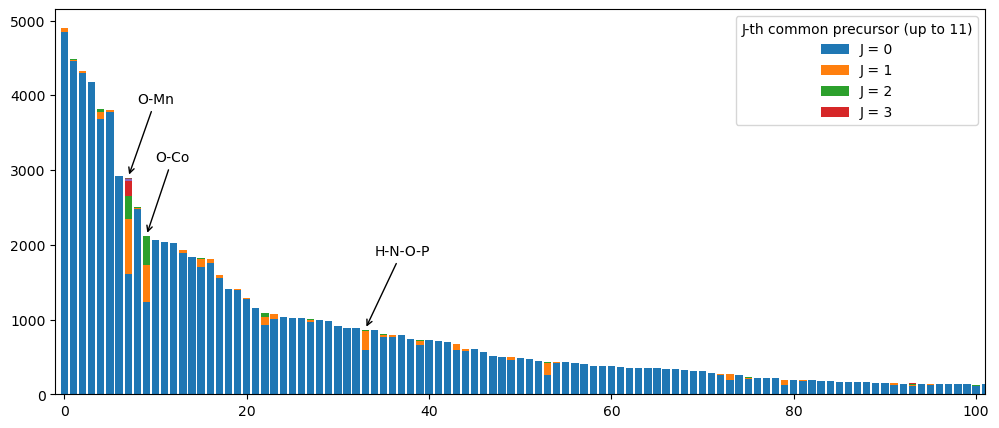

In [103]:
f, ax = plt.subplots(1,1,figsize=(12,5))
xmax = 101
for i, (c, fs) in enumerate(screened_prec_comps.items()):
    y = 0
    for j, f in enumerate(sorted(list(fs.values()), reverse=True)):
        ax.bar(i, f, bottom=y, color=plt.cm.tab10(j))
        y += f
        if (j == 1) and (f > sorted(fs.values())[-1] * 0.2) and (f > 160):
#            ax.arrow(i, , dx=2, dy=1000, arrowprops={'arrowstyle':'<-'})
            ax.annotate('-'.join(list(c)), xy=(i, np.sum(list(fs.values())) + 10), xytext=(i+1, np.sum(list(fs.values())) + 1000), arrowprops=dict(arrowstyle="->"))
    if i == xmax: 
        for j in range(4):
            ax.bar(i+5, 1, bottom=j, color=plt.cm.tab10(j), label=f'J = {j}')
        break
ax.legend(loc='upper right', title='J-th common precursor (up to 11)')
ax.set_xlim([-1,xmax])

In [111]:
for prec in unique_precursor:
    if 'Sr' in prec['precursor_str']:
        print(prec['count_rxn'], prec['precursor_str'])

4453 C_0.20000 O_0.60000 Sr_0.20000
190 O_0.50000 Sr_0.50000
134 N_0.22222 O_0.66667 Sr_0.11111
79 O_0.66667 Sr_0.33333
86 F_0.66667 Sr_0.33333
58 Cl_0.66667 Sr_0.33333
63 Sr_1.00000
28 N_0.40000 Sr_0.60000
24 S_0.50000 Sr_0.50000
23 C_0.16667 O_0.50000 Sr_0.33333
8 C_0.22222 O_0.66667 Sr_0.11111
8 H_0.40000 O_0.40000 Sr_0.20000
6 O_0.66667 S_0.16667 Sr_0.16667
5 H_0.40000 C_0.26667 O_0.26667 Sr_0.06667
4 N_0.20000 O_0.60000 Sr_0.20000
4 C_0.28571 O_0.57143 Sr_0.14286
4 O_0.66667 P_0.22222 Sr_0.11111
4 N_0.60000 Sr_0.40000
4 Sr_0.33333 I_0.66667
2 Se_0.50000 Sr_0.50000
2 O_0.60000 Sr_0.40000
1 H_0.30769 C_0.30769 O_0.30769 Sr_0.07692
1 C_0.25000 O_0.50000 Sr_0.25000
1 O_0.63636 P_0.18182 Sr_0.18182
1 O_0.61538 P_0.15385 Sr_0.23077
1 C_0.14286 O_0.42857 Sr_0.42857
1 H_0.30303 O_0.15152 Cl_0.39394 Sr_0.15152
1 C_0.25000 N_0.50000 Sr_0.25000
1 H_0.14286 O_0.57143 P_0.14286 Sr_0.14286
1 H_0.66667 Sr_0.33333
1 Br_0.66667 Sr_0.33333
1 P_0.66667 Sr_0.33333


In [114]:
metal_source = {'None':{}}
for prec in unique_precursor:
    has_metal = False
    for mele in MetalElements:
        if mele in prec['precursor_str']:
            has_metal = True
            break
    if has_metal:
        if mele not in metal_source.keys():
            metal_source[mele] = {}
        metal_source[mele][prec['precursor_str']] = prec['count_rxn']
    else:
        metal_source['None'][prec['precursor_str']] = prec['count_rxn']
metal_source

{'None': {'Se_1.00000': 989,
  'S_1.00000': 787,
  'H_0.50000 N_0.08333 O_0.33333 P_0.08333': 587,
  'H_0.56250 N_0.12500 O_0.25000 P_0.06250': 264,
  'P_1.00000': 196,
  'C_1.00000': 131,
  'O_0.71429 P_0.28571': 144,
  'H_0.37500 O_0.50000 P_0.12500': 83,
  'H_0.66667 N_0.16667 Cl_0.16667': 45,
  'P_0.28571 S_0.71429': 17,
  'P_0.28571 Se_0.71429': 10,
  'H_0.66667 N_0.16667 F_0.16667': 29,
  'O_0.66667 Se_0.33333': 25,
  'I_1.00000': 21,
  'H_0.66667 C_0.22222 O_0.11111': 18,
  'H_0.53333 N_0.13333 O_0.26667 S_0.06667': 15,
  'H_0.28571 O_0.57143 S_0.14286': 9,
  'H_0.60000 N_0.15000 O_0.20000 P_0.05000': 9,
  'O_0.80000 P_0.20000': 4,
  'H_0.62500 N_0.12500 F_0.25000': 5,
  'P_0.40000 S_0.60000': 3,
  'H_0.45455 N_0.09091 O_0.36364 P_0.09091': 3,
  'H_0.34615 N_0.07692 O_0.46154 P_0.11538': 3,
  'H_0.27273 N_0.04545 O_0.54545 P_0.13636': 4,
  'H_0.66667 C_0.16667 O_0.16667': 4,
  'H_0.37500 C_0.37500 O_0.25000': 4,
  'H_0.64286 C_0.21429 S_0.07143 I_0.07143': 4,
  'H_0.25000 C_0.25

### Reactions

In [112]:
mn_count = {}
for rxn in unique_reaction:
    prec_eles = ['-'.join(sorted(prec.keys(), key=lambda x: Element(x).number)) for prec in rxn['precursor_comp']]
    mn_precs = tuple(sorted([p for p in prec_eles if 'Mn' in p]))
    if len(mn_precs) == 0: continue
    if mn_precs not in mn_count.keys():
        mn_count[mn_precs] = 0
    mn_count[mn_precs] += 1
mn_count


{('C-O-Mn',): 793,
 ('O-Mn',): 2891,
 ('Mn',): 440,
 ('H-C-O-Mn',): 135,
 ('N-O-Mn',): 52,
 ('H-O-Mn',): 24,
 ('Cl-Mn',): 2,
 ('O-P-Mn',): 5,
 ('H-N-O-P-Mn',): 1,
 ('S-Mn',): 8,
 ('O-Mn', 'O-Mn'): 2,
 ('F-Mn',): 11,
 ('Cl-Mn', 'S-Mn'): 2,
 ('O-S-Mn',): 3,
 ('Mn', 'N-Mn'): 1,
 ('Cl-Mn', 'O-Mn'): 2,
 ('Mn-Br', 'O-Mn'): 1,
 ('N-Mn',): 1,
 ('Mn-Se',): 1,
 ('C-O-Mn', 'C-O-Mn'): 1,
 ('Mn-I',): 2}

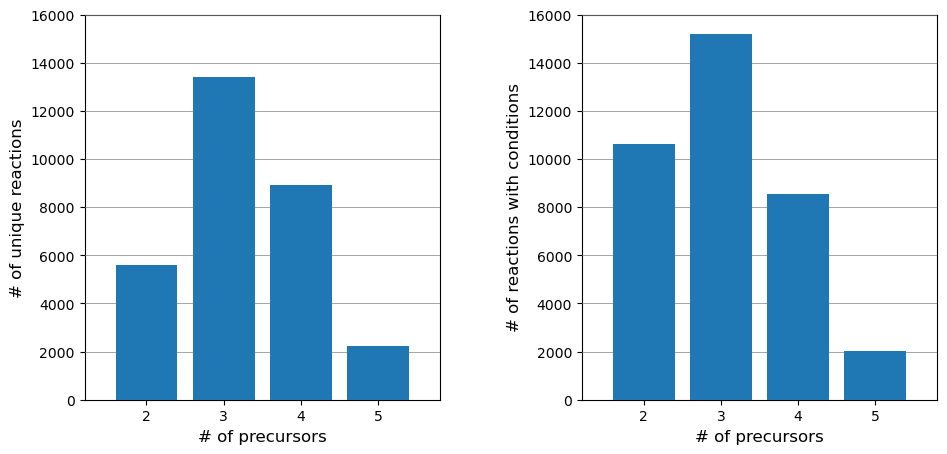

In [139]:
ns = np.zeros((2,10))
for rxn in screened_unique_reaction:
    n = len(rxn['precursor_comp'])
    ns[0,n] += 1
for rxn in screened_conditional_reaction:
    n = len(rxn['precursor_comp'])
    ns[1,n] += 1

f, axs = plt.subplots(1,2,figsize=(11,5))
for ax, n in zip(axs, ns):
    for i, y in enumerate(n):
        ax.bar(i, y, color=plt.cm.tab10(0), zorder=20)
    ax.set_xlabel('# of precursors', fontsize=12)
    ax.set_xlim([1.2, 5.8])
    ax.set_ylim([0, 16000])
    ax.set_xticks([2,3,4,5])
    for i in range(1,10):
        ax.axhline(i*2000, lw=0.5, color=[0.5,0.5,0.5], zorder=10)
axs[0].set_ylabel('# of unique reactions', fontsize=12)
axs[1].set_ylabel('# of reactions with conditions', fontsize=12)
f.subplots_adjust(wspace=0.4)

## operations

In [156]:
operations = {}
temp_vals = {}
time_vals = {}
# count op.
count_ops = {i:0 for i in range(20)}
# check for heating op.
temp_deviations = []
time_deviations = []

temp_dist_by_precursor = {}
temp_dist_by_target_system = {}

for data in raw_data:
    ns = [0,0]
    for op in data['operations']:
        op_type = op['type']
        if op_type not in operations.keys():
            operations[op_type] = 0
            temp_vals[op_type] = []
            time_vals[op_type] = []
        # count operation
        operations[op_type] += 1
        # temp. & time values
        for t in op['attributes']['temperature']:
            v = t['values']
            if len(v) == 0: continue
            temp_vals[op_type].extend(t['values'])
            if 'Heating' in op_type:
                if len(v) == 1:
                    temp_deviations.append([0,0,1])
                else:
                    temp_deviations.append([np.mean(v), np.max(v) - np.min(v), len(v)])
        for t in op['attributes']['time']:
            v = t['values']
            if len(v) == 0: continue
            time_vals[op_type].extend(t['values'])
            if 'Heating' in op_type:
                if len(v) == 1:
                    time_deviations.append([0,0,1])
                else:
                    time_deviations.append([np.mean(v), np.max(v) - np.min(v), len(v)])
        # check whether temp. (or time) is exist or not in datapoint (heating only)
        if ('Heating' in op_type) and len(op['attributes']['temperature']) != 0:
            ns[0] += 1
        if ('Mixing' in op_type) and len(op['attributes']['temperature']) != 0:
            ns[1] += 1
    if sum(ns) > 10:
        print(json.dumps(data['operations'], indent=4))
    count_ops[ns[0]] += 1
    count_ops[ns[1]] += 1
    count_ops[sum(ns)] += 1
#                has_temp[len(op['attributes']['temperature'])] += 1
#                has_time[k][len(op['attributes']['time'])] += 1

In [198]:
s = 'Type '
keys = [k for k in operations.keys() if not k.startswith('Start')]
for key in keys:
    s += f'{key.split("Op")[0]:>13s}'
print(s)

s = ['Op.  ', 'Tmp. ', 'Time ']
for key in keys:
    s[0] += f'{operations[key]:13d}'
    s[1] += f'{len(temp_vals[key]):13d}'
    s[2] += f'{len(time_vals[key]):13d}'
for _s in s: print(_s)


Type        Drying      Heating       Mixing      Shaping    Quenching
Op.          12907        79092        66632        19124        15247
Tmp.          4608        76791         1319            0        10380
Time          2967        61915        16238            0          737


(-0.5, 4.5)

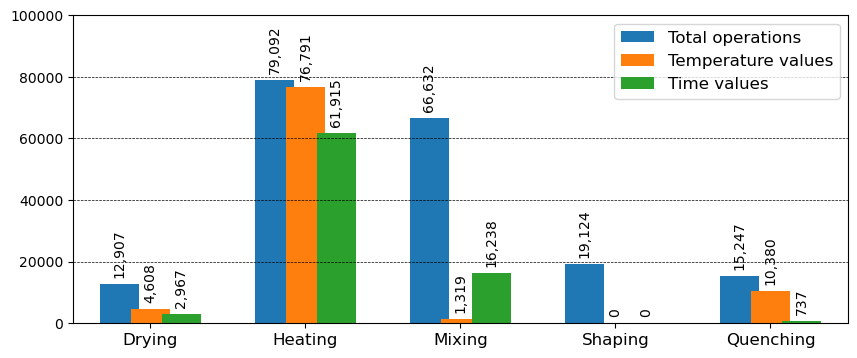

In [266]:
f, ax = plt.subplots(1,1,figsize=(10,4))
for i in range(1,5):
    ax.axhline(20000 * i, ls='--', lw=0.5, color=[0,0,0])
ax.bar(0, 0, color=mpl.cm.tab10(0), label='Total operations')
ax.bar(0, 0, color=mpl.cm.tab10(1), label='Temperature values')
ax.bar(0, 0, color=mpl.cm.tab10(2), label='Time values')
for i, key in enumerate(keys):
    for j, v in enumerate([operations[key], len(temp_vals[key]), len(time_vals[key])]):
        b = ax.bar(i + (j-1) * 0.2, v, width=0.25, color=mpl.cm.tab10(j))
        ax.text(i+(j-1)*0.2, v+2000, f'{v:,d}', rotation=90,
                horizontalalignment='center', verticalalignment='bottom')
    
_ = ax.set_xticks(np.arange(len(keys)), labels=[k.split('Op')[0] for k in keys], fontsize=12)
ax.set_ylim([0, 100000])
ax.legend(loc='upper right', fontsize=12)
ax.set_xlim([-0.5, 4.5])

- Temp. and Time dist.

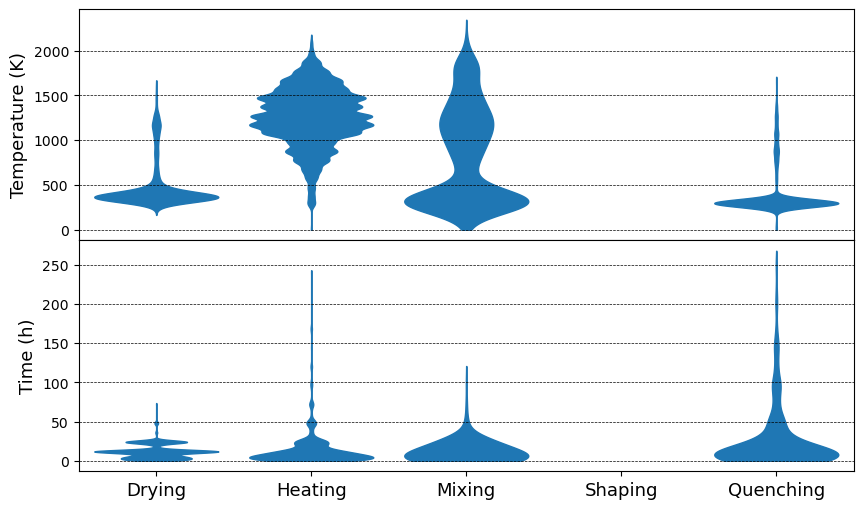

In [278]:
f, ax = plt.subplots(2,1,figsize=(10,6), sharex=True)
y1 = np.linspace(0,3000,3000)
y2 = np.linspace(0,300,3000)
for i, key in enumerate(keys):
    t1 = temp_vals[key]
    t2 = time_vals[key]
    if len(t1) != 0:
        x = gaussian_kde(t1)(y1)
        x = x/np.max(x) * 0.4
        m = x > 1e-3
        ax[0].fill_betweenx(y1[m], -x[m]+i, x[m]+i, color=mpl.cm.tab10(0))
    if len(t2) != 0:
        x = gaussian_kde(t2)(y2)
        x = x/np.max(x) * 0.4
        m = x > 1e-3
        ax[1].fill_betweenx(y2[m], -x[m]+i, x[m]+i, color=mpl.cm.tab10(0))
for _ax in ax: 
    _ax.set_xlim([-0.5, 4.5])
[ax[0].axhline(i*500, ls='--', lw=0.5, color=[0,0,0]) for i in range(5)]
[ax[1].axhline(i*50, ls='--', lw=0.5, color=[0,0,0]) for i in range(6)]
ax[1].set_xticks(np.arange(len(keys)), labels=[k.split('O')[0].split('Syn')[0] for k in keys], fontsize=13)
ax[0].set_ylabel('Temperature (K)', fontsize=13)
ax[1].set_ylabel('Time (h)', fontsize=13)
f.subplots_adjust(hspace=0)

- Heating Op. temp. & time dist.

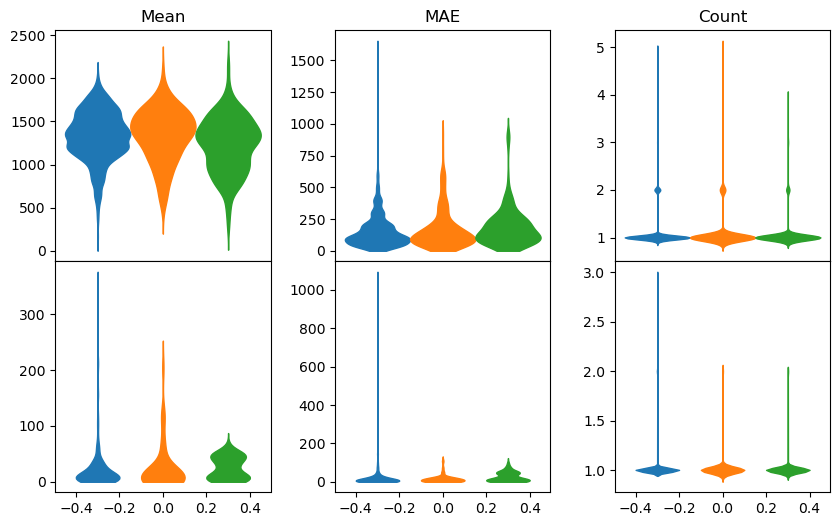

In [206]:
f, axs = plt.subplots(2,3,figsize=(10,6), sharex=True)
for i, ds in enumerate(operations.keys()):
    k = (i-1) * 0.3
    for j, vs in enumerate(np.array(temp_dist[ds]).T):
        y = np.linspace(0,3000,500)
        if j == 2:
            y = np.linspace(0,10,500)
        x = gaussian_kde(vs[vs != 0])(y)
        x = x/np.max(x) * 0.15
        m = x > 1e-4
        axs[0, j].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
    for j, vs in enumerate(np.array(time_dist[ds]).T):
        y = np.linspace(0,1500,500)
        if j == 2:
            y = np.linspace(0,10,500)
        x = gaussian_kde(vs[vs != 0])(y)
        x = x/np.max(x) * 0.1
        m = x > 1e-4
        axs[1, j].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
axs[0,0].set_title('Mean')
axs[0,1].set_title('MAE')
axs[0,2].set_title('Count')
f.subplots_adjust(hspace=0, wspace=0.3)

In [12]:
temps = []
times = []
for rxn in unique_reaction:
    temps.append(len(rxn['heat_temp']))
    times.append(len(rxn['heat_time']))

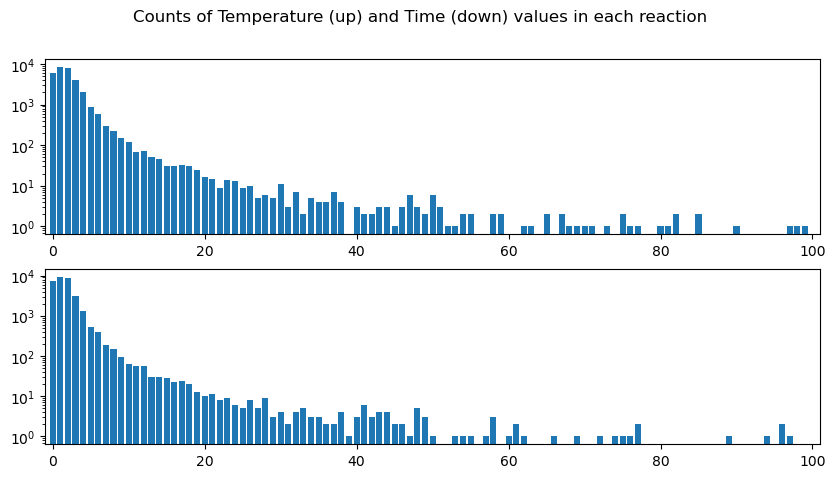

In [22]:
f, axs = plt.subplots(2,1,figsize=(10,5))
f.suptitle('Counts of Temperature (up) and Time (down) values in each reaction')
axs[0].bar(*np.unique(temps, return_counts=True))
axs[1].bar(*np.unique(times, return_counts=True))
for ax in axs: 
    ax.set_yscale('log')
    ax.set_xlim([-1,101])

In [254]:
for i, p in enumerate(unique_precursor):
    if p['count'] > 3: continue
    print(i, len(p['heat_temp']), len(p['heat_time']))

15 3 2
76 1 1
101 2 1
128 6 6
131 4 4
136 6 6
149 0 0
155 0 0
173 3 0
203 3 2
206 1 1
211 2 1
213 2 1
214 2 4
215 2 2
216 0 0
221 0 0
222 0 0
224 0 0
244 1 2
254 4 3
270 5 4
282 5 5
283 4 4
284 4 4
290 2 2
291 1 1
294 1 2
298 2 1
299 2 1
302 3 3
306 2 2
307 2 1
310 0 0
312 0 0
326 0 0
329 2 2
331 4 1
341 6 5
342 1 1
344 2 3
347 4 4
353 2 1
354 2 2
359 2 1
365 3 3
367 2 2
369 2 0
371 0 0
374 4 4
375 6 0
379 1 1
380 0 1
381 6 4
382 1 1
384 2 2
385 2 0
388 4 3
392 2 2
394 1 1
395 0 0
399 0 0
400 1 0
402 2 2
407 0 0
408 0 0
411 1 0
412 1 0
414 1 1
424 2 2
426 1 1
429 1 0
432 0 0
433 1 0
435 2 3
436 0 0
438 2 1
439 4 2
442 3 6
443 0 0
447 1 1
448 2 2
449 3 3
450 1 1
454 1 0
455 0 0
460 2 2
464 4 3
466 2 1
472 3 3
473 1 0
475 0 0
481 1 0
483 0 0
486 1 0
488 0 0
492 0 0
493 2 2
495 0 0
496 0 0
499 1 1
500 0 0
501 2 1
502 3 1
508 2 2
510 4 4
511 2 2
512 4 2
517 0 0
518 0 0
519 6 4
521 4 0
522 2 0
526 3 5
528 3 3
531 0 0
532 7 11
533 0 0
535 1 1
537 2 1
538 2 2
541 5 2
545 0 0
548 4 4
553 1 2
5

In [355]:
unique_reaction[5]['precursor_comp'], unique_reaction[5]['count']

([{'Fe': 0.33333334, 'C': 0.16666667, 'O': 0.5},
  {'Ba': 0.2, 'C': 0.2, 'O': 0.6}],
 1)

In [357]:
i = 0
for prec in unique_precursor:
    if prec['count'] > 4: continue
    i += 1
    print(i, prec['precursor_comp'], prec['reaction_ids'])

1 {'H': 0.6666667, 'C': 0.33333334} [9]
2 {'Fe': 0.33333334, 'O': 0.6666667} [12, 10638]
3 {'Zn': 0.2, 'H': 0.4, 'O': 0.4} [14, 885]
4 {'Tl': 0.2, 'N': 0.2, 'O': 0.6} [20, 6671]
5 {'Pb': 0.4, 'O': 0.6} [29, 1247, 4657]
6 {'Pb': 0.25, 'O': 0.75} [48]
7 {'Al': 0.5, 'O': 0.5} [54, 1067]
8 {'Fe': 0.2857143, 'O': 0.71428573} [98, 3459]
9 {'La': 0.045454547, 'H': 0.4090909, 'C': 0.27272728, 'O': 0.27272728} [110, 471, 1759, 21374]
10 {'La': 0.2, 'C': 0.2, 'O': 0.6} [112, 1435]
11 {'Y': 0.14285715, 'C': 0.21428572, 'O': 0.64285713} [165, 5052]
12 {'Zn': 0.6, 'N': 0.4} [176, 24376, 24377]
13 {'La': 0.054347828, 'H': 0.108695656, 'N': 0.19565217, 'O': 0.6413044} [189, 653, 2115]
14 {'Mg': 0.054347828, 'H': 0.108695656, 'N': 0.19565217, 'O': 0.6413044} [189, 2115]
15 {'Mg': 0.07692308, 'N': 0.23076923, 'O': 0.6923077} [190, 2116]
16 {'Cd': 0.33333334, 'Br': 0.6666667} [198, 4332]
17 {'Ga': 0.25, 'H': 0.25, 'O': 0.5} [204]
18 {'Ga': 0.33333334, 'O': 0.6666667} [206, 13646]
19 {'Co': 0.5, 'S': 0.5

## Targets & Precursors

In [11]:
chem_format = '{}={:.3f}'

count_ele = {e:0 for e in sorted(ActiveElements, key=lambda x: Element(x).number)}
count_target = {}
count_target_system = {}
count_prec = {}
count_prec_system = {}
count_tgt_eles = {e:{'count':0, 'case':{}} for e in sorted(MetalElements, key=lambda x: Element(x).number)}
count_tgt_eles.update({'None':{'count':0, 'case':{}}})
count_fg_eles = {}
count_multiple_prec_case = {e:np.zeros(8) for e in sorted(MetalElements, key=lambda x: Element(x).number)}
count_multiple_prec_case.update({'None':np.zeros(8)})
for data in raw_data:
    # get target material in string
    target_comp = {e:v for e,v in sorted(data['target_comp'].items(), key=lambda x: Element(x[0]).number)}
    prec_comps = [{e:v for e,v in sorted(prec_comp.items(), key=lambda x: Element(x[0]).number)} for prec_comp in data['precursor_comp']]
    
    target_string = '_'.join([chem_format.format(e,v) for e,v in target_comp.items() if v > 0.001])
    target_eles = tuple(list(target_comp.keys()))
    if target_string not in count_target.keys():
        count_target[target_string] = 0
    count_target[target_string] += 1
    if target_eles not in count_target_system.keys():
        count_target_system[target_eles] = 0
    count_target_system[target_eles] += 1

    _num_prec = {e:0 for e in target_comp.keys() if e in MetalElements}
    _num_prec.update({'None':0})
    for prec_comp in prec_comps:
        prec_string = '_'.join([chem_format.format(e,v) for e,v in prec_comp.items() if v > 0.001])
        prec_eles = tuple(list(prec_comp.keys()))
        prec_fg_eles = tuple([e for e in prec_comp.keys() if e not in MetalElements])
        prec_fg_comp_string = '_'.join([f'{v:.3f}' for e, v in prec_comp.items() if (e not in MetalElements) and (v > 0.001)])
        prec_metal_eles = [e for e in prec_comp.keys() if e in MetalElements]
        if len(prec_metal_eles) > 1: # if multiple metallic element
            print(prec_comp)
        prec_metal_ele = prec_metal_eles[0] if len(prec_metal_eles) != 0 else 'None'
        
        if prec_string not in count_prec.keys():
            count_prec[prec_string] = 0
        count_prec[prec_string] += 1
        if prec_eles not in count_prec_system.keys():
            count_prec_system[prec_eles] = 0
        count_prec_system[prec_eles] += 1
        if prec_fg_eles not in count_tgt_eles[prec_metal_ele]['case'].keys():
            count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles] = {'count':0, 'case':{}}
        if prec_fg_comp_string not in count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['case'].keys():
            count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['case'][prec_fg_comp_string] = 0
        count_tgt_eles[prec_metal_ele]['count'] += 1
        count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['count'] += 1
        count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['case'][prec_fg_comp_string] += 1
        
        if prec_fg_eles not in count_fg_eles.keys():
            count_fg_eles[prec_fg_eles] = {'count':0, 'case':{}}
        if prec_fg_comp_string not in count_fg_eles[prec_fg_eles]['case'].keys():
            count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string] = {'count':0, 'case':{}}
        if prec_metal_ele not in count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['case'].keys():
            count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['case'][prec_metal_ele] = 0
        count_fg_eles[prec_fg_eles]['count'] += 1
        count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['count'] += 1
        count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['case'][prec_metal_ele] += 1
        
        _num_prec[prec_metal_ele] += 1
    for e, v in _num_prec.items():
        if e == 'None' and v == 0: continue
        count_multiple_prec_case[e][v] += 1

- \# of target & precursors

In [8]:
print('Count by target composition', len(count_target))
print('Count by target element', len(count_target_system))
print('Count by precursor composition', len(count_prec))
print('Count by precursor element', len(count_prec_system))

fg_sys = []
for v in count_tgt_eles.values():
    for k in v['case'].keys():
        if k not in fg_sys:
            fg_sys.append(k)

print('Count by precursor functional group element', len(fg_sys))

Count by target composition 27854
Count by target element 9557
Count by precursor composition 1037
Count by precursor element 665
Count by precursor functional group element 59


- \# of elements in target compounds & precursors

In [150]:
count_target_system.keys()

dict_keys([('N', 'O', 'Al', 'Si', 'Y'), ('O', 'Cr', 'Zr'), ('O', 'Na', 'Si', 'Y'), ('O', 'Fe', 'Ba'), ('O', 'Fe', 'Zn'), ('O', 'Fe', 'Cd'), ('O', 'Fe', 'Zn', 'Cd'), ('O', 'Te', 'Tb'), ('O', 'Nb', 'Te', 'Tl'), ('O', 'Sr', 'Nb', 'Ba'), ('O', 'Fe', 'Zn', 'In'), ('O', 'Ti', 'Zr', 'Pb'), ('O', 'Ca', 'Cu', 'Ba', 'Hg'), ('O', 'Zn', 'Ga'), ('O', 'Zn', 'Ga', 'In'), ('O', 'Zn', 'In'), ('O', 'Mg', 'Nb', 'Pb'), ('O', 'Al', 'Y'), ('O', 'Y', 'Hf'), ('O', 'Ca', 'Ga'), ('O', 'Ga', 'Ge', 'Ba'), ('Ag', 'Cd', 'I'), ('O', 'Mn', 'La', 'Pb'), ('O', 'Ti', 'Mn', 'La', 'Pb'), ('O', 'Ba', 'Ce'), ('O', 'Ba', 'Ce', 'Gd'), ('O', 'V', 'Fe'), ('O', 'V', 'Ag'), ('O', 'Ni', 'Zn'), ('O', 'Y', 'Zr', 'La'), ('O', 'Zr', 'La'), ('O', 'In', 'Ba'), ('O', 'Fe', 'Sr'), ('O', 'Fe', 'Sr', 'Nb'), ('O', 'Fe', 'Nb', 'Ba'), ('O', 'Ti', 'Sr'), ('O', 'Co', 'Ga', 'La'), ('O', 'Co', 'La'), ('Li', 'O', 'P', 'Sc'), ('O', 'Co', 'Cu', 'Sr', 'La'), ('O', 'Ho', 'Bi'), ('O', 'Fe', 'Co', 'Zn'), ('Al', 'Ti', 'Cu'), ('Al', 'Ti', 'Cr'), ('Al', 'Ti

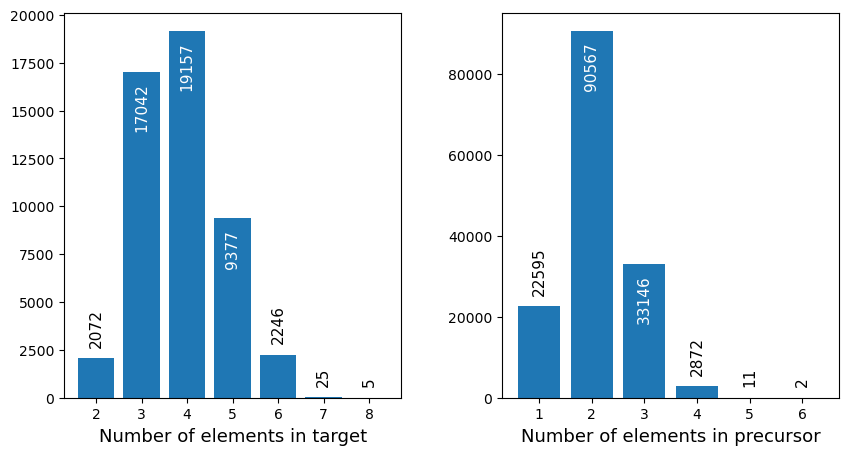

In [209]:
counts = np.zeros((2, 10))
for sys, count in count_target_system.items():
    counts[0, len(sys)] += count
for sys, count in count_prec_system.items():
    counts[1, len(sys)] += count

f, axs = plt.subplots(1,2,figsize=(10,5))
for ax, count in zip(axs, counts):
    b = ax.bar(range(len(count)), count)
    cmax = np.max(count)
    for i, c in enumerate(count):
        if c == 0: continue
        if c < cmax * 0.3:
            ax.text(i, c + cmax*0.03, f'{c:.0f}', rotation=90, fontsize=11, 
                    horizontalalignment='center', verticalalignment='bottom')
        else:
            ax.text(i, c - cmax*0.03, f'{c:.0f}', rotation=90, color=[1,1,1], fontsize=11, 
                    horizontalalignment='center', verticalalignment='top')
axs[0].set_xlabel('Number of elements in target', fontsize=13)
axs[0].set_xlim([1.3,8.7])
axs[1].set_xlabel('Number of elements in precursor', fontsize=13)
axs[1].set_xlim([0.3,6.7])
f.subplots_adjust(wspace=0.3)


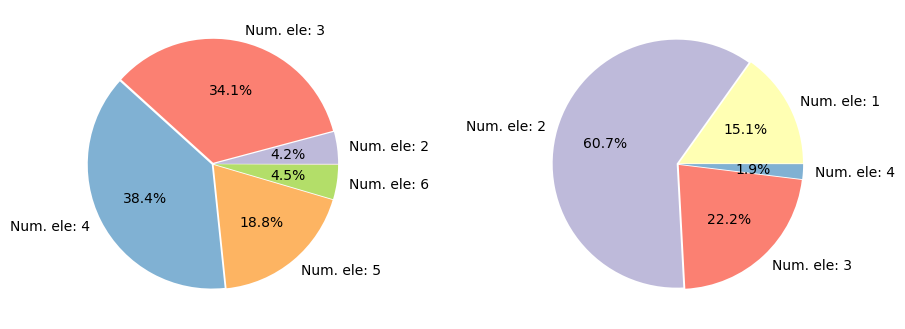

In [248]:
f, axs = plt.subplots(1,2,figsize=(10,5))
_ = axs[0].pie(counts[0], labels=[f'Num. ele: {i}' if counts[0,i] > 1000 else '' for i in range(10)],
           autopct=lambda x: f'{x:.1f}%' if x > 1 else None,
           colors=[mpl.cm.Set3(i) for i in range(12)],
           explode=[0.01]*10,
           )
_ = axs[1].pie(counts[1], labels=[f'Num. ele: {i}' if counts[1,i] > 1000 else '' for i in range(10)],
           autopct=lambda x: f'{x:.1f}%' if x > 1 else None,
           colors=[mpl.cm.Set3(i) for i in range(12)],
           explode=[0.01]*10,
           )
f.subplots_adjust(wspace=0.5)

quatenary가 가장 많음. 

- \# of precursors used for metal element in single reaction

Text(0.5, 0, 'Metal element')

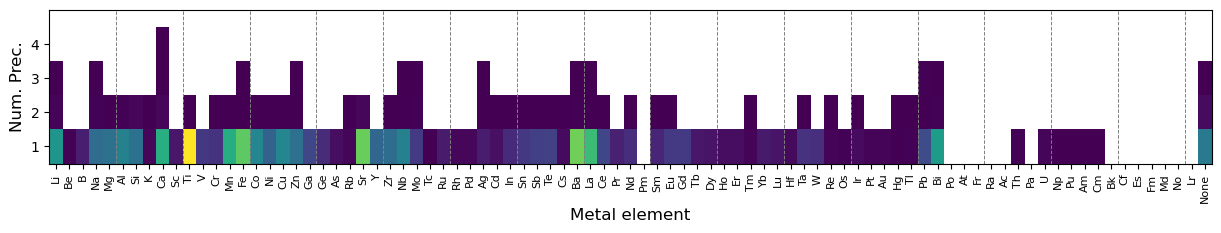

In [7]:
f, ax = plt.subplots(1,1,figsize=(15,2))
cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
ele = list(count_multiple_prec_case.keys())
mat = np.array([v for v in count_multiple_prec_case.values()])
ax.pcolormesh(mat.T, vmin=1, cmap=cmap)
[ax.axvline(i*5, ls='--', color=[0.5, 0.5, 0.5], lw=0.7) for i in range(1,18)]
ax.set_yticks(np.arange(1,5)+0.5, labels=[str(i) for i in range(1,5)])
ax.set_ylim([1, 5.5])
ax.set_xticks(np.arange(len(ele))+0.5, labels=ele, rotation=90, fontsize=8)
ax.set_ylabel('Num. Prec.', fontsize=12)
ax.set_xlabel('Metal element', fontsize=12)
#axs[1].set_ylabel('Valid')
#axs[2].set_ylabel('Train')
#f.subplots_adjust(hspace=0)

In [10]:
for i, v in enumerate(mat.sum(0)):
    if v == 0: continue
    print(f'Num. Prec. used: {i} - count: {v:6.0f}')

Num. Prec. used: 1 - count: 145732
Num. Prec. used: 2 - count:   1573
Num. Prec. used: 3 - count:     97
Num. Prec. used: 4 - count:      6


하나의 원소에 대해 2종 이상의 프리커서가 사용된 경우 존재함

- \# of functional groups (by consisting elements) used for precursors

In [42]:
prec_system = {}
for ligand, sys in unique_ligand.items():
    for ele, info in sys['metals'].items():
        if len(ele) > 0:
            key = '-'.join(list(('Metal',) + ligand))
        else:
            key = '-'.join(ligand)
        if key not in prec_system.keys():
            prec_system[key] = 0
        prec_system[key] += info['count']
prec_system = {k:v for k,v in sorted(prec_system.items(), key=lambda x: x[1], reverse=True)}
mat = np.array(list(prec_system.values()))
m = np.array(['Metal' in x for x in prec_system.keys()])

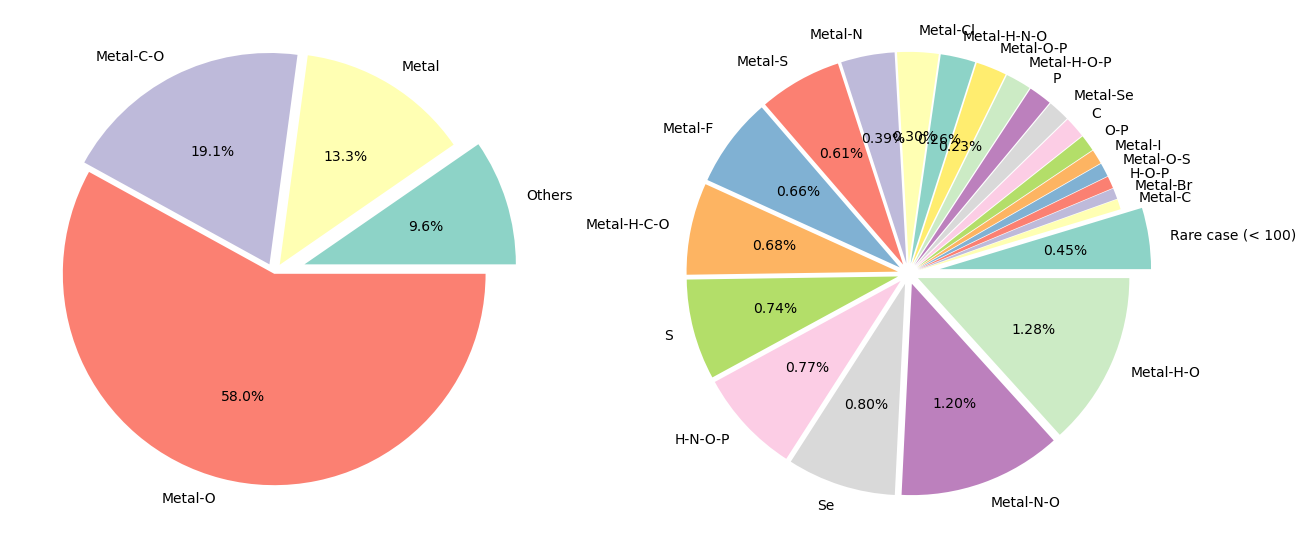

In [44]:
count_all = mat
m1 = count_all > 5000
m2 = count_all < 100
major_idx = sorted(np.where(m1)[0], key=lambda x: count_all[x])
minor_idx = sorted(np.where(~m1 & ~m2)[0], key=lambda x: count_all[x])

f, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].pie([count_all[~m1].sum()] + count_all[major_idx].tolist() , 
           labels=['Others'] + np.array(list(prec_system.keys()))[major_idx].tolist() , 
           colors=[mpl.cm.Set3(i) for i in range(12)],
            autopct='%.1f%%',
            explode=[0.15, 0.05, 0.05, 0]
)
axs[1].pie([count_all[m2].sum()]+count_all[minor_idx].tolist(), 
           labels=['Rare case (< 100)'] + np.array(list(prec_system.keys()))[minor_idx].tolist() , 
           colors=[mpl.cm.Set3(i) for i in range(12)],
           autopct=lambda x: f'{x*0.09621765:.2f}%' if x > 2 else None,
           explode=[0.15] + [0.05] * len(minor_idx)
)
f.subplots_adjust(wspace=0.2)

In [47]:
with open('../data/ligand_frequency.json','w') as f:
    json.dump(prec_system, f)

In [232]:
n1, n2 = np.sum([n for k,n in prec_system.items() if 'None' in k]), np.sum([n for k,n in prec_system.items() if 'None' not in k])
n1, n2, n1/(n1+n2), n2/(n1+n2), n1+n2

(4643, 144550, 0.031120763038480357, 0.9688792369615197, 149193)

- by log scale

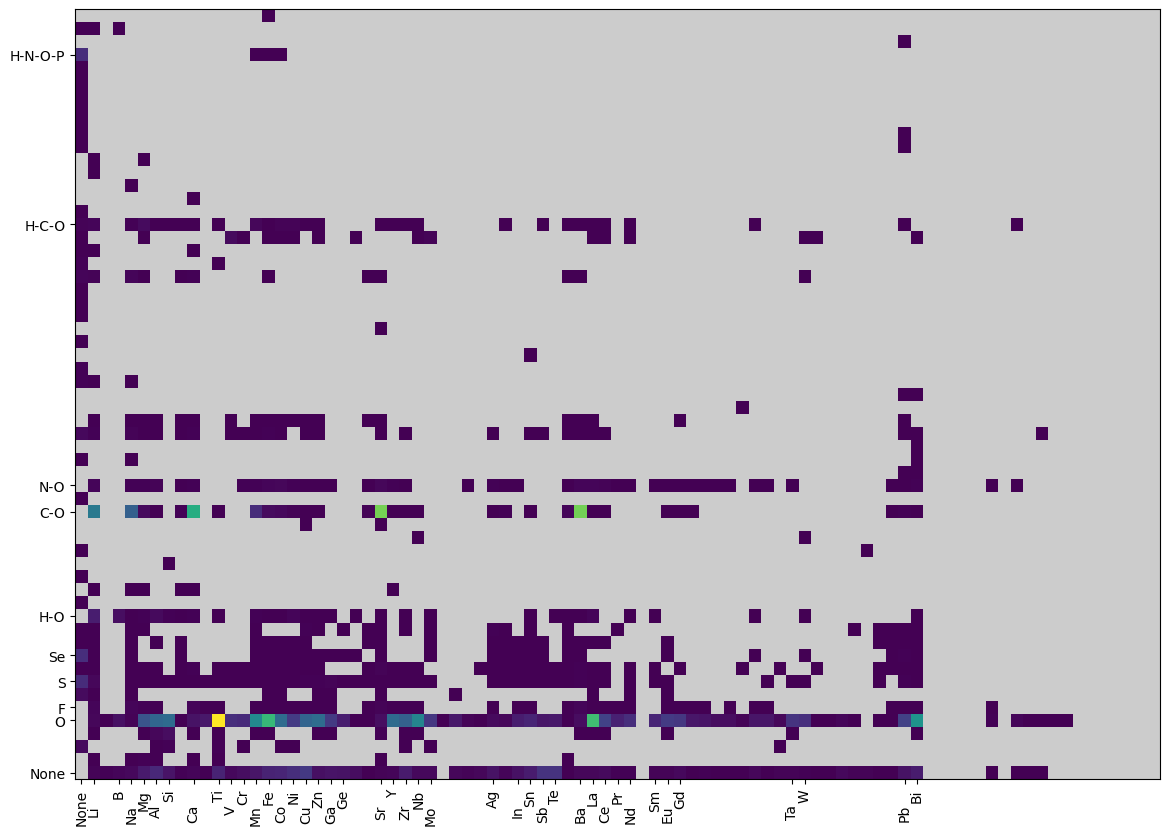

In [8]:
metals = ['None']
metals += list(count_tgt_eles.keys())[:-1]
fg_sys = [tuple()]
fg_sys += sorted(sorted(set([k[1:] for k in prec_system.keys() if len(k) > 1]), key=lambda x: Element(x[0]).number), key=lambda x:len(x))

mat = np.zeros((len(metals), len(fg_sys)))
for i, m in enumerate(metals):
    c = count_tgt_eles.get(m)
    if c is None: continue
    for j, fg in enumerate(fg_sys):
        if c['case'].get(fg) is None:
            continue
        count = c['case'].get(fg)['count']
        mat[i, j] += count

cmap = mpl.cm.viridis
cmap.set_under([0.8,0.8,0.8])
ylabels = ['train','valid','test']
yticks = ['-'.join(list(k)) for k in fg_sys]
yticks[0] = 'None'
f, ax = plt.subplots(1,1,figsize=(14,10))
ax.pcolormesh(mat.T, vmin=1, cmap=cmap)
y_mask = mat.sum(0) > np.sum(mat) * 0.005
ax.set_yticks(np.where(y_mask)[0] + 0.5, labels=np.array(yticks)[y_mask])
x_mask = mat.sum(1) > np.sum(mat) * 0.005
ax.set_xticks(np.where(x_mask)[0] + 0.5, labels=np.array(metals)[x_mask], rotation=90)
for i, t in enumerate(ax.get_xticklabels()):
    if i % 2 == 0: continue
    t.set_y(-0.02)

### frequency-based precursor information

In [22]:
# TODO: make frequency dictionary for recommendation
precursor_usage_freqeuncy = {}
functionalgroup_usage_frequency = {}
total_precursor_used = np.sum([np.sum(v['count']) for v in count_tgt_eles.values()])

for metal, prec_info in count_tgt_eles.items():
    total_metal_used = np.sum(prec_info['count'])
    for func_group, func_info in prec_info['case'].items():
        total_func_used = np.sum(func_info['count'])
        for comp, count in func_info['case'].items():
            pass
#functional_group_info['case']
metal, total_metal_used, func_group, total_func_used, comp, count


('None', 4643, ('H', 'C', 'S', 'Br'), 4, '0.643_0.214_0.071_0.071', [0, 0, 4])

In [62]:
parsed_data['train_reactions'][0]

{'id': 11283,
 'raw_index': 7992,
 'synthesis_type': 'solid_state_ceramic_synthesis',
 'doi': '10.1007/bf00549308',
 'year': 1979,
 'prototype_path': ['AllMaterials/oxides/quaternary/Others/Misc/Y0.00200057Al0.05487283Si0.37153473N0.51443273O0.05715919/Y0.00200057Al0.05487283Si0.37153473N0.51443273O0.05715919'],
 'count_weight': 1.0,
 'target_comp': {'Y': 0.0020005717,
  'Al': 0.054872826,
  'Si': 0.37153473,
  'N': 0.5144327,
  'O': 0.057159193},
 'precursor_comp': [{'Y': 0.4, 'O': 0.6},
  {'Si': 0.33333334, 'O': 0.6666667},
  {'Al': 0.5, 'N': 0.5},
  {'Si': 0.42857143, 'N': 0.5714286}],
 'operations': []}

# Temperature-materials correlation

In [527]:
with gzip.open('../data/screened_single_source_conditional_reaction.pkl.gz','rb') as f:
    ssscr = pickle.load(f)
with gzip.open('../data/screened_single_source_unique_reaction.pkl.gz','rb') as f:
    sssur = pickle.load(f)    

In [27]:
ssscr[0]

{'id': 4,
 'year': 1988,
 'target_comp': {'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375},
 'precursor_comp': [{'Ba': 0.2, 'C': 0.2, 'O': 0.6}, {'Fe': 0.4, 'O': 0.6}],
 'doi': '10.1007/bf00551283',
 'heat_temp': {'mean': 1473.15, 'median': 1473.15, 'raw': [1373.15, 1573.15]},
 'heat_time': {'mean': None, 'median': None, 'raw': []}}

In [471]:
target_precursor = []
vectors = []
condition = []
year = []
precursor_tuple = []
target_strings = []
for rxn in ssscr:
    target = rxn['target_comp']
    target_strings.append(Composition(target).get_integer_formula_and_factor()[0])
    precursor = rxn['precursor_comp']
    year.append(rxn['year'])
    tvec = composition_to_feature(target).squeeze()
    pvec = np.sum([composition_to_feature(p) for p in precursor], 0).squeeze()
    _tup = ()
    for j in np.where(pvec)[0]:
        _tup += (ActiveElements[j], '{:.5f}'.format(pvec[j]))
    precursor_tuple.append(_tup)
    val = []
    if rxn['heat_temp']['median'] is not None:
        val = [rxn['heat_temp']['median'], rxn['heat_temp']['mean']]
    else:
        val = [-1,-1]
    if rxn['heat_time']['median'] is not None:
        val.extend([rxn['heat_time']['median'], rxn['heat_time']['mean']])
    else:
        val.extend([-1,-1])
    target_precursor.append([target, precursor])
    vectors.append([tvec, pvec])
    condition.append(val)

tvecs, pvecs = np.array(vectors).transpose(1,0,2)
targets, precursors = np.array(target_precursor, dtype=object).T
conditions = np.array(condition)
years = np.array(year)

In [472]:
eles = np.array(ActiveElements)
targetele_precursor_pairs = {}
for i, tvec in enumerate(tvecs.astype(bool).squeeze()):
    ele = tuple(eles[tvec])
    if ele not in targetele_precursor_pairs.keys():
        targetele_precursor_pairs[ele] = {}
    if precursor_tuple[i] not in targetele_precursor_pairs[ele].keys():
        targetele_precursor_pairs[ele][precursor_tuple[i]] = []
    targetele_precursor_pairs[ele][precursor_tuple[i]].append(i)
targetele_precursor_pairs = {k:v for k,v in sorted(targetele_precursor_pairs.items(), key=lambda x: np.sum([len(v) for v in x[1].values()]), reverse=True)}

target_precursor_pairs = {}
for i, target in enumerate(target_strings):
    if target not in target_precursor_pairs.keys():
        target_precursor_pairs[target] = {}
    if precursor_tuple[i] not in target_precursor_pairs[target].keys():
        target_precursor_pairs[target][precursor_tuple[i]] = []
    target_precursor_pairs[target][precursor_tuple[i]].append(i)
target_precursor_pairs = {k:v for k,v in sorted(target_precursor_pairs.items(), key=lambda x: np.sum([len(v) for v in x[1].values()]), reverse=True)}

precursor_targetele_pairs = {}
for targetele, precursor_pairs in targetele_precursor_pairs.items():
    for precursor, idxs in precursor_pairs.items():
        if precursor not in precursor_targetele_pairs.keys():
            precursor_targetele_pairs[precursor] = {}
        if targetele not in precursor_targetele_pairs[precursor].keys():
            precursor_targetele_pairs[precursor][targetele] = []
        precursor_targetele_pairs[precursor][targetele].append(idxs)
precursor_targetele_pairs = {k:v for k,v in sorted(precursor_targetele_pairs.items(), key=lambda x: np.sum([len(v) for v in x[1].values()]), reverse=True)}

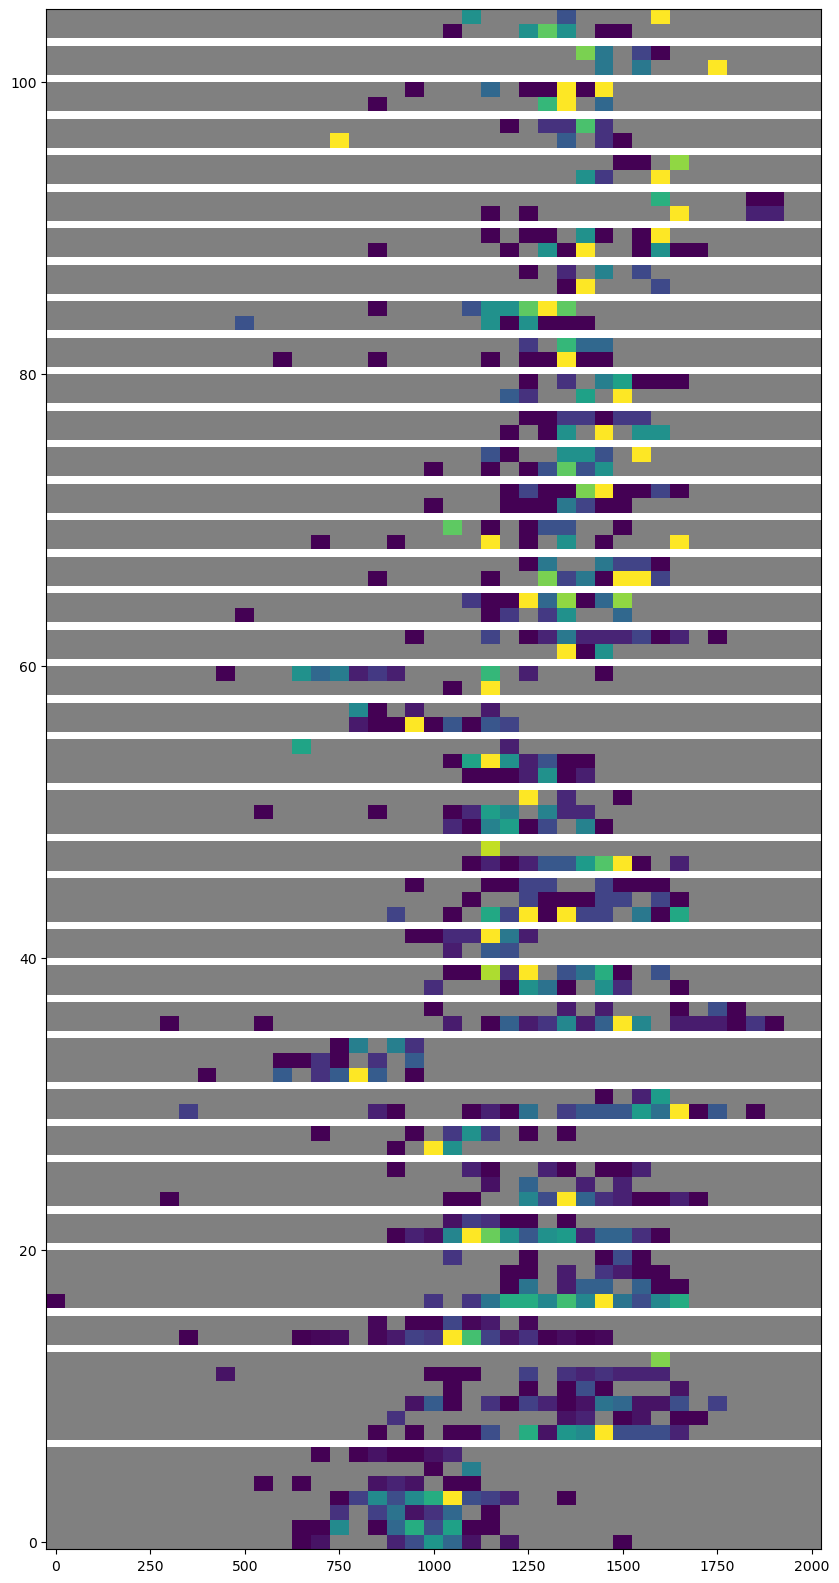

In [387]:
def gaussian_kernel(data, x=np.linspace(0,3000,3001), sigma=1000):
    y = np.exp(-np.square(x - np.array(data).reshape(-1,1)) / sigma).sum(0) / len(data)
    return x, y

def to_bar(data, x=np.linspace(0, 2000, 21)):
    j = np.argmin(np.abs(x - np.array(data).reshape(-1,1)), axis=1)
    y = np.zeros_like(x)
    i, c = np.unique(j, return_counts=True)
    y[i] = c
    return x, y

pairs = {}
for targetele, precursor_pairs in targetele_precursor_pairs.items():
    filtered_precursor_pairs = {k:v for k,v in filter(lambda x: len(x[1]) > 9, precursor_pairs.items())}
    if len(filtered_precursor_pairs) < 2:
        continue
    pairs[targetele] = filtered_precursor_pairs

f, ax = plt.subplots(1,1,figsize=(10,20))
y0 = 0
cmap = plt.cm.viridis
cmap.set_under([0.5,0.5,0.5])
diffs = {}
xticks = []
xtick_labels = []
for target, precursor_conds in pairs.items():
    ys = []
    vs = []
    diffs[target] = []
    for i, idx in enumerate(filter(lambda x: len(x) > 4, precursor_conds.values())):
        v = conditions[idx].T[0]
        vs.append(v.mean())
        x, y = to_bar(v[v > 0], x=np.linspace(0,2000, 41))
        ys.append(y)
    if len(ys) == 0: continue
    vs = np.array(sorted(vs)).reshape(1,-1)
    mat = vs - vs.T
    diff = mat[np.triu_indices_from(mat, k=1)]
    diffs[target] = diff
    ys = np.vstack(ys)
    ax.pcolormesh(x, y0 + np.arange(ys.shape[0]), ys, cmap=cmap, vmin=1)
    y0 += ys.shape[0] + 0.5

        
#         _v = conditions[idx].T[0]
#         v = _v[_v > 0]
#         ax.plot(*gaussian_kernel(v))


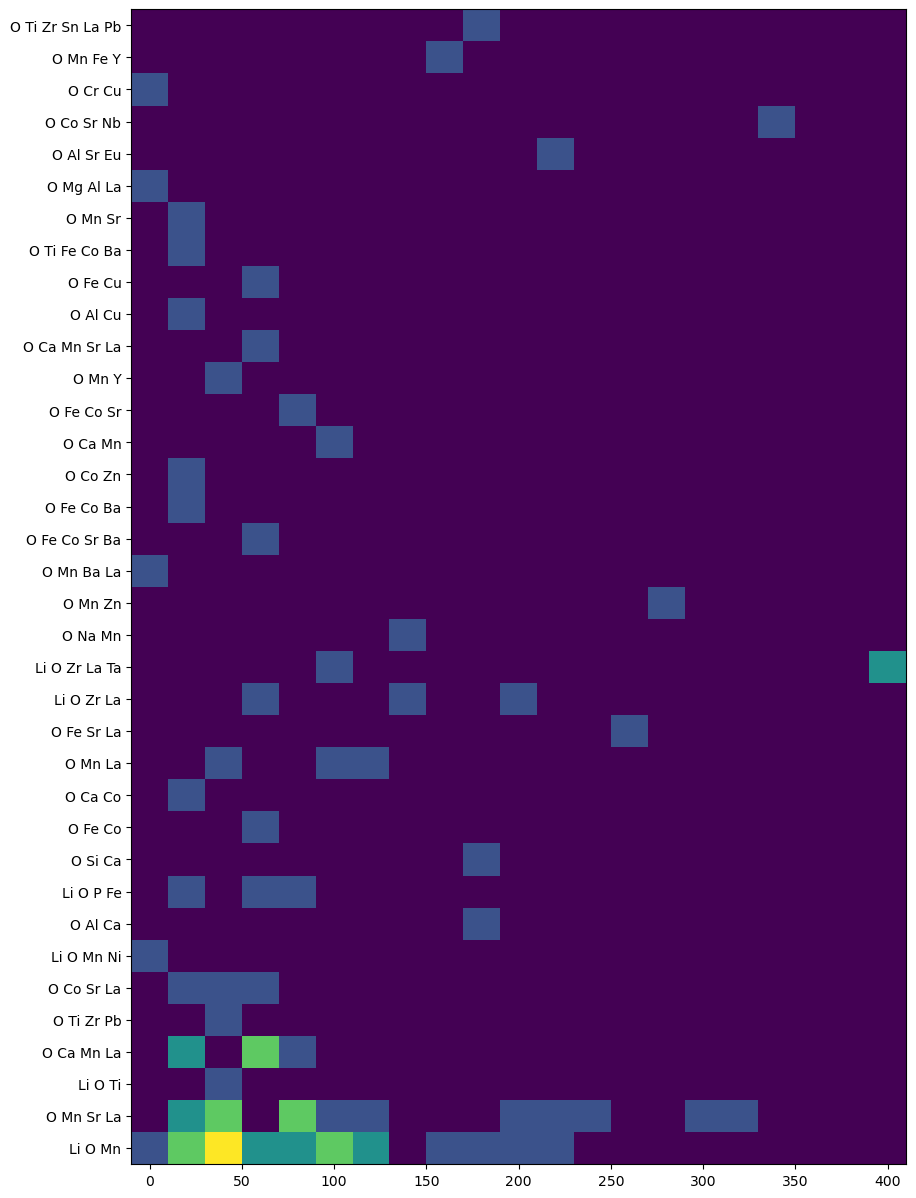

In [397]:
ys = []
for target, diff in diffs.items():
    x, y = to_bar(diff, np.linspace(0, 400, 21))
    ys.append(y)

f, ax = plt.subplots(1,1,figsize=(10,15))
ax.pcolormesh(x, [' '.join(d) for d in diffs.keys()], ys)

Text(0.5, 0, 'Temperature (K)')

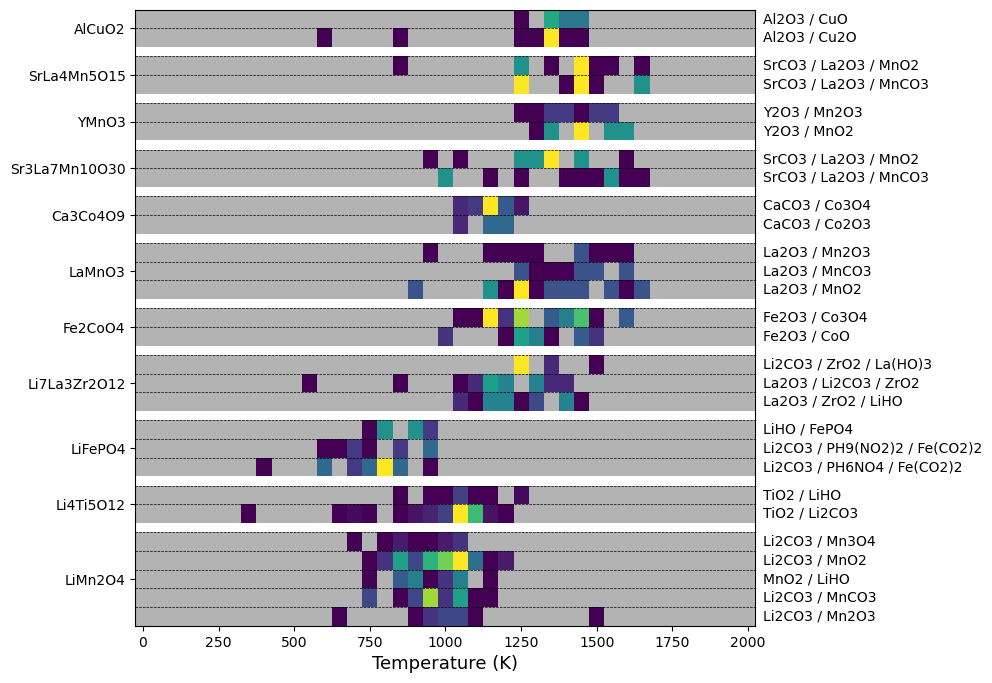

In [504]:
pairs = {}
for targetele, precursor_pairs in target_precursor_pairs.items():
    filtered_precursor_pairs = {k:v for k,v in filter(lambda x: len(x[1]) > 9, precursor_pairs.items())}
    if len(filtered_precursor_pairs) < 2:
        continue
    pairs[targetele] = filtered_precursor_pairs

f, ax = plt.subplots(1,1,figsize=(8,8))
y0 = 0
cmap = plt.cm.viridis
cmap.set_under([0.7,0.7,0.7])
diffs = {}
xticks = []
yticks = []
for target, precursor_conds in pairs.items():
    ys = []
    vs = []
    diffs[target] = []
    for i, idx in enumerate(filter(lambda x: len(x) > 4, precursor_conds.values())):
        v = conditions[idx].T[0]
        vs.append(v.mean())
        x, y = to_bar(v[v > 0], x=np.linspace(0,2000, 41))
        ys.append(y)
        precursor = ' / '.join([Composition(p).get_integer_formula_and_factor()[0] for p in precursors[idx[0]]])
        ax.text(2050, y0+i-0.2, precursor, fontsize=10)
        ax.axhline(y0+i+0.5, ls='--', color='k',lw=0.5)

    vs = np.array(sorted(vs)).reshape(1,-1)
    mat = vs - vs.T
    diff = mat[np.triu_indices_from(mat, k=1)]
    diffs[target] = diff
    ys = np.vstack(ys)
    ax.pcolormesh(x, y0 + np.arange(ys.shape[0]), ys, cmap=cmap, vmin=1)
    yticks.append(y0 + ys.shape[0] * 0.5 - 0.5)
    y0 += ys.shape[0] + 0.5
ax.set_yticks(yticks, labels=pairs.keys(), fontsize=10)
ax.set_xlabel('Temperature (K)', fontsize=13)

Text(0.5, 0, 'Heating time (h)')

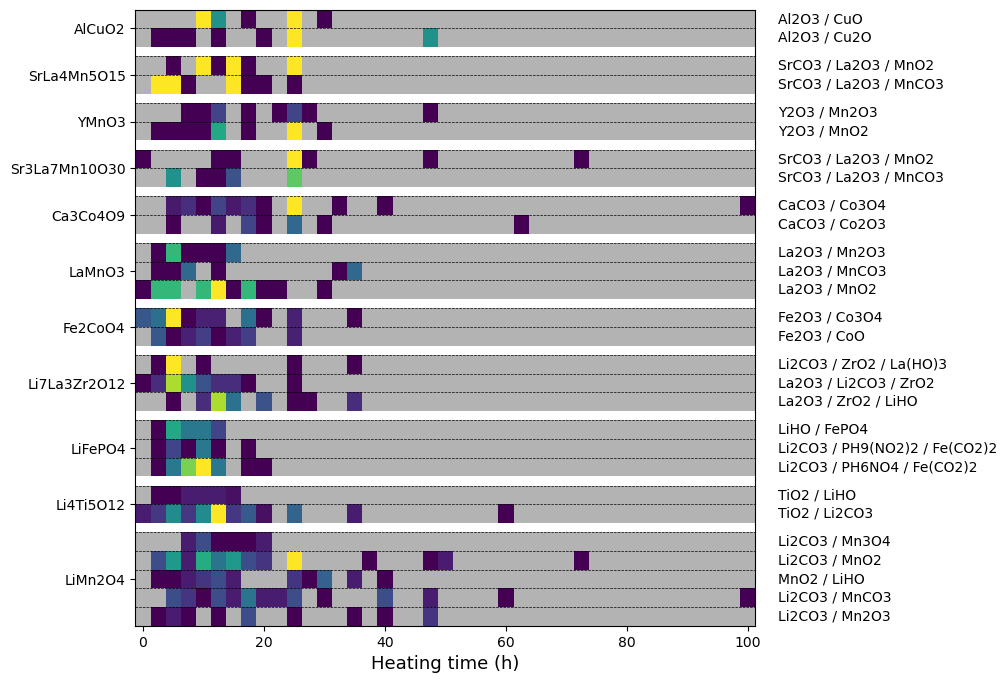

In [510]:
pairs = {}
for targetele, precursor_pairs in target_precursor_pairs.items():
    filtered_precursor_pairs = {k:v for k,v in filter(lambda x: len(x[1]) > 9, precursor_pairs.items())}
    if len(filtered_precursor_pairs) < 2:
        continue
    pairs[targetele] = filtered_precursor_pairs

f, ax = plt.subplots(1,1,figsize=(8,8))
y0 = 0
cmap = plt.cm.viridis
cmap.set_under([0.7,0.7,0.7])
diffs = {}
xticks = []
yticks = []
for target, precursor_conds in pairs.items():
    ys = []
    vs = []
    diffs[target] = []
    for i, idx in enumerate(precursor_conds.values()):
        v = conditions[idx].T[2]
        vs.append(v.mean())
        x, y = to_bar(v[v > 0], x=np.linspace(0,100, 41))
        ys.append(y)
        precursor = ' / '.join([Composition(p).get_integer_formula_and_factor()[0] for p in precursors[idx[0]]])
        ax.text(105, y0+i-0.2, precursor, fontsize=10)
        ax.axhline(y0+i+0.5, ls='--', color='k',lw=0.5)

    vs = np.array(sorted(vs)).reshape(1,-1)
    mat = vs - vs.T
    diff = mat[np.triu_indices_from(mat, k=1)]
    diffs[target] = diff
    ys = np.vstack(ys)
    ax.pcolormesh(x, y0 + np.arange(ys.shape[0]), ys, cmap=cmap, vmin=1)
    yticks.append(y0 + ys.shape[0] * 0.5 - 0.5)
    y0 += ys.shape[0] + 0.5
ax.set_yticks(yticks, labels=pairs.keys(), fontsize=10)
ax.set_xlabel('Heating time (h)', fontsize=13)

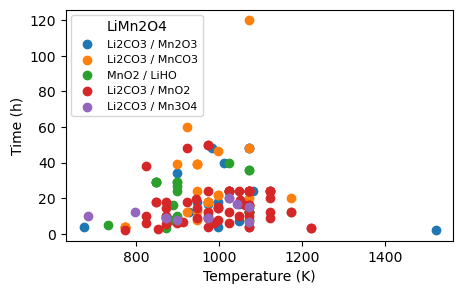

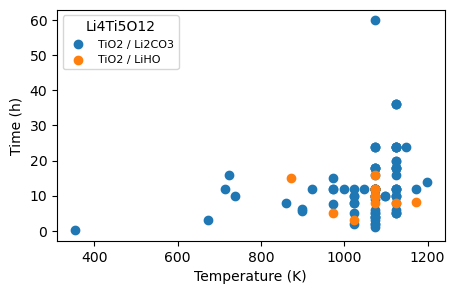

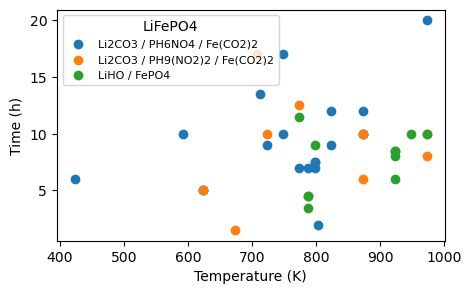

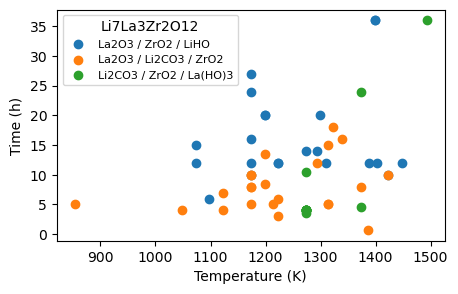

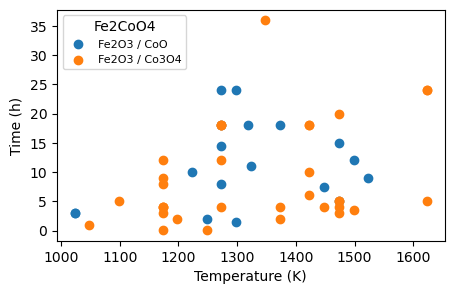

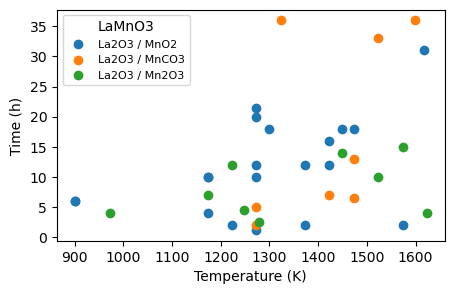

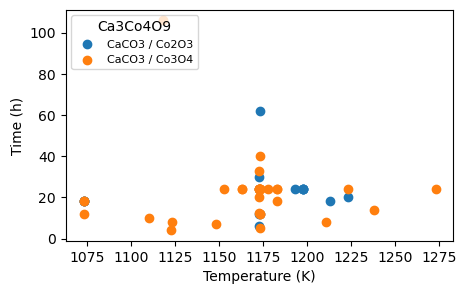

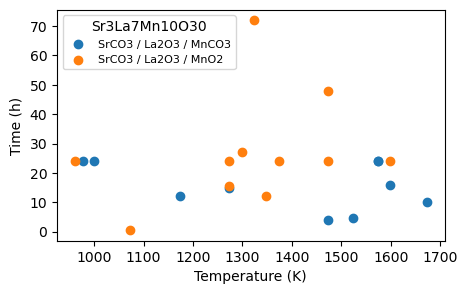

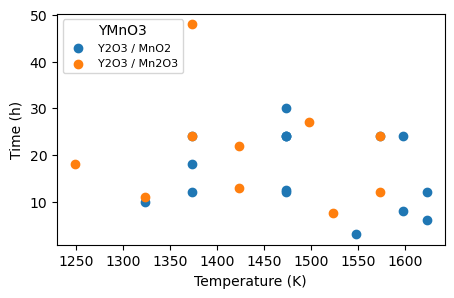

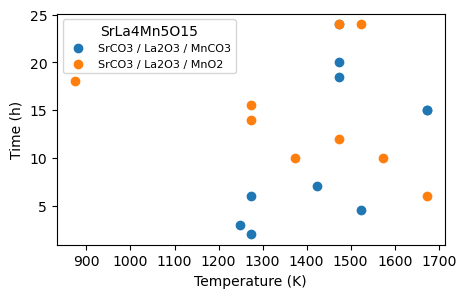

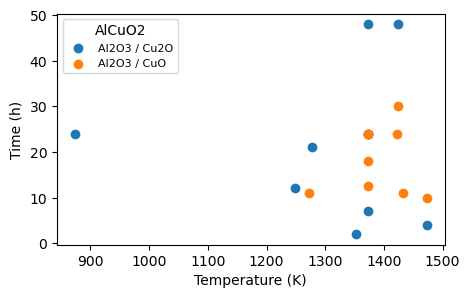

In [526]:

for target, precursor_conds in pairs.items():
    data = []
    for i, idx in enumerate(precursor_conds.values()):
        temp_med, _, time_med, _ = conditions[idx].T
        mask = (temp_med > 0) & (time_med > 0)
        precursor = ' / '.join([Composition(p).get_integer_formula_and_factor()[0] for p in precursors[idx[0]]])
        if mask.sum() > 4:
            data.append([precursor, temp_med[mask], time_med[mask]])
    if len(data) != 0:
        f, ax = plt.subplots(1,1,figsize=(5,3))
        for p, t1, t2 in data:
            ax.scatter(t1, t2, label=p)
        ax.legend(loc='upper left', title=target, fontsize=8)
        ax.set_ylabel('Time (h)')
        ax.set_xlabel('Temperature (K)')

In [376]:
for m in mat:
    print(' '.join([f'{_m:10.3f}' for _m in m]))

     0.000     98.437     64.524     25.145     51.390    115.210     32.015      4.872   -101.553     70.651
   -98.437      0.000    -33.913    -73.292    -47.047     16.773    -66.422    -93.565   -199.990    -27.786
   -64.524     33.913      0.000    -39.379    -13.134     50.686    -32.509    -59.652   -166.077      6.127
   -25.145     73.292     39.379      0.000     26.245     90.065      6.870    -20.273   -126.699     45.506
   -51.390     47.047     13.134    -26.245      0.000     63.820    -19.375    -46.518   -152.943     19.261
  -115.210    -16.773    -50.686    -90.065    -63.820      0.000    -83.195   -110.338   -216.764    -44.559
   -32.015     66.422     32.509     -6.870     19.375     83.195      0.000    -27.143   -133.568     38.636
    -4.872     93.565     59.652     20.273     46.518    110.338     27.143      0.000   -106.425     65.779
   101.553    199.990    166.077    126.699    152.943    216.764    133.568    106.425      0.000    172.205
   -70.651

In [555]:

#for rxn in sssur:
ns = [0, 0, 0, 0]
for sssur_ in sssur:
    for t1, t2 in zip(sssur_['heat_temp'], sssur_['heat_time']):
        n1, n2 = len(t1['raw']), len(t2['raw'])
        if (n1 != 0) and (n2 != 0):
            ns[0] += 1
        elif (n1 == 0) and (n2 != 0):
            ns[1] += 1
        elif (n1 != 0) and (n2 == 0):
            ns[2] += 1
        elif (n1 == 0) and (n2 == 0):
            ns[3] += 1

In [556]:
pytho

[31718, 644, 3080, 8716]